# Were Splash stars heated or already born hot?
## The chemodynamical memory of a major merger in a simulated NIHAO-UHD Milky Way analogue II

Author: Sven Buder (ANU), sven.buder@anu.edu.au  
GitHub repository: https://github.com/svenbuder/gse_nihaouhd  
arXiv: YYMM.NNNNN

# Preamble

In [1]:
# Import packages
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm, LinearSegmentedColormap,Normalize
from matplotlib.patches import Patch, Rectangle, Circle
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerTuple, HandlerBase
from matplotlib.collections import LineCollection


from scipy.optimize import curve_fit
from scipy import stats
from scipy.stats import gaussian_kde, binned_statistic_2d, skew, norm, skewnorm
from scipy.ndimage import gaussian_filter
from scipy.interpolate import RBFInterpolator,splprep, splev

from astropy.table import Table, join
from astropy.cosmology import Planck18, z_at_value
import astropy.units as u

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# from hyppo.ksample import Energy

# Set the seed for reproducibility
np.random.seed(8123)

In [2]:
class HandlerGradientRect(HandlerBase):
    def __init__(self, cmap, **kw):
        super().__init__(**kw)
        self.cmap = cmap

    def create_artists(self, legend, orig_handle, xdescent, ydescent,
                       width, height, fontsize, trans):
        # Create a 1×N gradient image (left→right)
        n = 256
        grad = np.linspace(0, 1, n).reshape(1, -1)

        im = matplotlib.image.AxesImage(
            legend.axes,
            cmap=self.cmap,
            origin="lower",
            interpolation="bilinear",
            extent=[xdescent, xdescent + width, ydescent, ydescent + height],
            transform=trans,
        )
        im.set_data(grad)
        # Optional: a thin black border around the swatch
        border = Rectangle((xdescent, ydescent), width, height,
                           transform=trans, fill=False, edgecolor="black", linewidth=0.8)
        return [im, border]

In [3]:
def format_with_uncertainty(value, uncertainty):
    if uncertainty == 0:
        raise ValueError("Uncertainty cannot be zero.")
    # Calculate the number of significant figures in the uncertainty
    sig_digits = -int(np.floor(np.log10(abs(uncertainty))))+1
    # Format both value and uncertainty to the same number of decimal places
    formatted_value = f"{round(value, sig_digits):.{sig_digits}f}"
    formatted_uncertainty = f"{round(uncertainty, sig_digits):.{sig_digits}f}"
    return formatted_value, formatted_uncertainty

# 2 Data

We are using the star particle FITS file from the extensive g8.26e11 NIHAO-UHD simulation.

Information on how the FITS file was created from the original simulation output can be found here:  
https://github.com/svenbuder/preparing_NIHAO/

The FITS file used in this notebook can be found here:  
https://www.mso.anu.edu.au/~buder/NIHAO_prepared/

In [4]:
data = Table.read('data/NIHAO_g8.26e11_extensive_stars.fits')

In [5]:
data['energy'] = 0.5 * (data['vx']**2+data['vy']**2+data['vz']**2) + data['potential_phi']
data['r_2d'] = np.sqrt(data['x']**2+data['y']**2)
data['r_3d'] = np.sqrt(data['x']**2+data['y']**2+data['z']**2)
data['r_birth_3d'] = np.sqrt(data['x_birth']**2+data['y_birth']**2+data['z_birth']**2)
data['r_birth_2d'] = np.sqrt(data['x_birth']**2+data['y_birth']**2)

data['vr'] = (data['x']*data['vx'] + data['y']*data['vy']) / data['r_2d']
data['vphi'] = (-data['y']*data['vx'] + data['x']*data['vy']) / data['r_2d']
# data['vz'] = data['vz']


In [6]:
solar_radius = 8.2 # Solar galactocentric cylindrical radius / kpc
torus_radius = 0.5 # Solar neighbourhood in 3D / kpc
solar_age = 4.5 # Solar age / Gyr
solar_like_age = 0.5 # limit for Solar-like age / Gyr

solar_circle_solar_age = (
    (np.sqrt((np.sqrt(data['x']**2 + data['y']**2) - solar_radius)**2 + data['z']**2) < torus_radius) &
    (np.abs(data['age'] - solar_age) < solar_like_age)
)
solar_circle_solar_age_feh = np.round(np.median(data['Fe_H'][solar_circle_solar_age]),2)
print('Median [Fe/H] of stars within 0.5kpc of Sun (Rgal,Z = 8.2,0) and age within 0.5Gyr of Sun (4.5 Gyr): '+str(solar_circle_solar_age_feh)+' dex')

Median [Fe/H] of stars within 0.5kpc of Sun (Rgal,Z = 8.2,0) and age within 0.5Gyr of Sun (4.5 Gyr): 0.15 dex


In [7]:
elements = ['He','C','N','O','Ne','Na','Mg','Al','Si','S','Cl','Ti','Mn','Fe','Ni','Cu','Zn','Y','Ba','Ce','Eu']
print('Median [X/H] of stars within 0.5kpc of Sun (Rgal,Z = 8.2,0) and age within 0.5Gyr of Sun (4.5 Gyr):')
for element in elements:
    solar_circle_solar_age_elem = np.round(np.median(data[element+'_H'][solar_circle_solar_age]),2)
    print('['+element+'/H]: '+str(solar_circle_solar_age_elem))
    # data[element+'_H'] -= solar_circle_solar_age_elem
print('Did *NOT* apply renormalization to solar circle abundances!')

Median [X/H] of stars within 0.5kpc of Sun (Rgal,Z = 8.2,0) and age within 0.5Gyr of Sun (4.5 Gyr):
[He/H]: 0.06
[C/H]: 0.11
[N/H]: 0.23
[O/H]: 0.19
[Ne/H]: 0.38
[Na/H]: 0.37
[Mg/H]: 0.07
[Al/H]: 0.21
[Si/H]: 0.32
[S/H]: 0.28
[Cl/H]: -0.65
[Ti/H]: -0.1
[Mn/H]: 0.33
[Fe/H]: 0.15
[Ni/H]: 0.37
[Cu/H]: 0.05
[Zn/H]: -0.14
[Y/H]: 0.4
[Ba/H]: 0.61
[Ce/H]: 0.58
[Eu/H]: -0.59
Did *NOT* apply renormalization to solar circle abundances!


In [8]:
## We could also mimic a GALAH-like footprint (as for Buder et al, 2024):
solar_radius = 8.2 # Solar Galactocentric cylindyrcal radius
galah_radius = 2.0 # 2kpc footprint around Sun in 3D / kpc
galah_like = (
    # Torus with torus centre radius at 8.2 and torus radius 4.2 
    (np.sqrt((data['r_2d'] - solar_radius)**2 + data['z']**2) < galah_radius)
)
# data = data[galah_like | (data['r_3d'] > 50)]

# 3 Analysis

## 3. 1 Tracing in-situ formation, past accretion, and ongoing accretion

1) in-situ (currently within 50kpc and born within 50kpc)  
2) past accretion (currently within 50kpc, but born outside 50kpc)  
3) ongoing accretion (currently outside 50kpc but within 200kpc)  

In [9]:
outside_50kpc = (data['r_3d'] > 50) | ((data['age'] < 10) & (data['Fe_H'] < -1)) | (data['energy'] > 0)
within_50kpc = (data['r_3d'] <= 50)
within_50kpc_born_outside_50kpc = (~outside_50kpc) & ((data['r_birth_3d'] > 50) | (abs(data['z_birth']) > 5))
within_50kpc_born_within_50kpc = (~outside_50kpc) & (~within_50kpc_born_outside_50kpc)

In [10]:
# How much does the selection of z_birth matter for the accreted stars?
with_z_birth = (~outside_50kpc) & ((data['r_birth_3d'] > 50) | (abs(data['z_birth']) > 5))
without_z_birth = (~outside_50kpc) & ((data['r_birth_3d'] > 50))
print("How many stars would be added when z_birth is considered:", len(data[with_z_birth]),'vs.', len(data[without_z_birth]),' = ',len(data[with_z_birth]) - len(data[without_z_birth]), np.round((len(data[with_z_birth]) - len(data[without_z_birth]))/len(data[with_z_birth])*100),'%')

How many stars would be added when z_birth is considered: 249769 vs. 178987  =  70782 28.0 %


In [11]:
# How many stars fall into the region where it is hard to separate merger debris from in-situ stars?
# (Age 8.50-8.65 Gyr and -0.6 < [Fe/H] < -0.2)
age_metallicity_overlap = (data['age'] < 8.65) & (data['age'] > 8.50) & (data['Fe_H'] > -0.6) & (data['Fe_H'] < -0.2)
print("Stars in age and metallicity overlap:",len(data[age_metallicity_overlap]), len(data[within_50kpc_born_outside_50kpc]), np.round(100*len(data[age_metallicity_overlap])/len(data[within_50kpc_born_outside_50kpc]),1),'%')


Stars in age and metallicity overlap: 6771 249769 2.7 %


In [12]:
# How many percent of the simulation are in each selection? 
nr_whole_simulation  = len(data['r_3d'])

print(nr_whole_simulation, np.sum(data['mass'])/10**10)
for selection, name in zip(
    [within_50kpc, within_50kpc_born_within_50kpc, within_50kpc_born_outside_50kpc, outside_50kpc],
    [' in all 50kpc',' in  in 50kpc', ' in out 50kpc', 'out out 50kpc']
):
    nr = len(data['r_3d'][selection])
    percentage = np.round(100*nr/nr_whole_simulation,1)
    print(name, nr, percentage, str(np.round(np.sum(data['mass'][selection])/10**9,2))+'x10^9 Msol')

print('\nOf those born before 8.6 Gyr')
print(len(data['r_3d'][data['age'] >= 8.6]), np.sum(data['mass'][data['age'] >= 8.6])/10**10)
for selection, name in zip(
    [within_50kpc, within_50kpc_born_within_50kpc, within_50kpc_born_outside_50kpc, outside_50kpc],
    [' in all 50kpc',' in  in 50kpc', ' in out 50kpc', 'out out 50kpc']
):
    # and born before 8.6 Gyr
    nr = len(data['r_3d'][selection & (data['age'] >= 8.6)])
    percentage = np.round(100*nr/nr_whole_simulation,1)
    print(name, nr, percentage, str(np.round(np.sum(data['mass'][selection & (data['age'] >= 8.6)])/10**9,2))+'x10^9 Msol')


2927668 2.27679
 in all 50kpc 2829941 96.7 22.0x10^9 Msol
 in  in 50kpc 2574428 87.9 20.06x10^9 Msol
 in out 50kpc 249769 8.5 1.9x10^9 Msol
out out 50kpc 103471 3.5 0.81x10^9 Msol

Of those born before 8.6 Gyr
1594516 1.1973038
 in all 50kpc 1532348 52.3 11.49x10^9 Msol
 in  in 50kpc 1278757 43.7 9.56x10^9 Msol
 in out 50kpc 248946 8.5 1.9x10^9 Msol
out out 50kpc 66813 2.3 0.52x10^9 Msol


In [13]:
# What was is the mass ratio now and what was the mass ratio 8.6 Gyr ago (when the merger happend)?
ratio_now = np.sum(data['mass'][within_50kpc_born_within_50kpc]) / np.sum(data['mass'][within_50kpc_born_outside_50kpc])
print('1:'+"{:.0f}".format(ratio_now))
ratio_8p6_gyr_ago = np.sum(data['mass'][within_50kpc_born_within_50kpc & (data['age'] >= 8.6)]) / np.sum(data['mass'][within_50kpc_born_outside_50kpc & (data['age'] >= 8.6)])
print('1:'+"{:.0f}".format(ratio_8p6_gyr_ago))

1:11
1:5


Follow up from Figure 1b: tracing major accretion

In [14]:
# Select overdensities in birth positions and ages: birth_overdensities = dict()
birth_overdensities = dict()

age_delta = 1 # Gyr

# xmin, xmax, ymin, ymax, zmin, zmax
birth_overdensities[0]  = [ -40, -25, 10, 33,-175,-155,np.round(12.0-age_delta,2),np.round(12.0+age_delta,2)] # 12.24
birth_overdensities[1]  = [ -19,  -9, 46, 68,-174,-160,np.round(11.9-age_delta,2),np.round(11.9+age_delta,2)] # 11.92
birth_overdensities[2]  = [   0,  12, 20, 45,-176,-164,np.round(11.8-age_delta,2),np.round(11.8+age_delta,2)] # 11.79
birth_overdensities[3]  = [ -53, -38, 30, 60,-166,-144,np.round(11.7-age_delta,2),np.round(11.7+age_delta,2)] # 11.72
birth_overdensities[4]  = [ -80, -65, 32, 52,-154,-130,np.round(11.6-age_delta,2),np.round(11.6+age_delta,2)] # 11.60
birth_overdensities[5]  = [ -79, -72, 50, 66,-142,-124,np.round(11.5-age_delta,2),np.round(11.5+age_delta,2)] # 11.48
birth_overdensities[6]  = [ -86, -79, 50, 75,-132,-114,np.round(11.4-age_delta,2),np.round(11.4+age_delta,2)] # 11.37
birth_overdensities[7]  = [ -92, -80, 65, 90,-115, -98,np.round(11.3-age_delta,2),np.round(11.3+age_delta,2)] # 11.29
birth_overdensities[8]  = [-114,-106, 64, 81, -86, -72,np.round(11.2-age_delta,2),np.round(11.2+age_delta,2)] # 11.16
birth_overdensities[9]  = [-120,-107, 45, 64, -86, -66,np.round(11.1-age_delta,2),np.round(11.1+age_delta,2)] # 11.06
birth_overdensities[10] = [-117,-112, 39, 51, -71, -62,np.round(10.9-age_delta,2),np.round(10.9+age_delta,2)] # 10.96
birth_overdensities[11] = [-120,-114, 29, 46, -62, -44,np.round(10.8-age_delta,2),np.round(10.8+age_delta,2)] # 10.82
birth_overdensities[12] = [-114,-100, 29, 46, -62, -44,np.round(10.7-age_delta,2),np.round(10.7+age_delta,2)] # 10.82
birth_overdensities[13] = [-113,-103, 14, 30, -61, -43,np.round(10.6-age_delta,2),np.round(10.6+age_delta,2)] # 10.67
birth_overdensities[14] = [-104, -98,  8, 25, -50, -43,np.round(10.5-age_delta,2),np.round(10.5+age_delta,2)] # 10.51
birth_overdensities[15] = [ -93, -84, 12, 32, -66, -48,np.round(10.4-age_delta,2),np.round(10.4+age_delta,2)] # 10.42
birth_overdensities[16] = [ -82, -73, 11, 29, -63, -49,np.round(10.3-age_delta,2),np.round(10.3+age_delta,2)] # 10.31
birth_overdensities[17] = [ -62, -53,  9, 34, -69, -54,np.round(10.2-age_delta,2),np.round(10.2+age_delta,2)] # 10.19
birth_overdensities[18] = [ -36, -20, 17, 33, -73, -44,np.round(10.1-age_delta,2),np.round(10.1+age_delta,2)] # 10.09
birth_overdensities[19] = [ -36, -20,-10, 15, -73, -44,np.round(10.0-age_delta,2),np.round(10.0+age_delta,2)] #  9.98
birth_overdensities[20] = [ -31, -19,-25, -5, -43, -28,np.round( 9.9-age_delta,2),np.round( 9.9+age_delta,2)] #  9.88
birth_overdensities[21] = [ -12,   0,-35,-15, -23,  -6,np.round( 9.8-age_delta,2),np.round( 9.8+age_delta,2)] #  9.75
birth_overdensities[22] = [   9,  19,-34,-12,   2,  16,np.round( 9.6-age_delta,2),np.round( 9.6+age_delta,2)] #  9.61
birth_overdensities[23] = [  20,  35, -6, 10,  14,  34,np.round( 9.5-age_delta,2),np.round( 9.5+age_delta,2)] #  9.56
birth_overdensities[24] = [  14,  28, 19, 28,  25,  36,np.round( 9.4-age_delta,2),np.round( 9.4+age_delta,2)] #  9.46
birth_overdensities[25] = [  10,  20, 27, 41,  23,  38,np.round( 9.3-age_delta,2),np.round( 9.3+age_delta,2)] #  9.34
birth_overdensities[26] = [   6,  15, 31, 41,  15,  27,np.round( 9.2-age_delta,2),np.round( 9.2+age_delta,2)] #  9.22
birth_overdensities[27] = [  -4,  15, 28, 39,   8,  17,np.round( 9.1-age_delta,2),np.round( 9.1+age_delta,2)] #  9.10
birth_overdensities[28] = [ -17,   3, 12, 29,  -8,   7,np.round( 9.0-age_delta,2),np.round( 9.0+age_delta,2)] #  9.04
birth_overdensities[29] = [ -19,   5,-13,  1, -12,   0,np.round( 8.9-age_delta,2),np.round( 8.9+age_delta,2)] #  8.89
birth_overdensities[30] = [   4,  14,-21,-10,   3,  10,np.round( 8.8-age_delta,2),np.round( 8.8+age_delta,2)] #  8.80
birth_overdensities[31] = [   3,  27, -6,  3,   2,  11,np.round( 8.7-age_delta,2),np.round( 8.7+age_delta,2)] #  8.70
birth_overdensities[32] = [ -23,  19,-16, 13,  -4,   5,np.round( 8.6-age_delta,2),np.round( 8.6+age_delta,2)] #  8.62

In [15]:
x_trace = []
y_trace = []
z_trace = []
age_percentiles = []
feh_percentiles = []

overdensity_dict = dict()

for overdensity_index, overdensity in enumerate(birth_overdensities.keys()):
    
    in_overdensity = (
        (np.sqrt(data['x']**2+data['y']**2+data['z']**2) < 50) &
        (data['x_birth'] > birth_overdensities[overdensity][0]) &
        (data['x_birth'] < birth_overdensities[overdensity][1]) &
        (data['y_birth'] > birth_overdensities[overdensity][2]) &
        (data['y_birth'] < birth_overdensities[overdensity][3]) &
        (data['z_birth'] > birth_overdensities[overdensity][4]) &
        (data['z_birth'] < birth_overdensities[overdensity][5]) &
        (data['age'] > birth_overdensities[overdensity][6]) &
        (data['age'] < birth_overdensities[overdensity][7]) &
        (data['Fe_H'] < -0.4)
    )

    median_age = np.round(np.median(data['age'][in_overdensity]),2)
    
    overdensity_dict[str(median_age)] = in_overdensity

    x_trace.append(np.median(data['x_birth'][in_overdensity]))
    y_trace.append(np.median(data['y_birth'][in_overdensity]))
    z_trace.append(np.median(data['z_birth'][in_overdensity]))
    age_percentiles.append(np.percentile(data['age'][in_overdensity],q=[16,50,84]))
    feh_percentiles.append(np.percentile(data['Fe_H'][in_overdensity],q=[16,50,84]))

In [16]:
# Fit the inclination angle of the merger in 3D and 2D (X-Z birth) 
inclination_input = np.array([x_trace[17:], y_trace[17:], z_trace[17:]]).T
centroid = np.mean(inclination_input, axis=0)
_, _, vh = np.linalg.svd(inclination_input - centroid)
direction = vh[0]
direction_norm = direction / np.linalg.norm(direction)
theta_rad = np.arccos(np.abs(direction_norm[2]))  # use abs to get [0, 90] degrees
theta_deg = np.degrees(theta_rad)

print('Inclination via SVD in 3D: '+str(int(np.round(theta_deg))))

coeffs = np.polyfit(inclination_input[:,0], inclination_input[:,2], deg=1)
a, b = coeffs
theta_rad = np.arctan(a)
theta_deg = np.degrees(theta_rad)

print('Inclination via linear fit in XZ: '+str(int(np.round(theta_deg))))

Inclination via SVD in 3D: 36
Inclination via linear fit in XZ: 52


## 3.4 Merger process and its chemodynamical effects

/var/folders/g_/1ch053ys79n87jsnqjz0yr_h0000gq/T/ipykernel_51975/3001373592.py:39: RuntimeWarning: invalid value encountered in divide
  Hrow[:,row] /= np.nanmax(Hrow[:,row])


VPhi of accreted stars in Solar neighbourhood: $V_\varphi = 100_{-70}^{+80}\,\mathrm{km\,s^{-1}}$


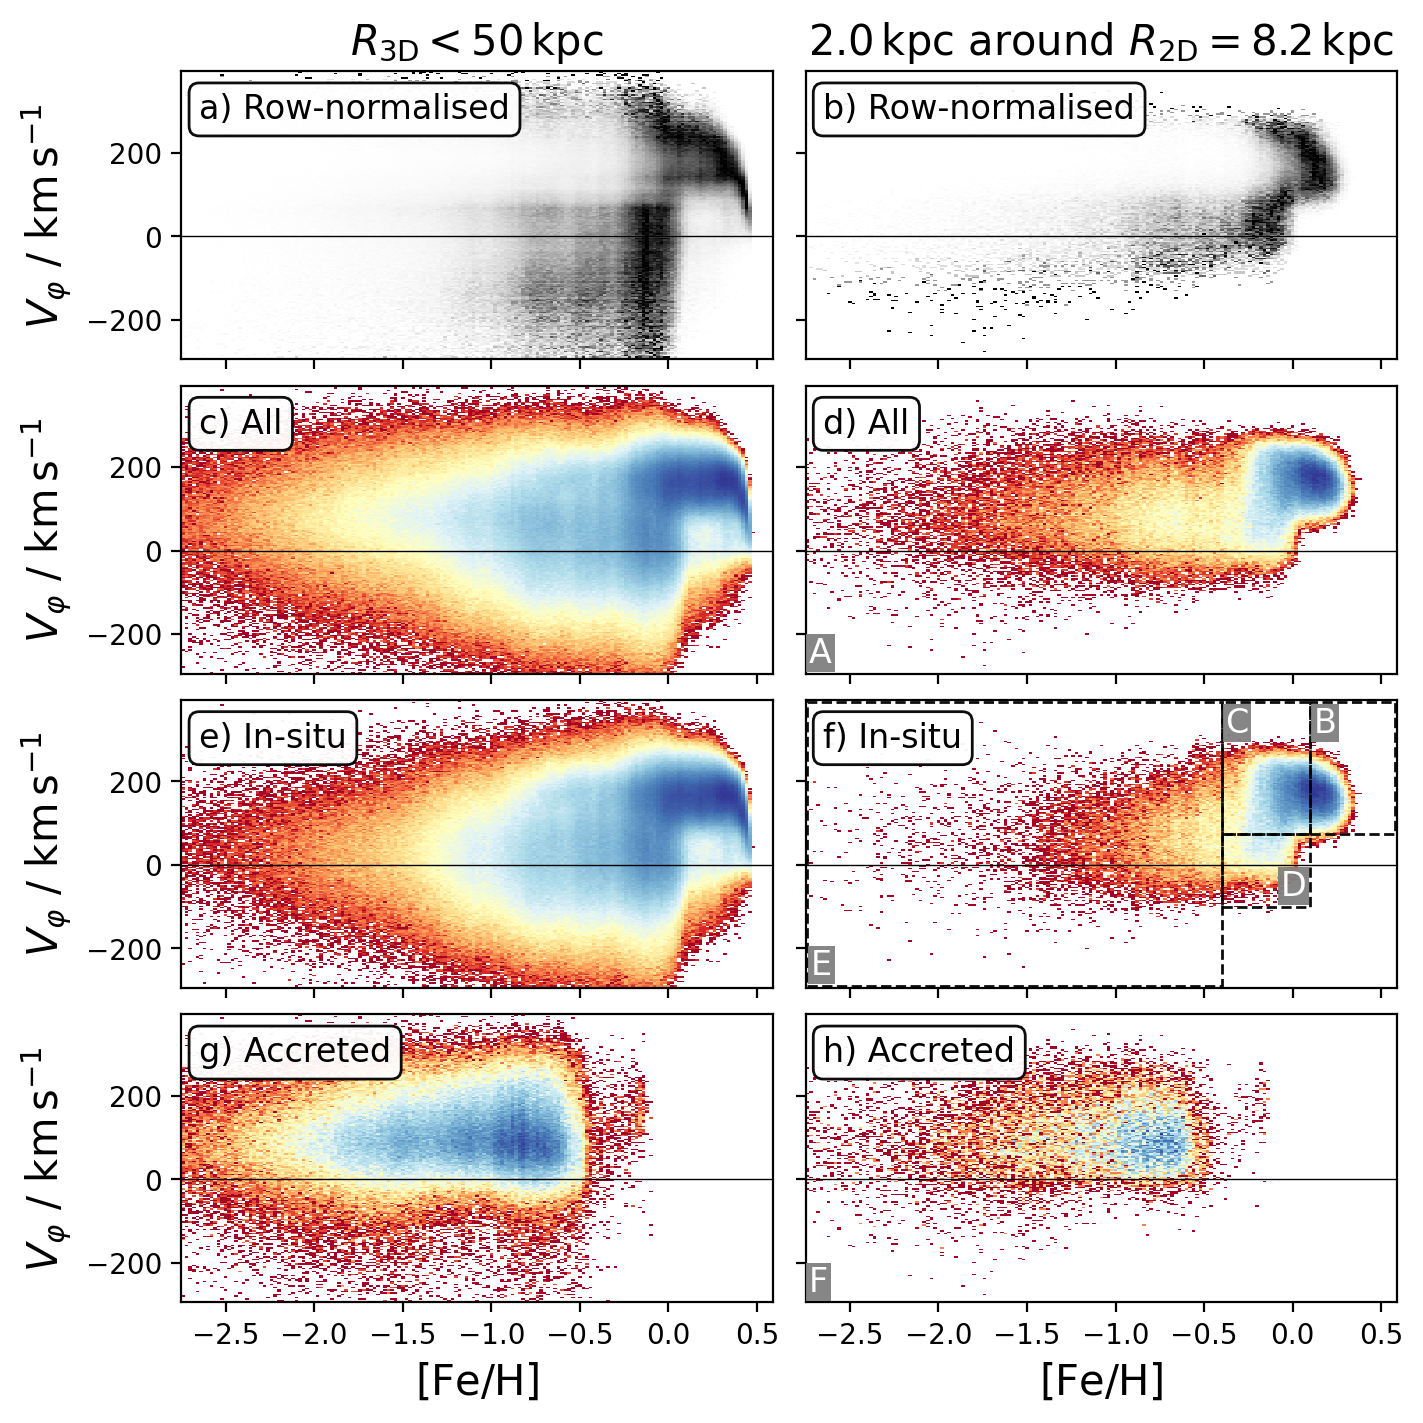

In [17]:
# Have the "Splash" Stars really been splashed?

f, gs = plt.subplots(4,2,figsize=(7,7),sharex=True,sharey=True,constrained_layout=True)

feh_vphi_bins = (np.arange(-2.75,0.6,0.02),np.linspace(-295,395,200))

panels = ['a)','b)','c)','d)','e)','f)','g)','h)']
panel_description = ['Row-normalised','All','In-situ','Accreted']

for index, selection in enumerate([within_50kpc, within_50kpc, within_50kpc_born_within_50kpc, within_50kpc_born_outside_50kpc]):
    
    if index == 0:
        ax = gs[index,0]
        ax.text(0.03,0.925,panels[2*index]+' '+panel_description[index],fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))

        H, xedges, yedges = np.histogram2d(
            data['Fe_H'][selection],
            data['vphi'][selection],
            bins = feh_vphi_bins
        )
        Hrow = H.copy()
        for row in range(np.shape(Hrow)[1]):
            Hrow[:,row] /= np.nanmax(Hrow[:,row])
        Hrow[Hrow==0] = np.nan
        ax.pcolormesh(xedges, yedges, Hrow.T, shading='auto', cmap='Greys')#, norm=LogNorm())  # or any colormap you like
        ax.set_ylabel(r'$V_\varphi~/~\mathrm{km\,s^{-1}}$',fontsize=15)
        ax.axhline(0,lw=0.5,color='k')

        ax = gs[index,1]
        ax.text(0.03,0.925,panels[2*index+1]+' '+panel_description[index],fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))

        H, xedges, yedges = np.histogram2d(
            data['Fe_H'][selection & galah_like],
            data['vphi'][selection & galah_like],
            bins = feh_vphi_bins
        )
        Hrow = H.copy()
        for row in range(np.shape(Hrow)[1]):
            Hrow[:,row] /= np.nanmax(Hrow[:,row])
        Hrow[Hrow==0] = np.nan
        ax.pcolormesh(xedges, yedges, Hrow.T, shading='auto', cmap='Greys')#, norm=LogNorm())  # or any colormap you like

    else:
        ax = gs[index,0]
        ax.text(0.03,0.925,panels[2*index]+' '+panel_description[index],fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
        ax.hist2d(
            data['Fe_H'][selection],
            data['vphi'][selection],
            bins = feh_vphi_bins,
            cmin = 1,
            cmap = 'RdYlBu',
            norm = LogNorm()
        )
        ax.set_ylabel(r'$V_\varphi~/~\mathrm{km\,s^{-1}}$',fontsize=15)
        if index == 3:
            ax.set_xlabel(r'$\mathrm{[Fe/H]}$',fontsize=15)
        ax.axhline(0,lw=0.5,color='k')

        ax = gs[index,1]
        ax.text(0.03,0.925,panels[2*index+1]+' '+panel_description[index],fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
        
        ax.hist2d(
            data['Fe_H'][selection & galah_like],
            data['vphi'][selection & galah_like],
            bins = feh_vphi_bins,
            cmin = 1,
            cmap = 'RdYlBu',
            norm = LogNorm()
        )

        if index == 1:
            ax.text(-2.73,-285,'A',va='bottom',ha='left',fontsize=12,color='w',bbox=dict(facecolor='grey', alpha=0.95, lw=0,pad=1))

        if index == 2:
            rectangle = Rectangle((-2.74,-290),2.34,395-10+295,facecolor='None',alpha=0.95,linewidth=1.,edgecolor='k',ls='dashed')
            ax.add_artist(rectangle)
            rectangle = Rectangle((-0.4,75),0.5,395-5-75,facecolor='None',alpha=0.95,linewidth=1.,edgecolor='k',ls='dashed')
            ax.add_artist(rectangle)
            rectangle = Rectangle((0.1,75),0.48,395-5-75,facecolor='None',alpha=0.95,linewidth=1.,edgecolor='k',ls='dashed')
            ax.add_artist(rectangle)
            rectangle = Rectangle((-0.4,-100),0.5,175,facecolor='None',alpha=0.95,linewidth=1.,edgecolor='k',ls='dashed')
            ax.add_artist(rectangle)
            
            ax.text(-2.72,-280,'E',va='bottom',ha='left',fontsize=12,color='w',bbox=dict(facecolor='grey', alpha=0.95, lw=0,pad=1))
            ax.text(-0.38,380,'C',va='top',ha='left',fontsize=12,color='w',bbox=dict(facecolor='grey', alpha=0.95, lw=0,pad=1))
            ax.text(+0.08,-90,'D',va='bottom',ha='right',fontsize=12,color='w',bbox=dict(facecolor='grey', alpha=0.95, lw=0,pad=1))
            ax.text(+0.12, 380,'B',va='top',ha='left',fontsize=12,color='w',bbox=dict(facecolor='grey', alpha=0.95, lw=0,pad=1))
            
        if index == 3:
            ax.set_xlabel(r'$\mathrm{[Fe/H]}$',fontsize=15)
            ax.text(-2.73,-285,'F',va='bottom',ha='left',fontsize=12,color='w',bbox=dict(facecolor='grey', alpha=0.95, lw=0,pad=1))

            perc = np.round(np.percentile(data['vphi'][selection & galah_like],q=[16,50,84]),-1)
            perc_latex = r'$V_\varphi = '+"{:.0f}".format(perc[1])+'_{-'+"{:.0f}".format(perc[1]-perc[0])+'}^{+'+"{:.0f}".format(perc[2]-perc[1])+'}'+r'\,\mathrm{km\,s^{-1}}$'
            print('VPhi of accreted stars in Solar neighbourhood: '+perc_latex)
            with open("tex/splash_analysis_accreted_vphi.tex", "w") as f:
                f.write(perc_latex+'%')
                
    ax.axhline(0,lw=0.5,color='k')

gs[0,0].set_title(r'$R_\mathrm{3D} < 50\,\mathrm{kpc}$',fontsize=15)
gs[0,1].set_title(r'$'+str(galah_radius)+r'\,\mathrm{kpc}$ around $R_\mathrm{2D} = '+str(solar_radius)+r'\,\mathrm{kpc}$',fontsize=15)
plt.savefig('figures/splash_feh_vphi.png',dpi=200,bbox_inches='tight')
plt.show()

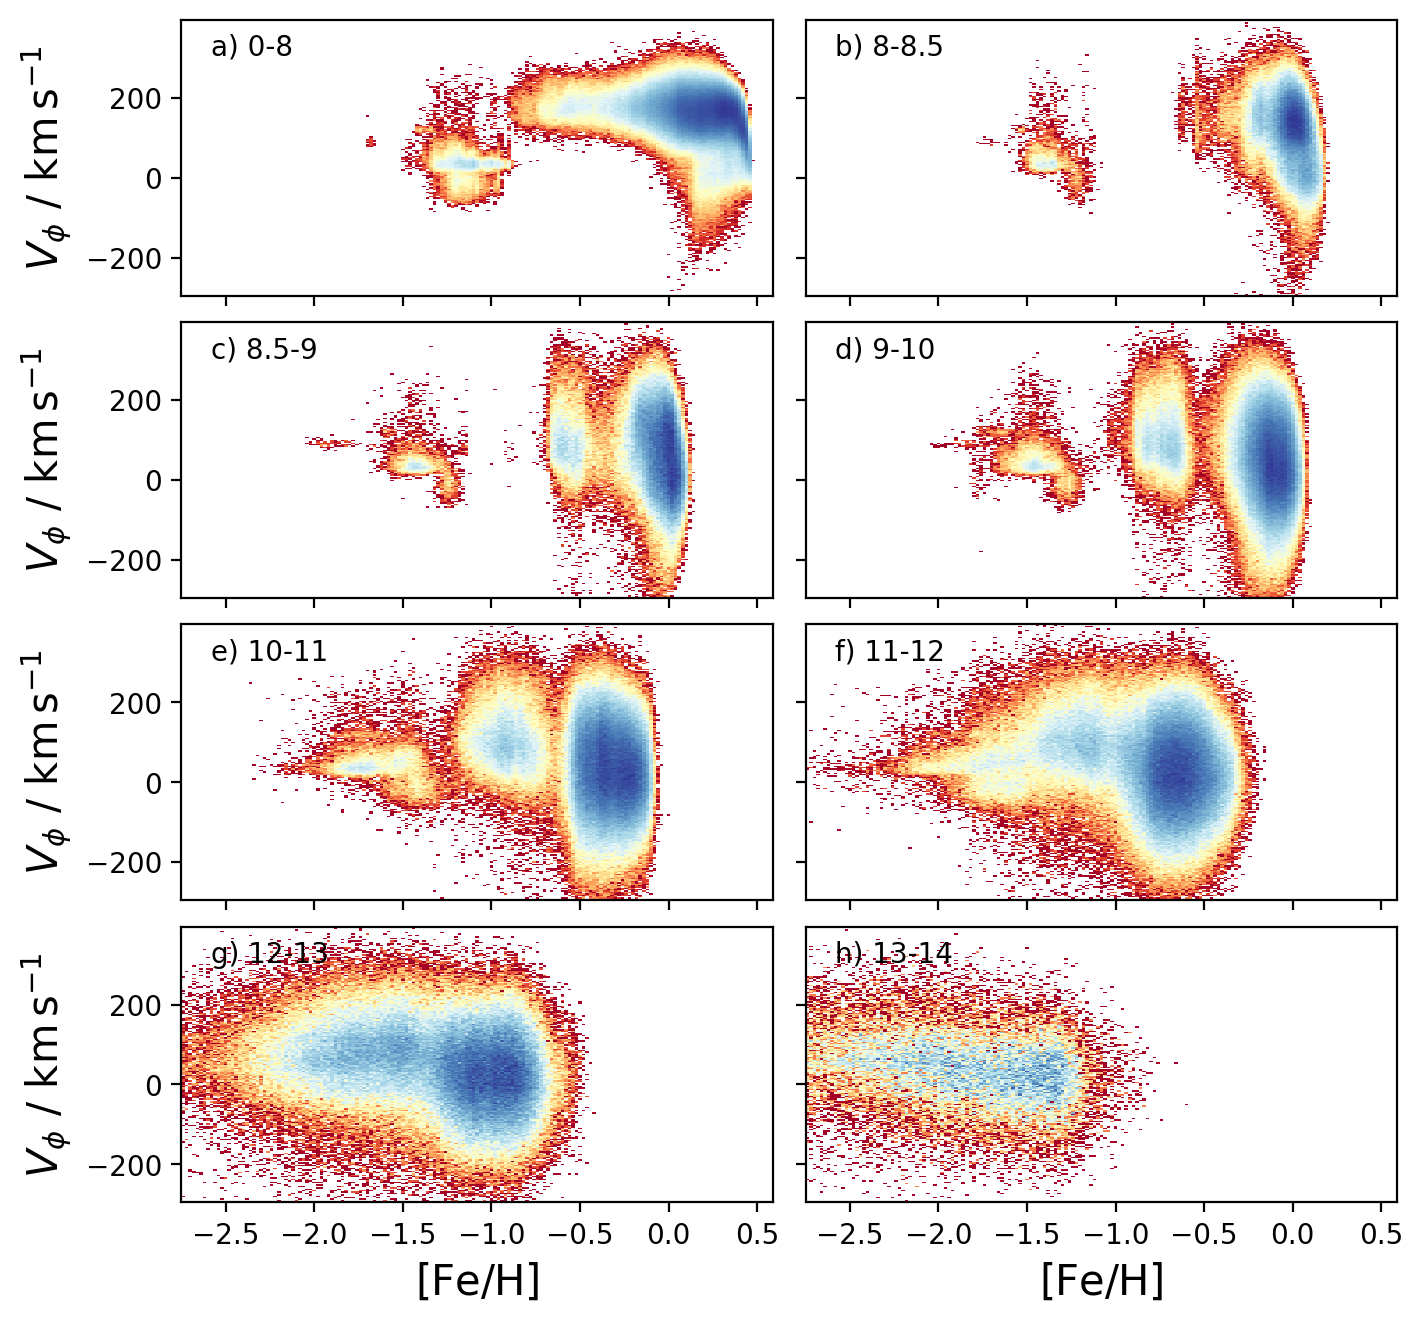

In [18]:
# How Gaussian does the V_phi distribution look like? Is there a hint of something being splashed up?  
age_bins = [0,8,8.5,9,10,11,12,13,14]
feh_vphi_bins = (np.arange(-2.75,0.6,0.02),np.linspace(-295,395,200))

f, gs = plt.subplots(4,2,figsize=(7,6.5),sharex=True,sharey=True,constrained_layout=True)
gs = gs.flatten()

for index, (age_min, age_max) in enumerate(zip(age_bins[:-1],age_bins[1:])):

    ax = gs[index]
    if index % 2 == 0:
        ax.set_ylabel(r'$V_\phi~/~\mathrm{km\,s^{-1}}$',fontsize=15)
    if index >= len(age_bins)-3:
        ax.set_xlabel(r'$\mathrm{[Fe/H]}$',fontsize=15)
    ax.text(0.05,0.95,['a)','b)','c)','d)','e)','f)','g)','h)'][index]+' '+str(age_min)+'-'+str(age_max), transform=ax.transAxes, va='top', ha='left')
    
    ax.hist2d(
        data['Fe_H'][(data['age'] > age_min) & (data['age'] <= age_max)],
        data['vphi'][(data['age'] > age_min) & (data['age'] <= age_max)],
        bins = feh_vphi_bins,
        cmin = 1,
        norm = LogNorm(),
        cmap = 'RdYlBu'
    )

plt.show()

1127.0
R2D birth $R_\mathrm{birth,2D} = 1.79_{-1.15}^{+2.11}\,\mathrm{kpc}$
z birth $Z_\mathrm{birth} = -0.03_{-0.94}^{+0.88}\,\mathrm{kpc}$
1094.0
R2D now   $R_\mathrm{2D} = 1.81_{-1.09}^{+2.43}\,\mathrm{kpc}$
z now   $Z = 0.01_{-0.83}^{+0.83}\,\mathrm{kpc}$


/var/folders/g_/1ch053ys79n87jsnqjz0yr_h0000gq/T/ipykernel_51975/1868294219.py:64: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


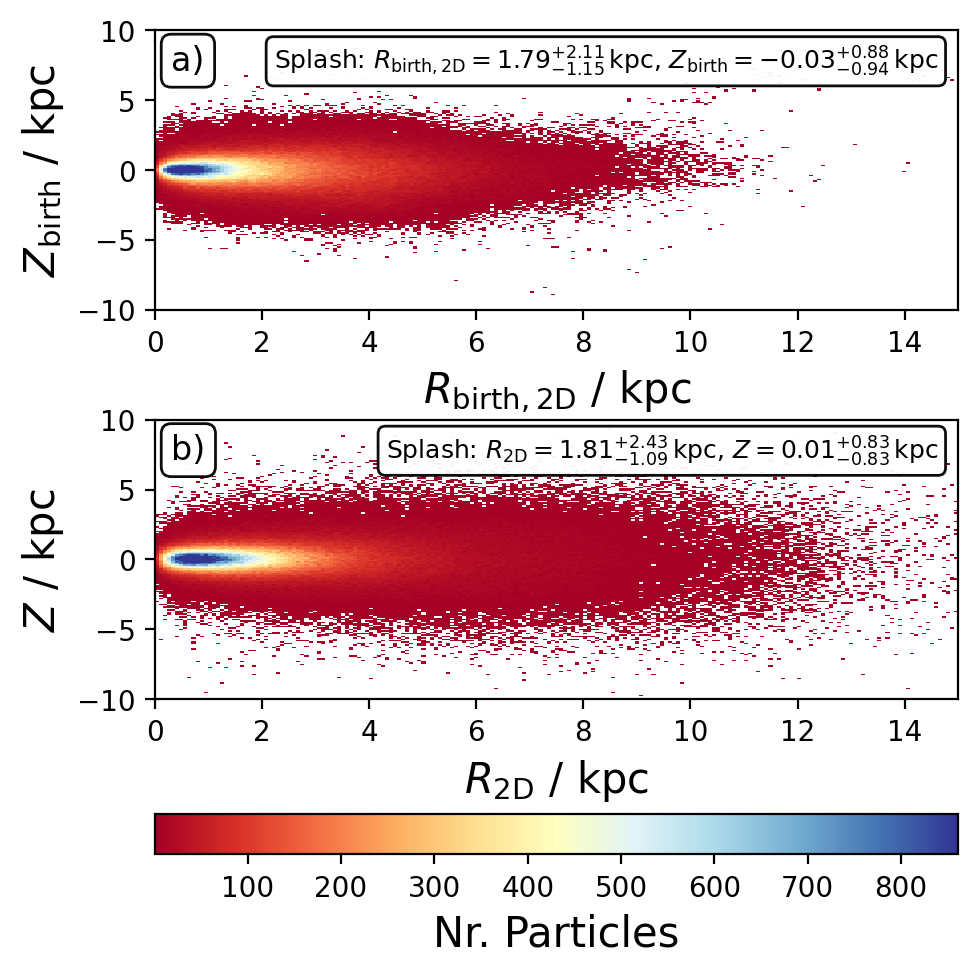

 -> so outer disk (R > 4kpc) maybe splashed, but not so much the inner disk
|z| birth $0.57_{-0.41}^{+0.85}\,\mathrm{kpc}$
|z| now   $0.51_{-0.37}^{+0.86}\,\mathrm{kpc}$
 -> not much change in vertical height since birth. Actually: scatter in |Z| decreased since birth!


In [19]:
# Where the splashed stars already born on these orbits?
f, gs = plt.subplots(2,1,figsize=(5,5.5),constrained_layout=True)

splashed = (data['vphi'] < 75) & (data['Fe_H'] > -0.4) & (data['Fe_H'] < 0.1)

ax = gs[0]
ax.set_xlabel(r'$R_\mathrm{birth,2D}~/~\mathrm{kpc}$',fontsize=15)
ax.set_ylabel(r'$Z_\mathrm{birth}~/~\mathrm{kpc}$',fontsize=15)
p = ax.hist2d(
    data['r_birth_2d'][splashed],
    data['z_birth'][splashed],
    bins = (np.linspace(0,15,200),np.linspace(-10,10,200)),
    cmin = 1,
    cmap = 'RdYlBu',
    vmax = 861
    #norm = LogNorm(vmax = 9801)
)
print(np.nanmax(p[0]))

perc = np.round(np.percentile(data['r_birth_2d'][splashed],q=[16,50,84]),2)
r2d_birth_latex = r'$R_\mathrm{birth,2D} = '+"{:.2f}".format(perc[1])+r'_{-'+"{:.2f}".format(perc[1]-perc[0])+r'}^{+'+"{:.2f}".format(perc[2]-perc[1])+'}'+r'\,\mathrm{kpc}$'
print('R2D birth', r2d_birth_latex)
with open("tex/r2d_birth_latex.tex", "w") as f:
    f.write(r2d_birth_latex+'%')
perc = np.round(np.percentile(data['z_birth'][splashed],q=[16,50,84]),2)
z_birth_latex = r'$Z_\mathrm{birth} = '+"{:.2f}".format(perc[1])+r'_{-'+"{:.2f}".format(perc[1]-perc[0])+r'}^{+'+"{:.2f}".format(perc[2]-perc[1])+'}'+r'\,\mathrm{kpc}$'
with open("tex/z_birth_latex.tex", "w") as f:
    f.write(z_birth_latex+'%')
print('z birth', z_birth_latex)

ax.text(0.02,0.95,r'a)',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
# ax.text(0.975,0.95,r'Splash ($-0.4 < \mathrm{[Fe/H]} < 0.1$, $V_\varphi < 75\,\mathrm{km\,s^{-1}}$)'+'\n'+r2d_birth_latex+r', '+z_birth_latex,fontsize=9,transform=ax.transAxes,va='top',ha='right',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.text(0.975,0.95,r'Splash: '+r2d_birth_latex+r', '+z_birth_latex,fontsize=9,transform=ax.transAxes,va='top',ha='right',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))

ax = gs[1]
ax.set_xlabel(r'$R_\mathrm{2D}~/~\mathrm{kpc}$',fontsize=15)
ax.set_ylabel(r'$Z~/~\mathrm{kpc}$',fontsize=15)
p = ax.hist2d(
    data['r_2d'][splashed],
    data['z'][splashed],
    bins = (np.linspace(0,15,200),np.linspace(-10,10,200)),
    cmin = 1,
    cmap = 'RdYlBu',
    vmax = 861
    #norm = LogNorm(vmax = 9801)
)
print(np.nanmax(p[0]))

perc = np.round(np.percentile(data['r_2d'][splashed],q=[16,50,84]),2)
r2d_latex = r'$R_\mathrm{2D} = '+"{:.2f}".format(perc[1])+r'_{-'+"{:.2f}".format(perc[1]-perc[0])+r'}^{+'+"{:.2f}".format(perc[2]-perc[1])+'}'+r'\,\mathrm{kpc}$'
with open("tex/r2d_latex.tex", "w") as f:
    f.write(r2d_latex+'%')
print('R2D now  ', r2d_latex)
perc = np.round(np.percentile(data['z'][splashed],q=[16,50,84]),2)
z_latex = r'$Z = '+"{:.2f}".format(perc[1])+r'_{-'+"{:.2f}".format(perc[1]-perc[0])+r'}^{+'+"{:.2f}".format(perc[2]-perc[1])+'}'+r'\,\mathrm{kpc}$'
with open("tex/z_latex.tex", "w") as f:
    f.write(z_latex+'%')
print('z now  ', z_latex)

ax.text(0.02,0.95,r'b)',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
# ax.text(0.975,0.95,r'Splash ($-0.4 < \mathrm{[Fe/H]} < 0.1$, $V_\varphi < 75\,\mathrm{km\,s^{-1}}$)'+'\n'+r2d_latex+r', '+z_latex,fontsize=9,transform=ax.transAxes,va='top',ha='right',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.text(0.975,0.95,r'Splash: '+r2d_latex+r', '+z_latex,fontsize=9,transform=ax.transAxes,va='top',ha='right',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))

plt.tight_layout()
cbar = plt.colorbar(p[-1], ax=gs, orientation='horizontal', pad=0.125)
cbar.set_label(r'Nr. Particles',fontsize=15)

plt.savefig('figures/splash_rz_birth_now.png',dpi=200,bbox_inches = 'tight')

plt.show()
plt.close()

print(' -> so outer disk (R > 4kpc) maybe splashed, but not so much the inner disk')
perc = np.round(np.percentile(np.abs(data['z_birth'][splashed]),q=[16,50,84]),2)
perc_latex = r'$'+"{:.2f}".format(perc[1])+r'_{-'+"{:.2f}".format(perc[1]-perc[0])+r'}^{+'+"{:.2f}".format(perc[2]-perc[1])+'}'+r'\,\mathrm{kpc}$'
print('|z| birth', perc_latex)
perc = np.round(np.percentile(np.abs(data['z'][splashed]),q=[16,50,84]),2)
perc_latex = r'$'+"{:.2f}".format(perc[1])+r'_{-'+"{:.2f}".format(perc[1]-perc[0])+r'}^{+'+"{:.2f}".format(perc[2]-perc[1])+'}'+r'\,\mathrm{kpc}$'
print('|z| now  ', perc_latex)
print(' -> not much change in vertical height since birth. Actually: scatter in |Z| decreased since birth!')

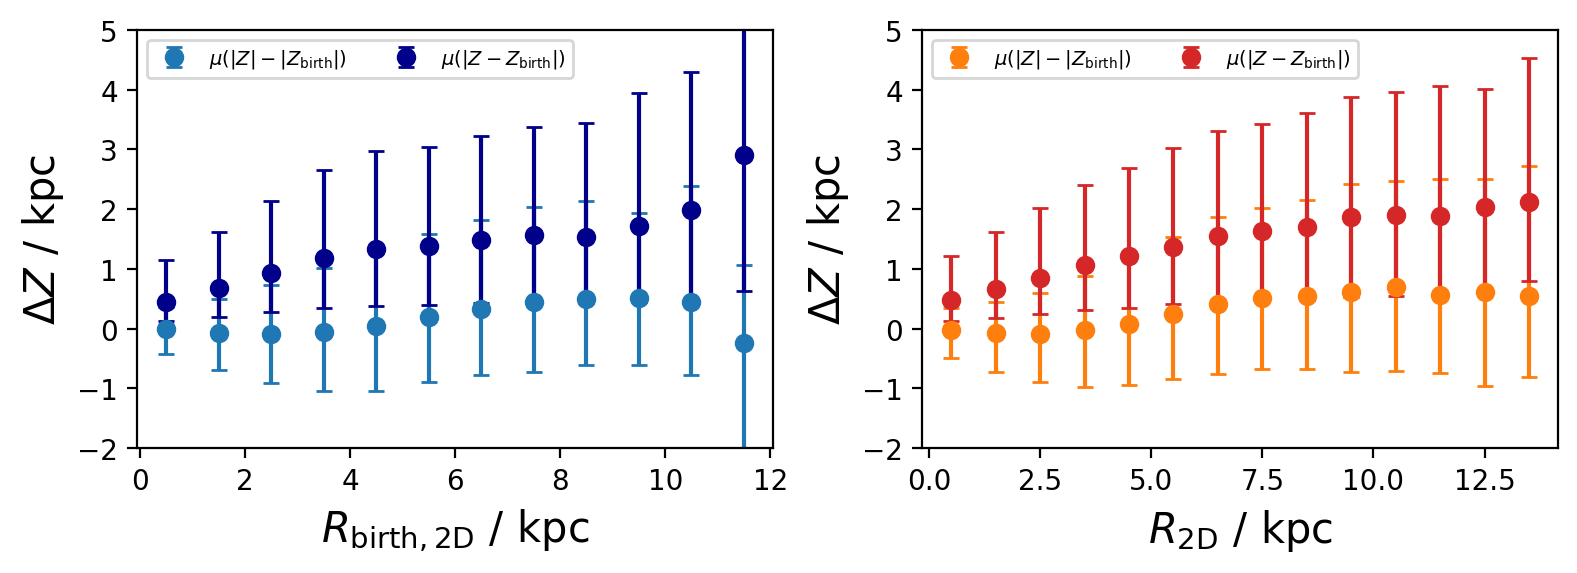

In [20]:
# How does the change in Z look like as a function of R_birth?
f, gs = plt.subplots(1,2,figsize=(8,3))
ax = gs[0]
ax.set_xlabel(r'$R_\mathrm{birth,2D}~/~\mathrm{kpc}$',fontsize=15)
ax.set_ylabel(r'$\Delta Z~/~\mathrm{kpc}$',fontsize=15)  

r_birth_bins = np.arange(0,15,1)

for index in range(len(r_birth_bins)-1):
    label1 = r'$\mu(|Z| - |Z_\mathrm{birth}|)$'
    label2 = r'$\mu(|Z - Z_\mathrm{birth}|)$'
    if index > 0:
        label1 = None
        label2 = None

    in_bin = (data['r_birth_2d'][splashed] >= r_birth_bins[index]) & (data['r_birth_2d'][splashed] < r_birth_bins[index+1])
    if np.sum(in_bin) > 10:
        perc = np.percentile(np.abs(data['z'][splashed][in_bin]) - np.abs(data['z_birth'][splashed][in_bin]),q=[16,50,84])
        perc2 = np.percentile(np.abs(data['z'][splashed][in_bin] - data['z_birth'][splashed][in_bin]),q=[16,50,84])
        ax.errorbar(
            0.5*(r_birth_bins[index]+r_birth_bins[index+1]),
            perc[1],
            yerr = np.array([[perc[1]-perc[0]],[perc[2]-perc[1]]]),
            fmt = 'o',
            color = 'C0',
            label = label1,
            capsize=3
        )
        ax.errorbar(
            0.5*(r_birth_bins[index]+r_birth_bins[index+1]),
            perc2[1],
            yerr = np.array([[perc2[1]-perc2[0]],[perc2[2]-perc2[1]]]),
            fmt = 'o',
            color = 'darkblue',
            label = label2,
            capsize=3
        )
ax.set_ylim(-2,5)
ax.legend(fontsize=7,ncol=2,loc='upper left')

ax = gs[1]
ax.set_xlabel(r'$R_\mathrm{2D}~/~\mathrm{kpc}$',fontsize=15)
ax.set_ylabel(r'$\Delta Z~/~\mathrm{kpc}$',fontsize=15)  

# and for R instead of R_birth
for index in range(len(r_birth_bins)-1):
    label1 = r'$\mu(|Z| - |Z_\mathrm{birth}|)$'
    label2 = r'$\mu(|Z - Z_\mathrm{birth}|)$'
    if index > 0:
        label1 = None
        label2 = None
    in_bin = (data['r_2d'][splashed] >= r_birth_bins[index]) & (data['r_2d'][splashed] < r_birth_bins[index+1])
    if np.sum(in_bin) > 10:
        perc = np.percentile(np.abs(data['z'][splashed][in_bin]) - np.abs(data['z_birth'][splashed][in_bin]),q=[16,50,84])
        perc2 = np.percentile(np.abs(data['z'][splashed][in_bin] - data['z_birth'][splashed][in_bin]),q=[16,50,84])
        ax.errorbar(
            0.5*(r_birth_bins[index]+r_birth_bins[index+1]),
            perc[1],
            yerr = np.array([[perc[1]-perc[0]],[perc[2]-perc[1]]]),
            fmt = 'o',
            color = 'C1',
            label = label1,
            capsize=3
        )
        ax.errorbar(
            0.5*(r_birth_bins[index]+r_birth_bins[index+1]),
            perc2[1],
            yerr = np.array([[perc2[1]-perc2[0]],[perc2[2]-perc2[1]]]),
            fmt = 'o',
            color = 'C3',
            label = label2,
            capsize=3
        )
ax.set_ylim(-2,5)
ax.legend(fontsize=7,ncol=2,loc='upper left')
plt.tight_layout()
plt.savefig('figures/splash_delta_z_vs_rbirth_rnow.png',dpi=200,bbox_inches = 'tight')
plt.show()

/var/folders/g_/1ch053ys79n87jsnqjz0yr_h0000gq/T/ipykernel_51975/3377672384.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=7,ncol=2,loc='upper left')
/var/folders/g_/1ch053ys79n87jsnqjz0yr_h0000gq/T/ipykernel_51975/3377672384.py:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=7,ncol=2,loc='upper left')


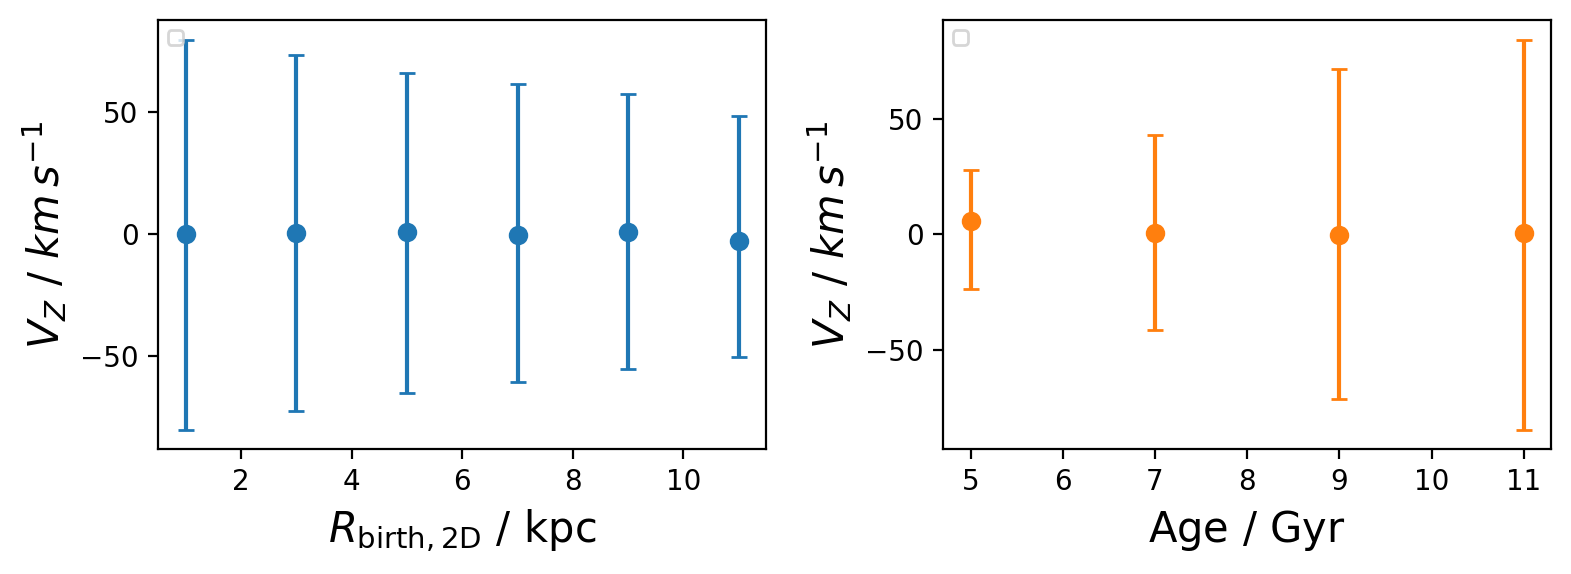

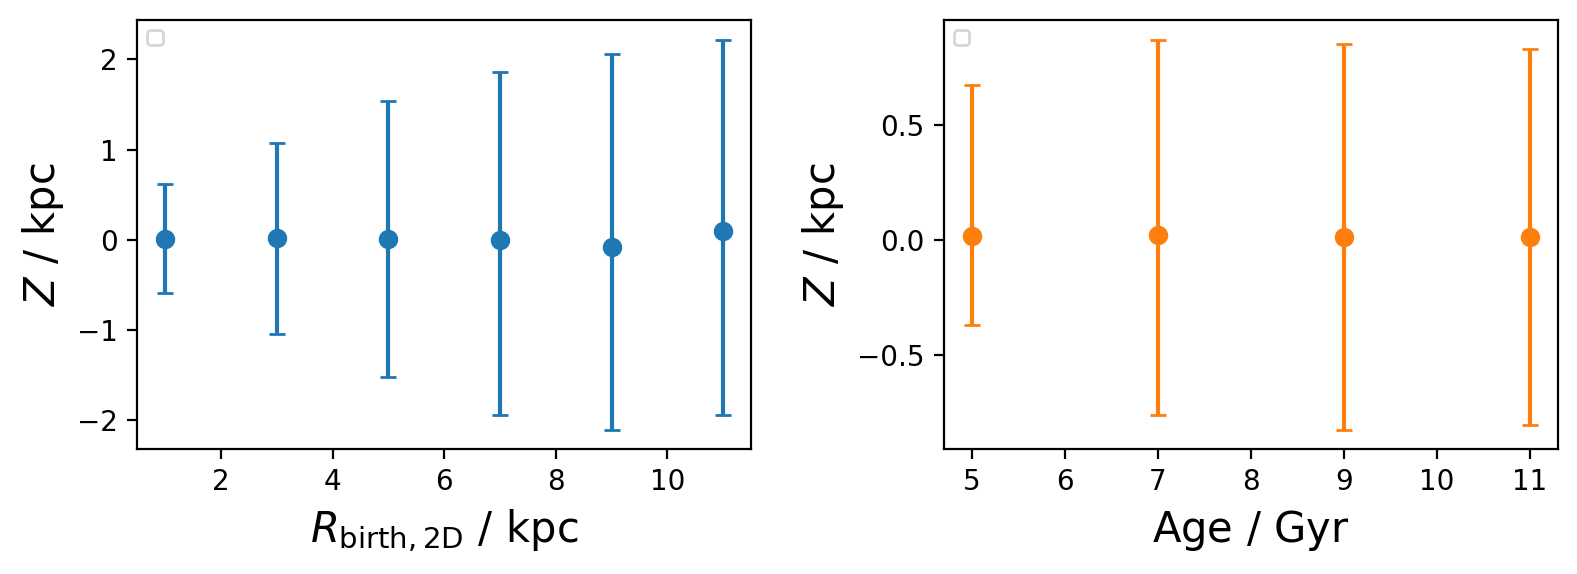

In [21]:
for label, property in zip(
    [r'$V_Z~/~\mathrm{}{km\,s^{-1}}$',r'$Z~/~\mathrm{kpc}$'],
    ['vz','z']
):

    f, gs = plt.subplots(1,2,figsize=(8,3))
    
    ax = gs[0]
    ax.set_xlabel(r'$R_\mathrm{birth,2D}~/~\mathrm{kpc}$',fontsize=15)
    ax.set_ylabel(label,fontsize=15)
    r_birth_bins = np.arange(0,15,2)

    for index in range(len(r_birth_bins)-1):
        in_bin = (data['r_birth_2d'][splashed] >= r_birth_bins[index]) & (data['r_birth_2d'][splashed] < r_birth_bins[index+1])
        if np.sum(in_bin) > 10:
            perc = np.percentile(data[property][splashed][in_bin],q=[16,50,84])
            ax.errorbar(
                0.5*(r_birth_bins[index]+r_birth_bins[index+1]),
                perc[1],
                yerr = np.array([[perc[1]-perc[0]],[perc[2]-perc[1]]]),
                fmt = 'o',
                color = 'C0',
                label = label1,
                capsize=3
            )
    ax.legend(fontsize=7,ncol=2,loc='upper left')

    ax = gs[1]
    ax.set_xlabel(r'$\mathrm{Age}~/~\mathrm{Gyr}$',fontsize=15)
    ax.set_ylabel(label,fontsize=15)

    age_bins = np.arange(0,15,2)

    # and for R instead of R_birth
    for index in range(len(age_bins)-1):
        in_bin = (data['age'][splashed] >= age_bins[index]) & (data['age'][splashed] < age_bins[index+1])
        if np.sum(in_bin) > 10:
            perc = np.percentile(data[property][splashed][in_bin],q=[16,50,84])
            ax.errorbar(
                0.5*(age_bins[index]+age_bins[index+1]),
                perc[1],
                yerr = np.array([[perc[1]-perc[0]],[perc[2]-perc[1]]]),
                fmt = 'o',
                color = 'C1',
                label = label1,
                capsize=3
            )
    ax.legend(fontsize=7,ncol=2,loc='upper left')
    plt.tight_layout()
    plt.show()

In [22]:
r2d_change = np.percentile(data['r_2d'][splashed] - data['r_birth_2d'][splashed],q=[16,50,84])
r2d_change = r'$\overline{\Delta R_\mathrm{2D}} = \overline{R_\mathrm{2D} - R_\mathrm{2D,birth}} = '+"{:.1f}".format(r2d_change[1])+'_{-'+"{:.1f}".format(r2d_change[1]-r2d_change[0])+'}^{+'+"{:.1f}".format(r2d_change[2]-r2d_change[1])+r'}\,\mathrm{kpc}$'
z_change = np.percentile(np.abs(data['z'][splashed]) - np.abs(data['z_birth'][splashed]),q=[16,50,84])
z_change = r'$\overline{\Delta |Z|} = \overline{|Z| - |Z_\mathrm{birth}|} = '+"{:.2f}".format(z_change[1])+'_{-'+"{:.2f}".format(z_change[1]-z_change[0])+'}^{+'+"{:.2f}".format(z_change[2]-z_change[1])+r'}\,\mathrm{kpc}$'
with open("tex/splash_r2d_change.tex", "w") as f:
    f.write(r2d_change+'%')
with open("tex/splash_z_change.tex", "w") as f:
    f.write(z_change+'%')

print(' -> Splash median change in R2D: '+r2d_change)
print(' -> Splash median change in |Z|: '+z_change)

 -> Splash median change in R2D: $\overline{\Delta R_\mathrm{2D}} = \overline{R_\mathrm{2D} - R_\mathrm{2D,birth}} = 0.1_{-1.1}^{+1.2}\,\mathrm{kpc}$
 -> Splash median change in |Z|: $\overline{\Delta |Z|} = \overline{|Z| - |Z_\mathrm{birth}|} = -0.03_{-0.70}^{+0.68}\,\mathrm{kpc}$


In [23]:
# and the change of the stars with higher Vphi than the splash?

above_splashed = (data['vphi'] > 75) & (data['Fe_H'] > -0.4) & (data['Fe_H'] < 0.1)

r2d_change = np.percentile(data['r_2d'][above_splashed] - data['r_birth_2d'][above_splashed],q=[16,50,84])
r2d_change = r'$\overline{\Delta R_\mathrm{2D}} = \overline{R_\mathrm{2D} - R_\mathrm{2D,birth}} = '+"{:.1f}".format(r2d_change[1])+'_{-'+"{:.1f}".format(r2d_change[1]-r2d_change[0])+'}^{+'+"{:.1f}".format(r2d_change[2]-r2d_change[1])+r'}\,\mathrm{kpc}$'
z_change = np.percentile(np.abs(data['z'][above_splashed]) - np.abs(data['z_birth'][above_splashed]),q=[16,50,84])
z_change = r'$\overline{\Delta |Z|} = \overline{|Z| - |Z_\mathrm{birth}|} = '+"{:.2f}".format(z_change[1])+'_{-'+"{:.2f}".format(z_change[1]-z_change[0])+'}^{+'+"{:.2f}".format(z_change[2]-z_change[1])+r'}\,\mathrm{kpc}$'
print(' -> Above Splash median change in R2D: '+r2d_change)
print(' -> Above Splash median change in |Z|: '+z_change)


 -> Above Splash median change in R2D: $\overline{\Delta R_\mathrm{2D}} = \overline{R_\mathrm{2D} - R_\mathrm{2D,birth}} = 0.1_{-1.7}^{+2.6}\,\mathrm{kpc}$
 -> Above Splash median change in |Z|: $\overline{\Delta |Z|} = \overline{|Z| - |Z_\mathrm{birth}|} = 0.10_{-0.59}^{+0.76}\,\mathrm{kpc}$


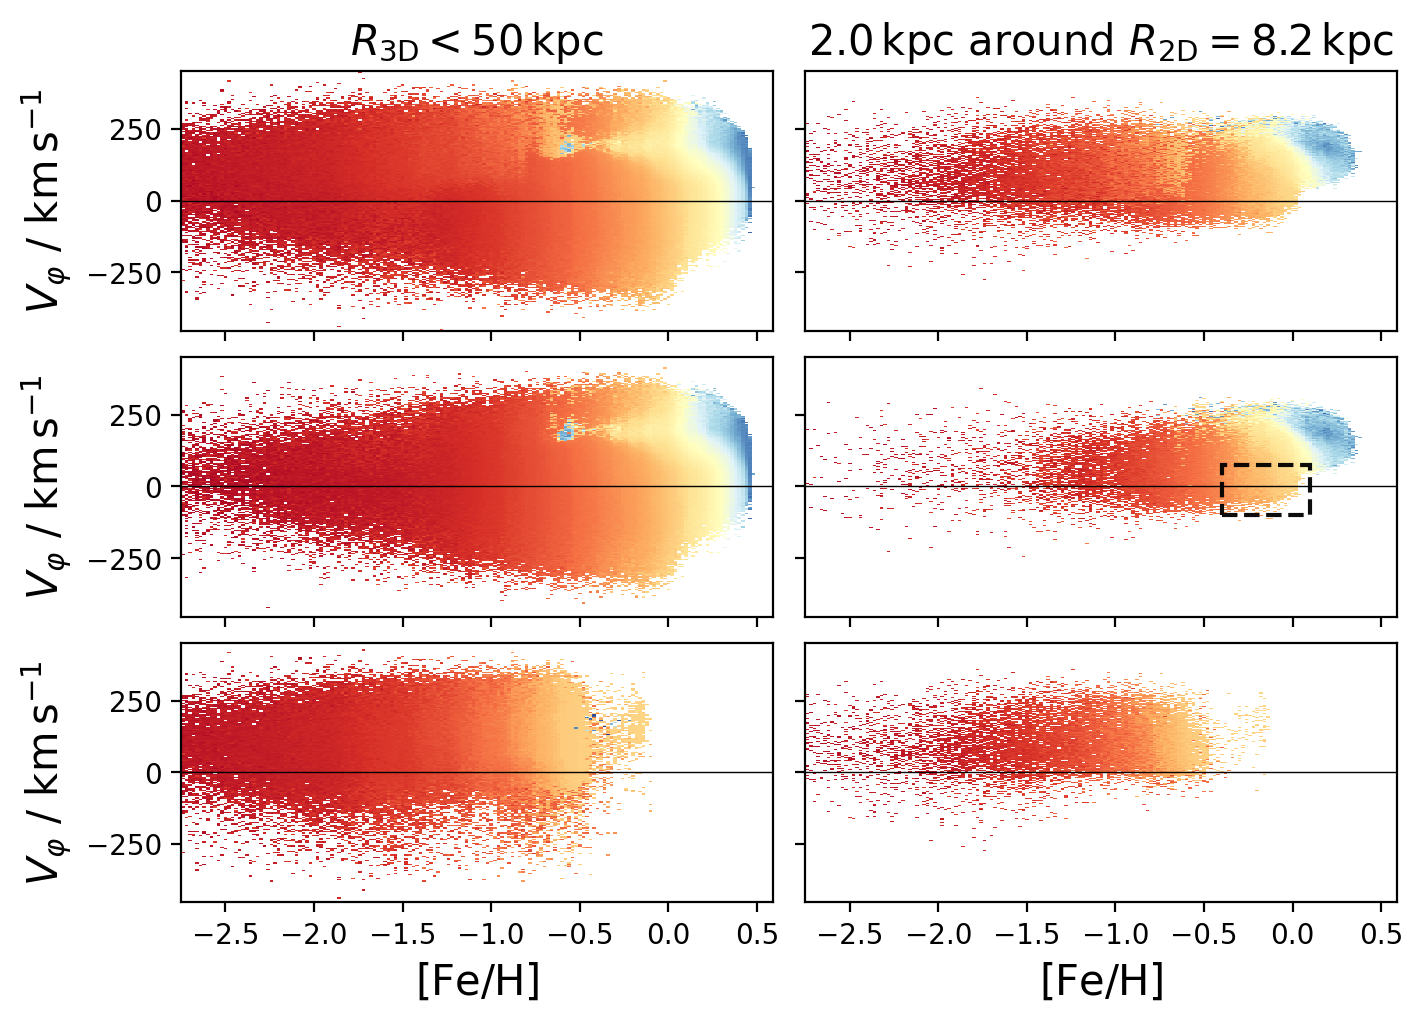

In [24]:
# Age distribution of stars 

f, gs = plt.subplots(3,2,figsize=(7,5),sharex=True,sharey=True,constrained_layout=True)

feh_vphi_bins = (np.arange(-2.75,0.6,0.02),200)

for index, selection in enumerate([within_50kpc, within_50kpc_born_within_50kpc, within_50kpc_born_outside_50kpc]):
    ax = gs[index,0]
    stats, x_edge, y_edge, _ = binned_statistic_2d(
        data['Fe_H'][selection],
        data['vphi'][selection],
        data['age'][selection],
        bins = feh_vphi_bins,
        statistic='median'
    )
    stats[stats == 0] = np.nan
    pcm = ax.pcolormesh(x_edge, y_edge, stats.T, shading='auto', vmin = 0, vmax = 13.8, cmap='RdYlBu_r', zorder=1)
    ax.set_ylabel(r'$V_\varphi~/~\mathrm{km\,s^{-1}}$',fontsize=15)
    if index == 2:
        ax.set_xlabel(r'$\mathrm{[Fe/H]}$',fontsize=15)
    ax.axhline(0,lw=0.5,color='k')

    ax = gs[index,1]
    stats, x_edge, y_edge, _ = binned_statistic_2d(
        data['Fe_H'][selection & galah_like],
        data['vphi'][selection & galah_like],
        data['age'][selection & galah_like],
        bins = feh_vphi_bins,
        statistic='median'
    )
    stats[stats == 0] = np.nan
    pcm = ax.pcolormesh(x_edge, y_edge, stats.T, shading='auto', vmin = 0, vmax = 13.8, cmap='RdYlBu_r', zorder=1)
    if index == 2:
        ax.set_xlabel(r'$\mathrm{[Fe/H]}$',fontsize=15)

    if index == 1:
        rectangle = Rectangle((-0.4,-100),0.5,175,facecolor='None',alpha=0.95,linewidth=1.5,edgecolor='k',ls='dashed')
        ax.add_artist(rectangle)
        
    ax.axhline(0,lw=0.5,color='k')
        
gs[0,0].set_title(r'$R_\mathrm{3D} < 50\,\mathrm{kpc}$',fontsize=15)
gs[0,1].set_title(r'$'+str(galah_radius)+r'\,\mathrm{kpc}$ around $R_\mathrm{2D} = '+str(solar_radius)+r'\,\mathrm{kpc}$',fontsize=15)
plt.savefig('figures/splash_feh_vphi_age.png',dpi=200,bbox_inches='tight')
plt.show()

877.0
0 [ 2.5  6.6 64.6]
471.0
1 [3.9 6.3 8.9]
264.0
2 [ 3.5  7.4 12.5]
63.0
3 [2.2 4.6 7.8]
69.0
4 [1.  2.9 9.6]
63.0
5 [  8.4  66.5 151.9]


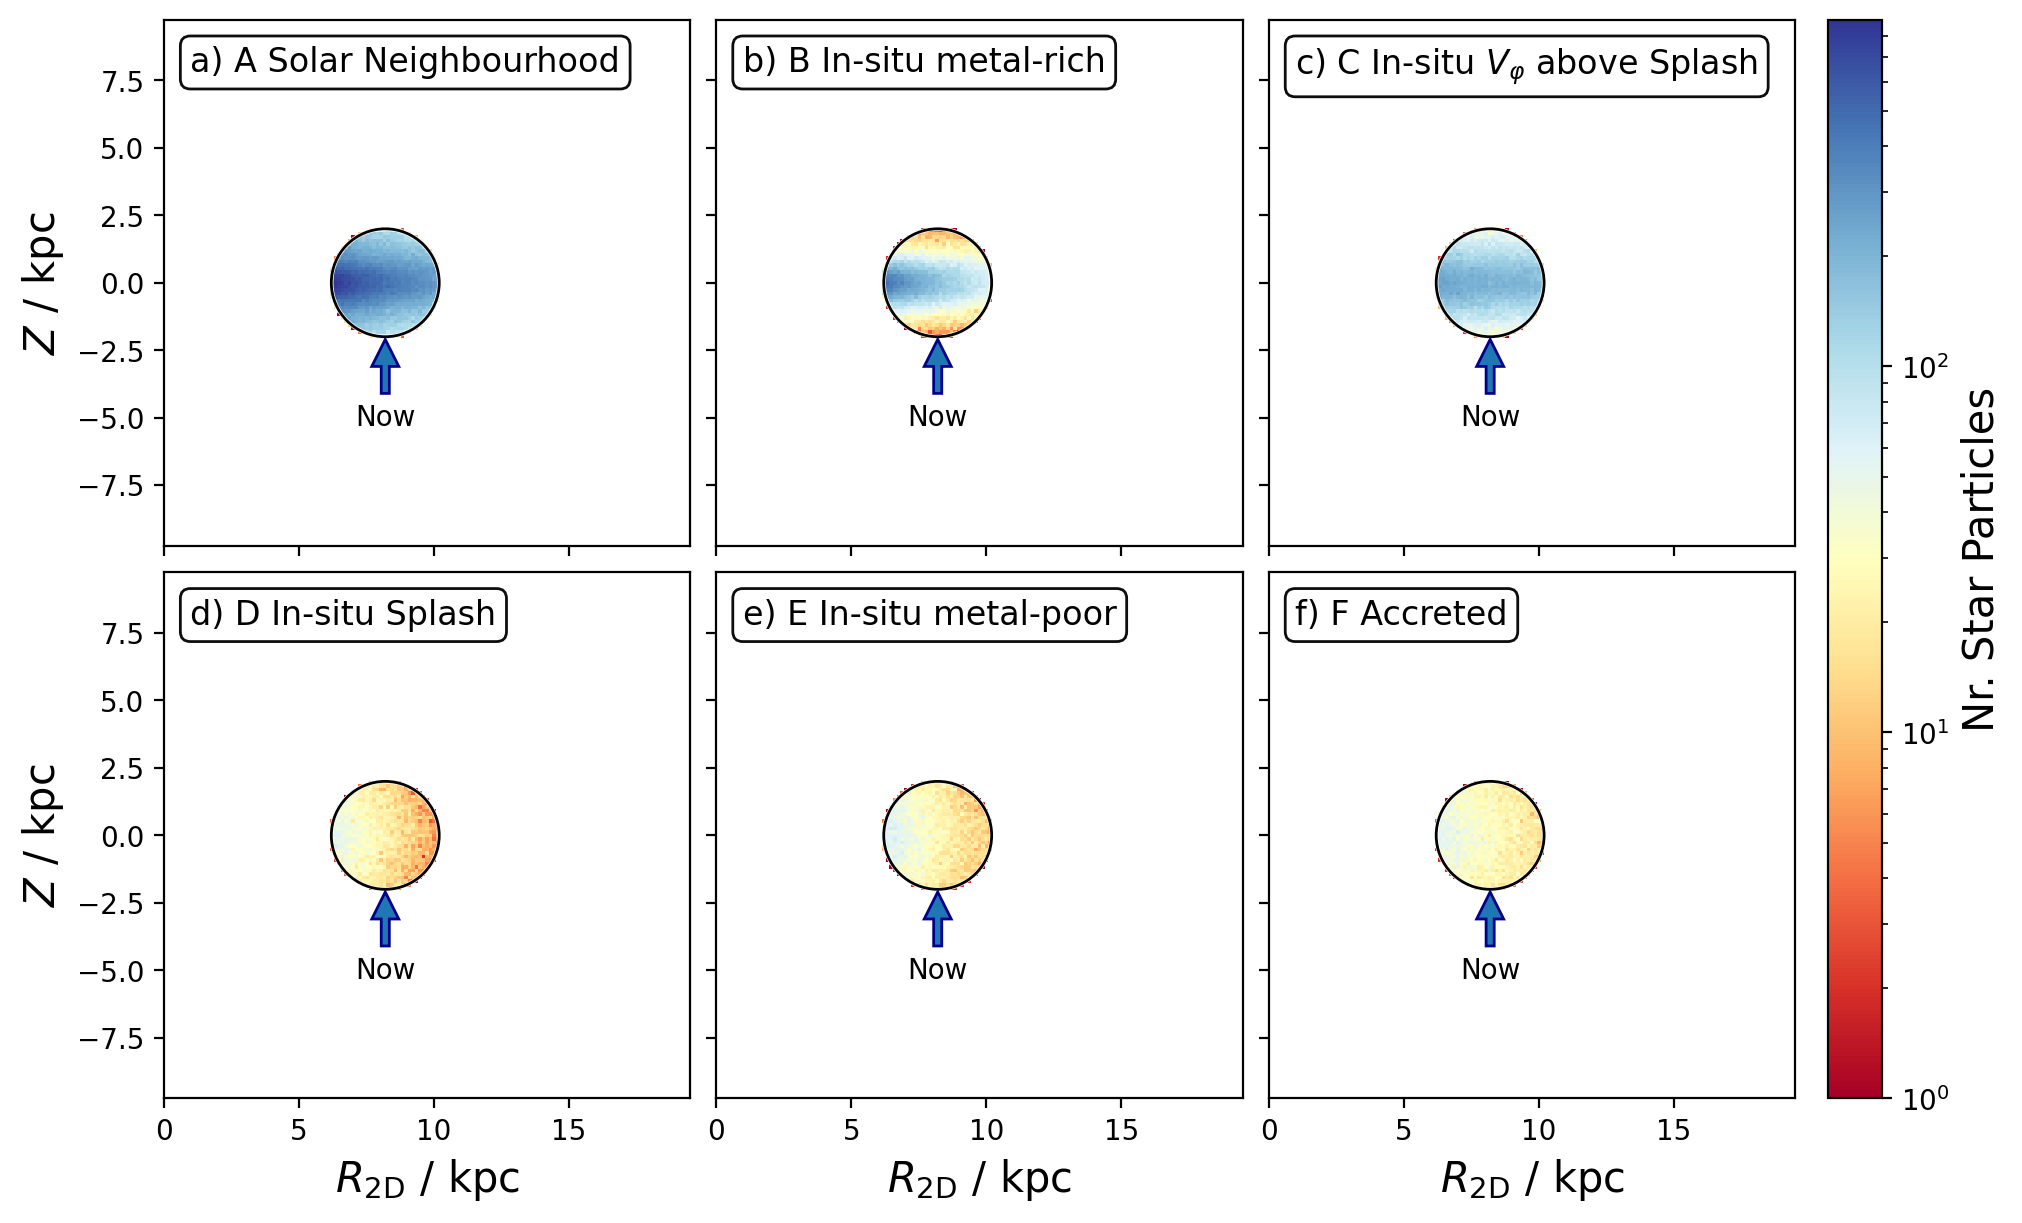

In [25]:
# Different selections of splash and surrounding areas: 

selections_and_names = [
    ['A Solar Neighbourhood',
         galah_like
    ],
    ['B In-situ metal-rich', (
        within_50kpc_born_within_50kpc & galah_like &
        (data['Fe_H'] > 0.1)
    )],
    [r'C In-situ $V_\varphi$ above Splash', (
        within_50kpc_born_within_50kpc & galah_like &
        (data['Fe_H'] > -0.4) & (data['Fe_H'] < 0.1) &
        (data['vphi'] > 75)
    )],
    ['D In-situ Splash', (
        within_50kpc_born_within_50kpc & galah_like &
        (data['Fe_H'] > -0.4) & (data['Fe_H'] < 0.1) &
        (data['vphi'] > -100) & (data['vphi'] < 75)
    )],
    ['E In-situ metal-poor', (
        within_50kpc_born_within_50kpc & galah_like &
        (data['Fe_H'] < -0.4)
    )],
    ['F Accreted', (
        within_50kpc_born_outside_50kpc & galah_like
    )]
]

f, gs = plt.subplots(2,3,figsize=(10,6),sharex=True,sharey=True,constrained_layout=True)
gs = gs.flatten()

vmax = 886
rz_bins = (np.linspace(0,19.5,150),np.linspace(-9.75,9.75,150))

for index, (selection_name, selection) in enumerate(selections_and_names):
    
    ax = gs[index]
#     ax.set_aspect('equal')
    ax.text(0.05,0.95,panels[index]+' '+selection_name,fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
    # p1 = ax.hist2d(
    #     data['r_birth_2d'][selection],
    #     data['z_birth'][selection],
    #     bins = rz_bins,
    #     norm = LogNorm(vmin=1,vmax = vmax),
    #     cmap = 'RdYlBu'
    # )
    p2 = ax.hist2d(
        data['r_2d'][selection],
        data['z'][selection],
        bins = rz_bins,
        norm = LogNorm(vmin=1,vmax = vmax),
        cmap = 'RdYlBu'
    )
    # print(np.max(p1[0]),np.max(p2[0]))
    print(np.max(p2[0]))

    print(index, np.round(np.percentile(data['r_birth_2d'][selection],q=[5,50,95]),1))
    
    circle = Circle((solar_radius,0),galah_radius,lw=1.5,edgecolor='w',facecolor='None')
    ax.add_artist(circle)
    circle = Circle((solar_radius,0),galah_radius,lw=1,edgecolor='k',facecolor='None')
    ax.add_artist(circle)
    # circle = Circle((solar_radius,-5),galah_radius,lw=1.5,edgecolor='w',facecolor='None')
    # ax.add_artist(circle)
    # circle = Circle((solar_radius,-5),galah_radius,lw=1,edgecolor='k',facecolor='None')
    # ax.add_artist(circle)
    if index >= 3:
        ax.set_xlabel(r'$R_\mathrm{2D}~/~\mathrm{kpc}$',fontsize=15)
    if index in [0,3]:
        ax.set_ylabel(r'$Z~/~\mathrm{kpc}$',fontsize=15)
    rect = Rectangle((11,-6),8,3,alpha=1,facecolor='w')
    ax.add_artist(rect)
    ax.text(8.2,-5,r'Now',fontsize=10,va='center',ha='center')
    ax.arrow(8.2, -4.1, 0, 1, width = 0.3, head_width=1, head_length=1, fc='C0', ec='darkblue',zorder=5)
    
cbar = plt.colorbar(p2[-1], ax=gs, location='right', pad=0.02)
cbar.set_label('Nr. Star Particles',fontsize=15)
plt.savefig('figures/splash_rbirth_zbirth_now.png',dpi=200,bbox_inches='tight')
plt.show()

750.0 63.0
A Solar Neighbourhood [ 2.5  6.6 64.6]
519.0 63.0
B In-situ metal-rich [3.9 6.3 8.9]
264.0 63.0
C In-situ $V_\varphi$ above Splash [ 3.5  7.4 12.5]
35.0 63.0
D In-situ Splash [2.2 4.6 7.8]
29.0 63.0
E In-situ metal-poor [1.  2.9 9.6]
6.0 63.0
F Accreted [  8.4  66.5 151.9]


/var/folders/g_/1ch053ys79n87jsnqjz0yr_h0000gq/T/ipykernel_51975/4113689169.py:65: UserWarning: Adding colorbar to a different Figure <Figure size 1000x600 with 7 Axes> than <Figure size 1000x600 with 7 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(p2[-1], ax=gs, location='right', pad=0.02)


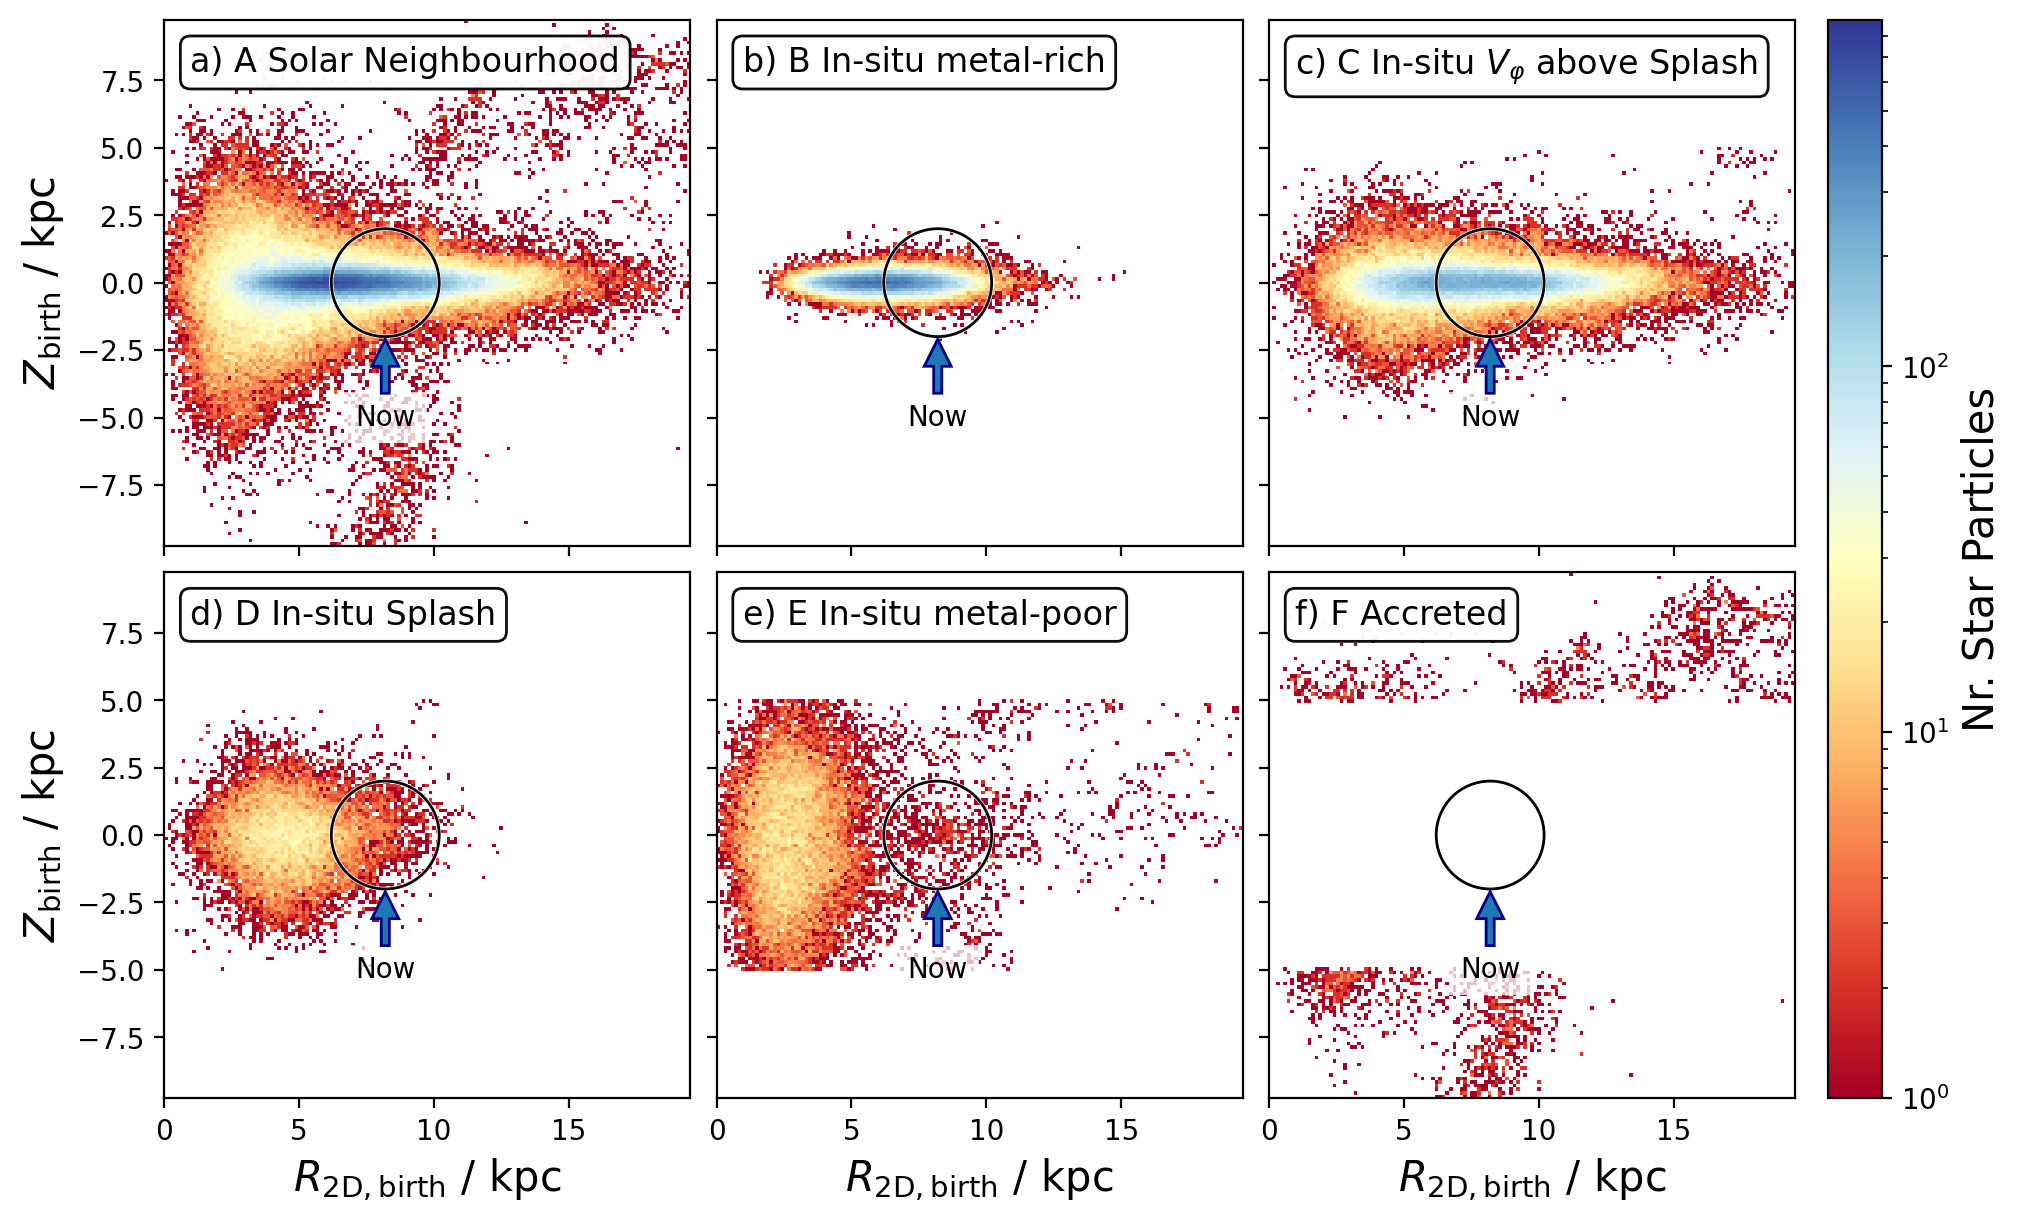

In [26]:
# Different selections of splash and surrounding areas: 

selections_and_names = [
    ['A Solar Neighbourhood',
         galah_like
    ],
    ['B In-situ metal-rich', (
        within_50kpc_born_within_50kpc & galah_like &
        (data['Fe_H'] > 0.1)
    )],
    [r'C In-situ $V_\varphi$ above Splash', (
        within_50kpc_born_within_50kpc & galah_like &
        (data['Fe_H'] > -0.4) & (data['Fe_H'] < 0.1) &
        (data['vphi'] > 75)
    )],
    ['D In-situ Splash', (
        within_50kpc_born_within_50kpc & galah_like &
        (data['Fe_H'] > -0.4) & (data['Fe_H'] < 0.1) &
        (data['vphi'] > -100) & (data['vphi'] < 75)
    )],
    ['E In-situ metal-poor', (
        within_50kpc_born_within_50kpc & galah_like &
        (data['Fe_H'] < -0.4)
    )],
    ['F Accreted', (
        within_50kpc_born_outside_50kpc & galah_like
    )]
]

f, gs = plt.subplots(2,3,figsize=(10,6),sharex=True,sharey=True,constrained_layout=True)
gs = gs.flatten()

vmax = 886
rz_bins = (np.linspace(0,19.5,150),np.linspace(-9.75,9.75,150))

for index, (selection_name, selection) in enumerate(selections_and_names):
    
    ax = gs[index]
#     ax.set_aspect('equal')
    ax.text(0.05,0.95,panels[index]+' '+selection_name,fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
    p1 = ax.hist2d(
        data['r_birth_2d'][selection],
        data['z_birth'][selection],
        bins = rz_bins,
        norm = LogNorm(vmin=1,vmax = vmax),
        cmap = 'RdYlBu'
    )
    print(np.max(p1[0]),np.max(p2[0]))

    print(selections_and_names[index][0], np.round(np.percentile(data['r_birth_2d'][selection],q=[5,50,95]),1))
    
    circle = Circle((solar_radius,0),galah_radius,lw=1.5,edgecolor='w',facecolor='None')
    ax.add_artist(circle)
    circle = Circle((solar_radius,0),galah_radius,lw=1,edgecolor='k',facecolor='None')
    ax.add_artist(circle)
    if index >= 3:
        ax.set_xlabel(r'$R_\mathrm{2D,birth}~/~\mathrm{kpc}$',fontsize=15)
    if index in [0,3]:
        ax.set_ylabel(r'$Z_\mathrm{birth}~/~\mathrm{kpc}$',fontsize=15)
    rect = Rectangle((11,-6),8,3,alpha=1,facecolor='w')
    ax.add_artist(rect)
    ax.text(8.2,-5,r'Now',fontsize=10,va='center',ha='center',bbox=dict(facecolor='w', alpha=0.75,lw=0))
    ax.arrow(8.2, -4.1, 0, 1, width = 0.3, head_width=1, head_length=1, fc='C0', ec='darkblue',zorder=5)
    
cbar = plt.colorbar(p2[-1], ax=gs, location='right', pad=0.02)
cbar.set_label('Nr. Star Particles',fontsize=15)
plt.savefig('figures/splash_rbirth_zbirth.png',dpi=200,bbox_inches='tight')
plt.show()

/var/folders/g_/1ch053ys79n87jsnqjz0yr_h0000gq/T/ipykernel_51975/2230681880.py:18: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


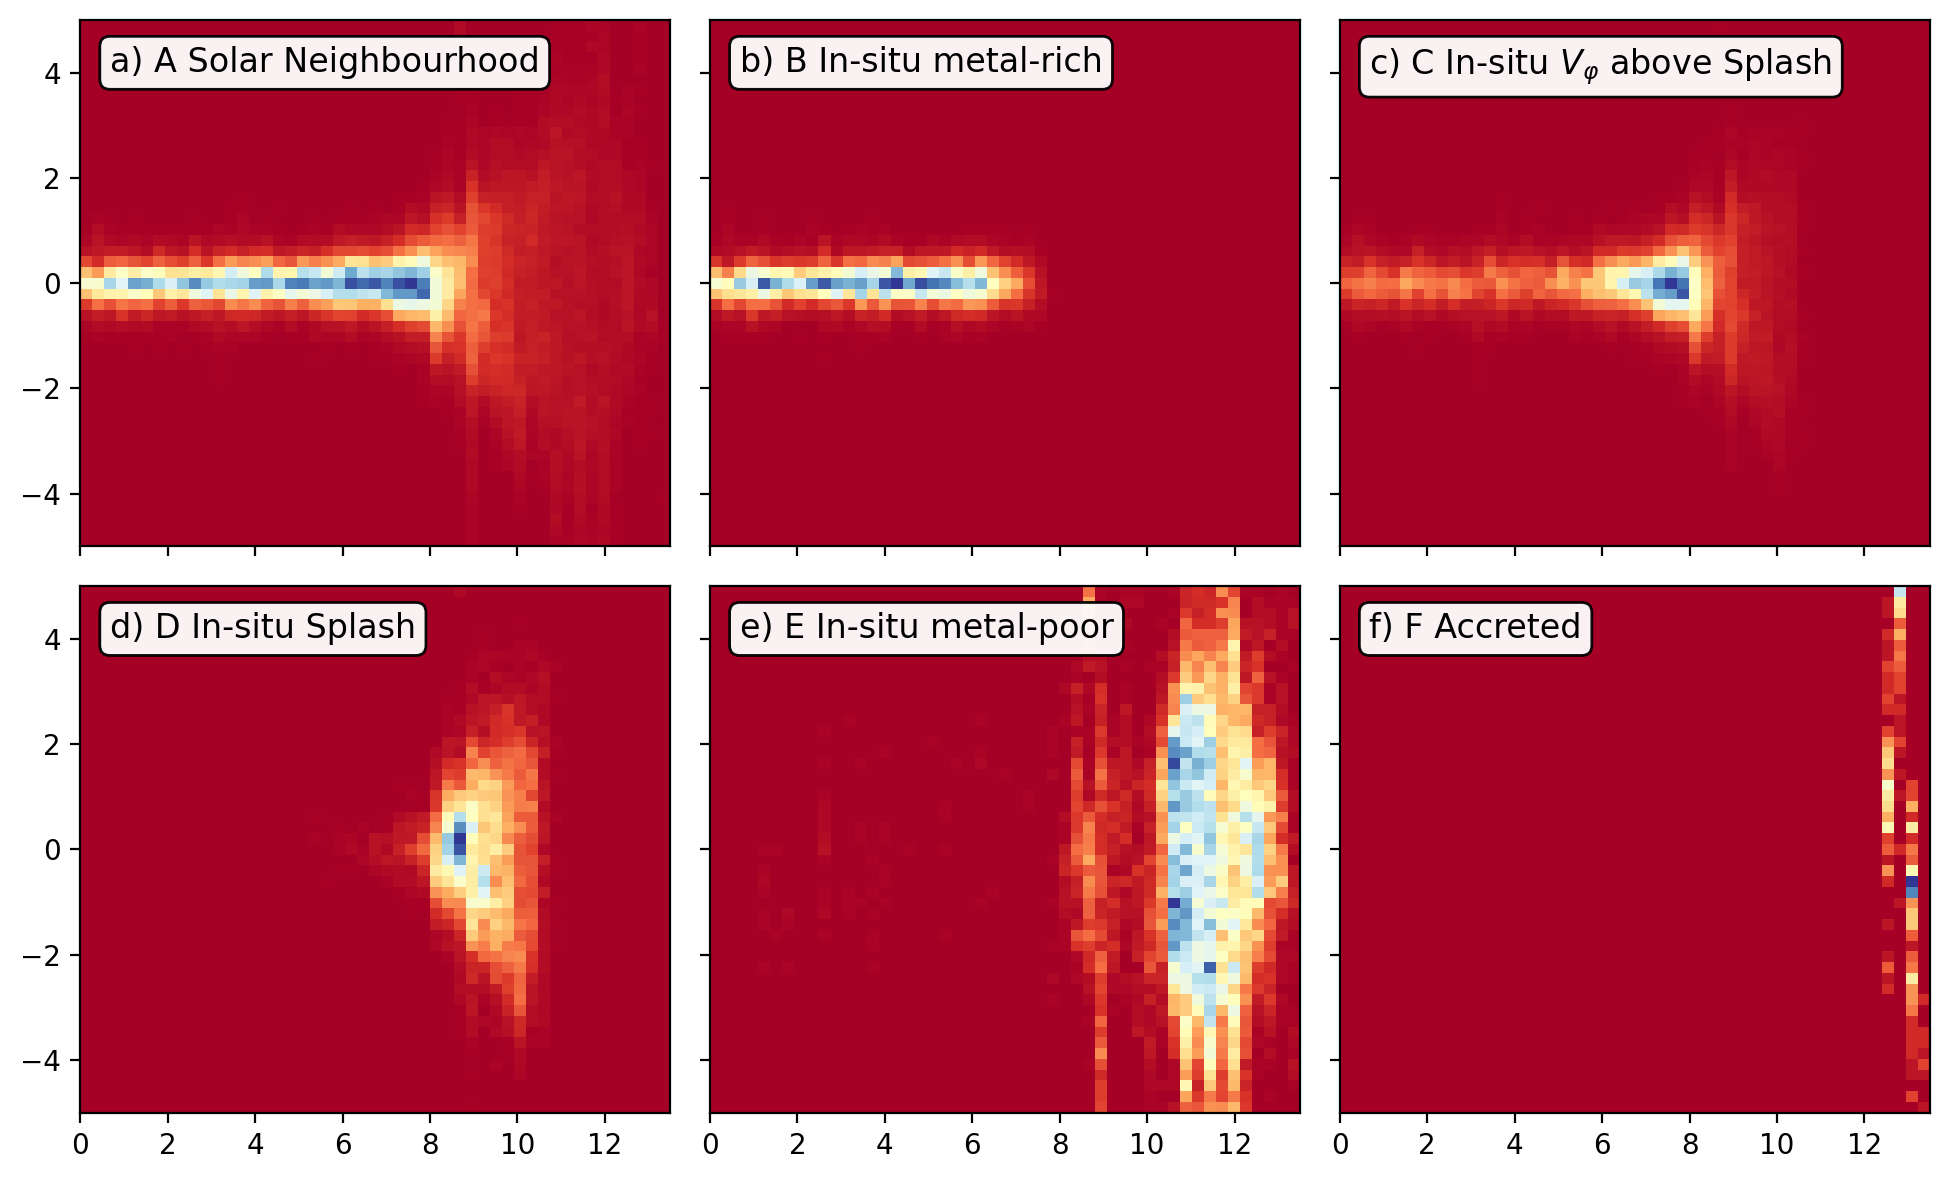

/var/folders/g_/1ch053ys79n87jsnqjz0yr_h0000gq/T/ipykernel_51975/2230681880.py:37: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


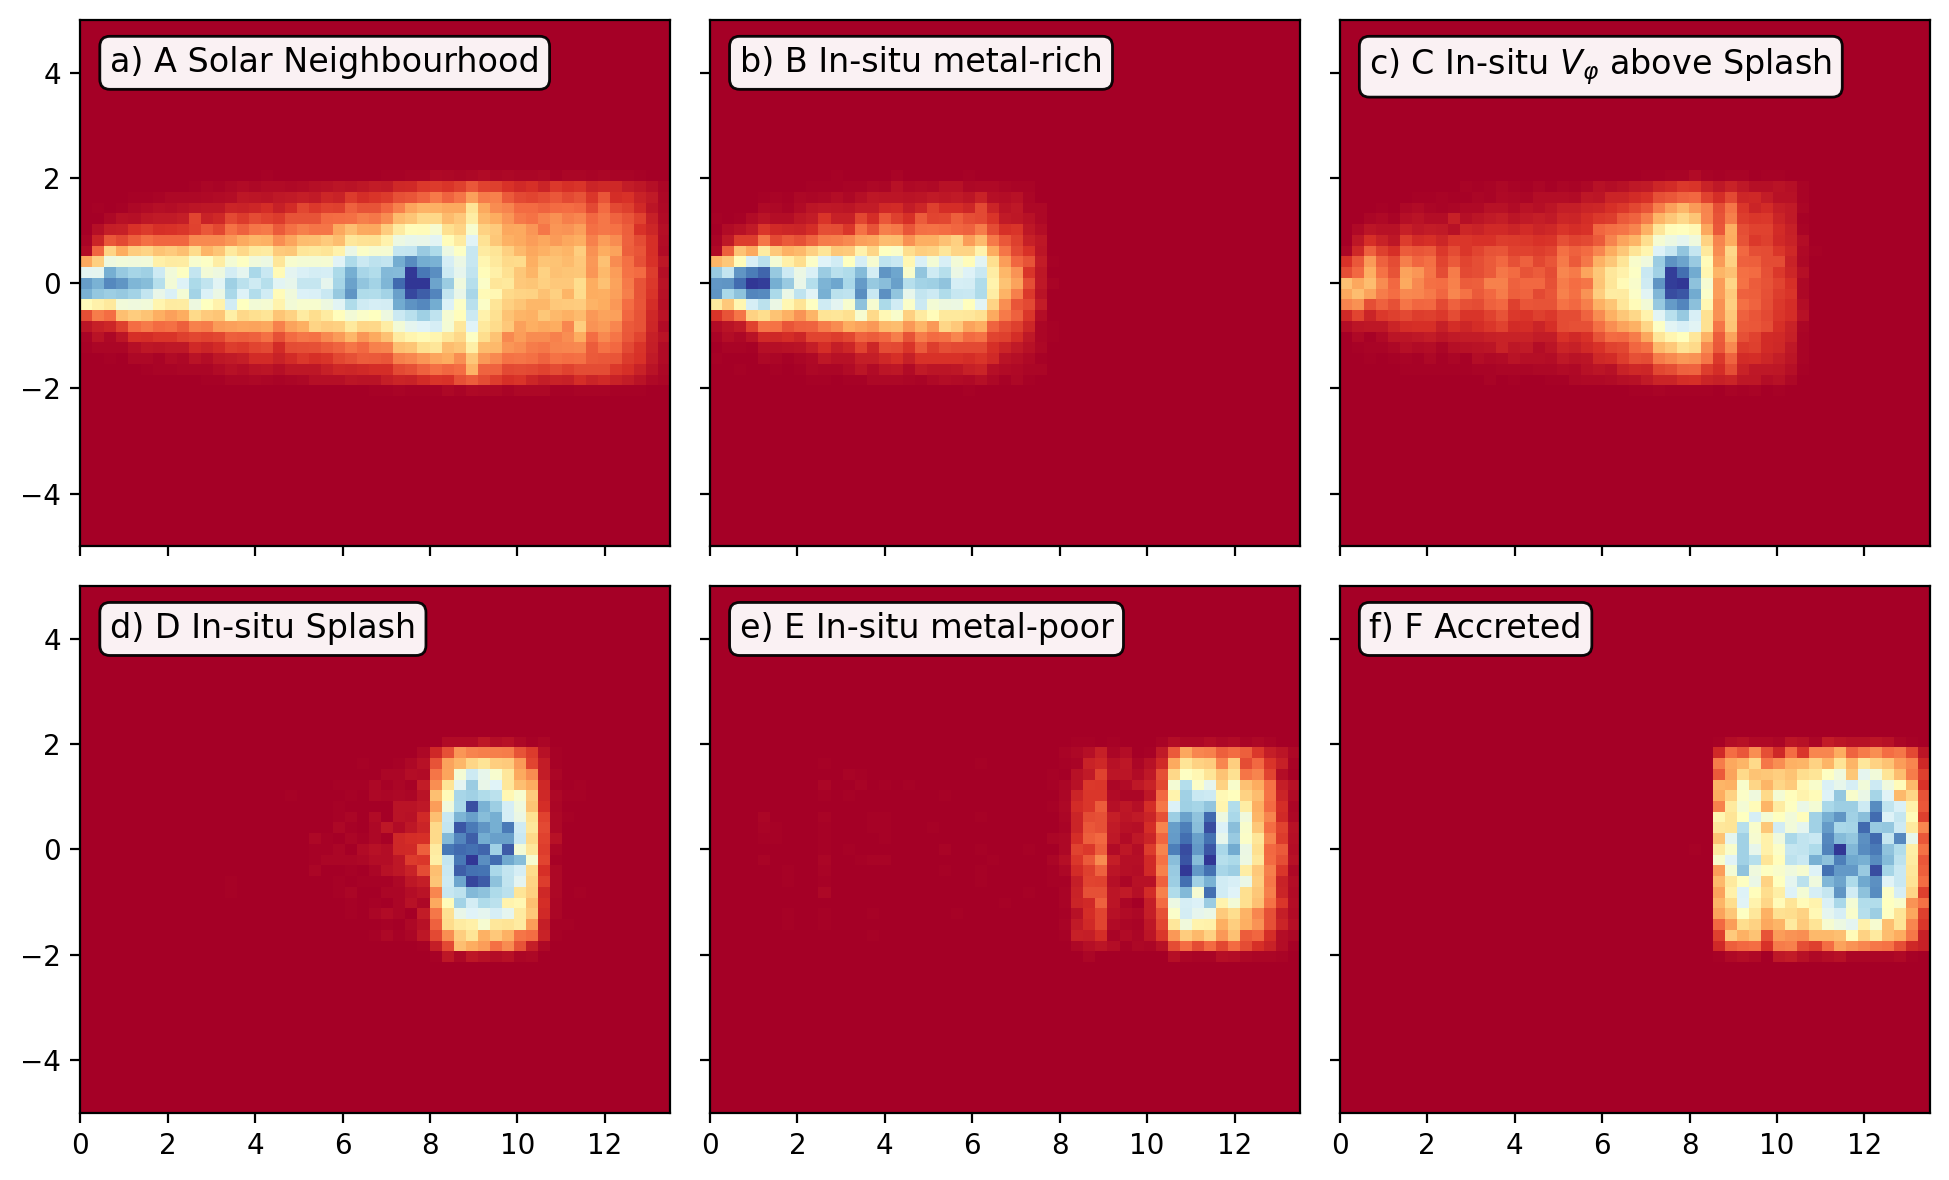

In [27]:
f, gs = plt.subplots(2,3,figsize=(10,6),sharex=True,sharey=True,constrained_layout=True)
gs = gs.flatten()

vmax = 886
rz_bins = (np.linspace(0,13.5,50),np.linspace(-5,5,50))

for index, (selection_name, selection) in enumerate(selections_and_names):
    
    ax = gs[index]
    ax.text(0.05,0.95,panels[index]+' '+selection_name,fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
    p2 = ax.hist2d(
        data['age'][selection],
        data['z_birth'][selection],
        bins = rz_bins,
        # norm = LogNorm(vmin=1,vmax = vmax),
        cmap = 'RdYlBu'
    )
plt.tight_layout()
plt.show()

f, gs = plt.subplots(2,3,figsize=(10,6),sharex=True,sharey=True,constrained_layout=True)
gs = gs.flatten()

vmax = 886

for index, (selection_name, selection) in enumerate(selections_and_names):
    
    ax = gs[index]
    ax.text(0.05,0.95,panels[index]+' '+selection_name,fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
    p2 = ax.hist2d(
        data['age'][selection],
        data['z'][selection],
        bins = rz_bins,
        # norm = LogNorm(vmin=1,vmax = vmax),
        cmap = 'RdYlBu'
    )
plt.tight_layout()
plt.show()

A $7.1_{-4.3}^{+3.2}\,\mathrm{Gyr}$
B $3.8_{-2.5}^{+2.0}\,\mathrm{Gyr}$
C $7.2_{-3.8}^{+1.3}\,\mathrm{Gyr}$
D $9.2_{-0.7}^{+0.7}\,\mathrm{Gyr}$
E $11.3_{-0.7}^{+0.9}\,\mathrm{Gyr}$
F $11.2_{-1.7}^{+1.3}\,\mathrm{Gyr}$


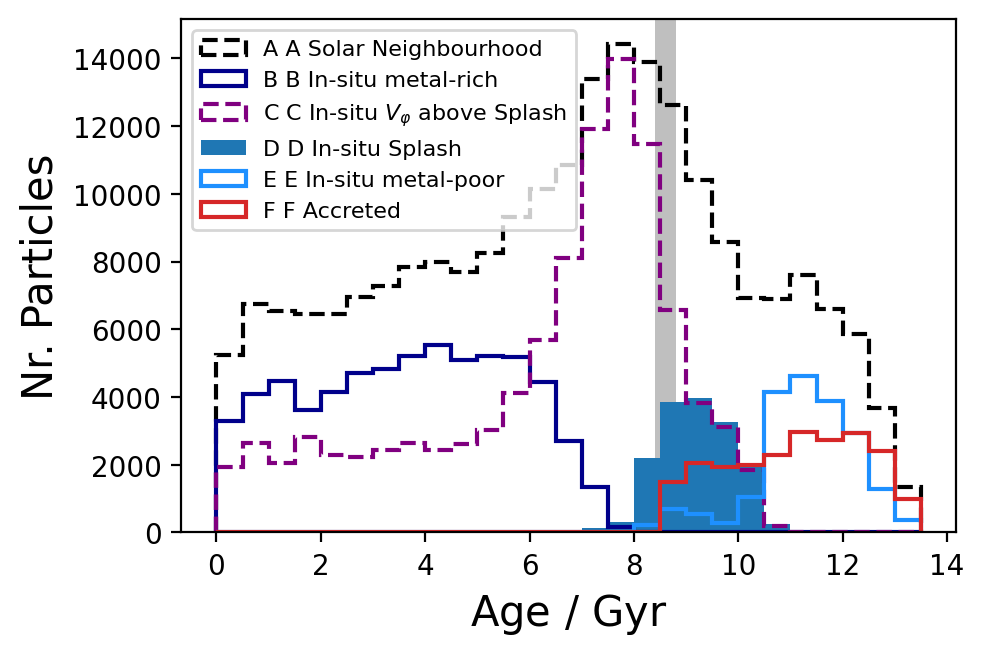

In [28]:
# How old are stars in splash compared to others (e.g. accreted ones)?
f, ax = plt.subplots(figsize=(5,4*5./6.))

#colors = ['k','darkred','C3','C1','gold','C0']
colors = ['k','darkblue','purple','C0','dodgerblue','C3']
name = ['A','B','C','D','E','F']
ls = ['dashed','solid','dashed','solid','solid','solid']
histtype = ['step','step','step','stepfilled','step','step']

for index, (selection_name, selection) in enumerate(selections_and_names):
    ax.hist(
        data['age'][selection],bins = np.arange(0,14,0.5),
        histtype=histtype[index],
        label = name[index]+' '+selection_name,
        color = colors[index],
        lw=1.5,
        ls = ls[index],
    )
    
    perc = np.round(np.percentile(data['age'][selection],q=[16,50,84]),1)
    perc_latex = r'$'+"{:.1f}".format(perc[1])+'_{-'+"{:.1f}".format(perc[1]-perc[0])+'}^{+'+"{:.1f}".format(perc[2]-perc[1])+'}'+r'\,\mathrm{Gyr}$'
    
    with open("tex/splash_analysis_age_sample_"+name[index]+".tex", "w") as f:
        f.write(perc_latex+'%')

    print(name[index],perc_latex)
    
ax.axvspan(8.6-0.2,8.6+0.2,facecolor='grey',alpha=0.5,zorder=0)
ax.legend(loc='upper left',fontsize=8)
ax.set_xlabel(r'$\mathrm{Age}~/~\mathrm{Gyr}$',fontsize=15)
ax.set_ylabel('Nr. Particles',fontsize=15)
plt.savefig('figures/splash_age.png',dpi=200,bbox_inches='tight')
plt.show()
plt.close()

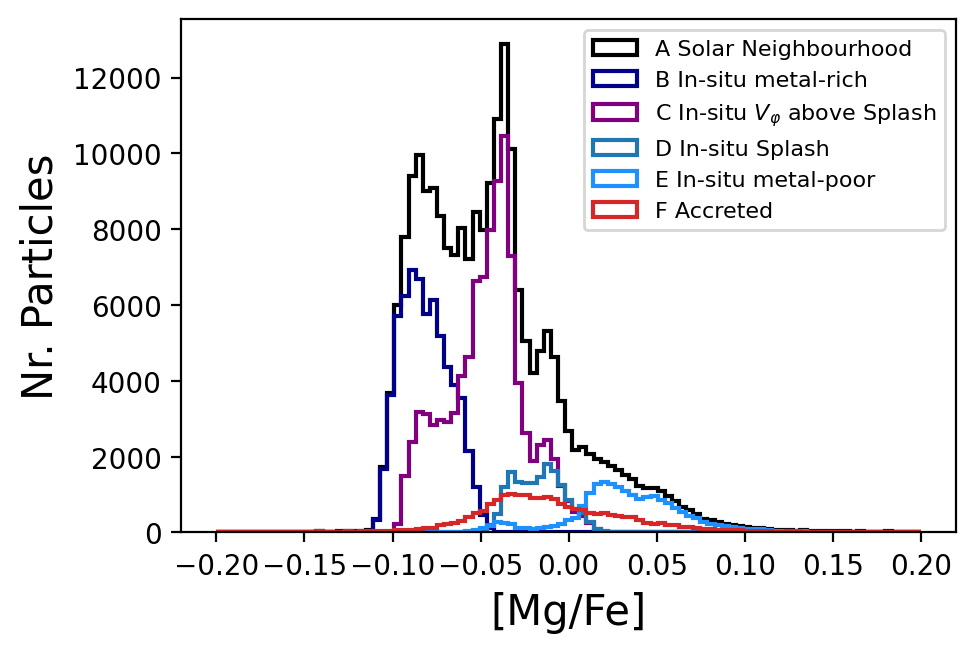

In [29]:
# Are the chemical signatures of the in-situ splash similar to the above splash?
f, ax = plt.subplots(figsize=(5,4*5./6.))

colors = ['k','darkred','C3','C1','gold','C0']
colors = ['k','darkblue','purple','C0','dodgerblue','C3']

for index, (selection_name, selection) in enumerate(selections_and_names):
    ax.hist(
        data['Mg_H'][selection]-data['Fe_H'][selection],bins = np.linspace(-0.2,0.2,100),
        histtype='step',
        label = selection_name,
        color = colors[index],
        lw = 1.5
    )
ax.legend(loc='upper right',fontsize=8)
ax.set_xlabel('[Mg/Fe]',fontsize=15)
ax.set_ylabel('Nr. Particles',fontsize=15)
plt.savefig('figures/splash_mgfe.png',dpi=200,bbox_inches='tight')
plt.show()
plt.close()

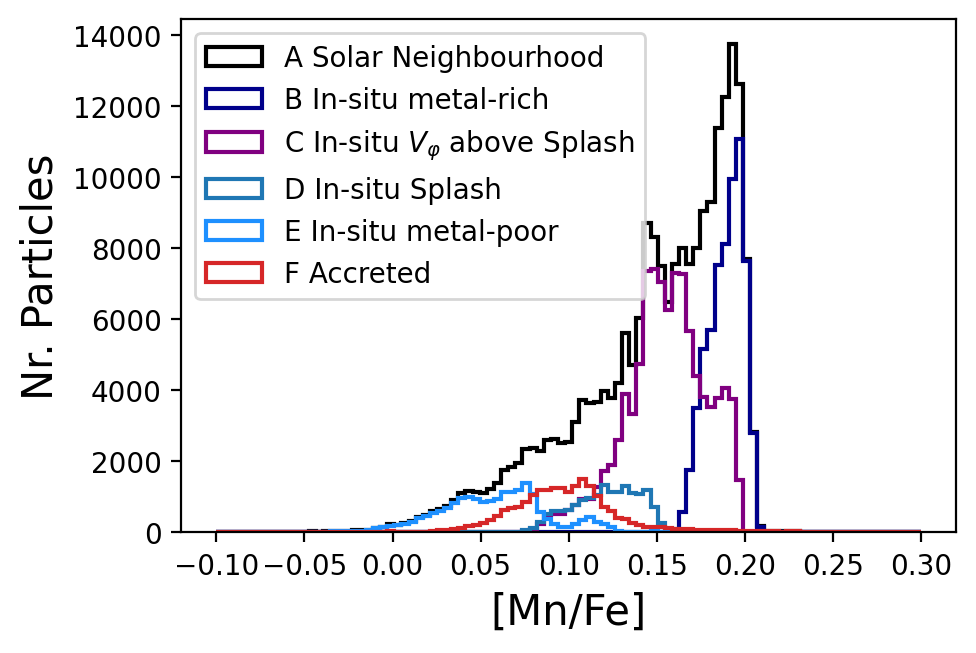

In [30]:
# Are the chemical signatures of the in-situ splash similar to the above splash?
f, ax = plt.subplots(figsize=(5,4*5./6.))

colors = ['k','darkred','C3','C1','gold','C0']
colors = ['k','darkblue','purple','C0','dodgerblue','C3']

for index, (selection_name, selection) in enumerate(selections_and_names):
    ax.hist(
        data['Mn_H'][selection]-data['Fe_H'][selection],bins = np.linspace(-0.1,0.3,100),
        histtype='step',
        label = selection_name,
        color = colors[index],
        lw = 1.5
    )
ax.legend(loc='upper left')
ax.set_xlabel('[Mn/Fe]',fontsize=15)
ax.set_ylabel('Nr. Particles',fontsize=15)
plt.savefig('figures/splash_mnfe.png',dpi=200,bbox_inches='tight')
plt.show()
plt.close()

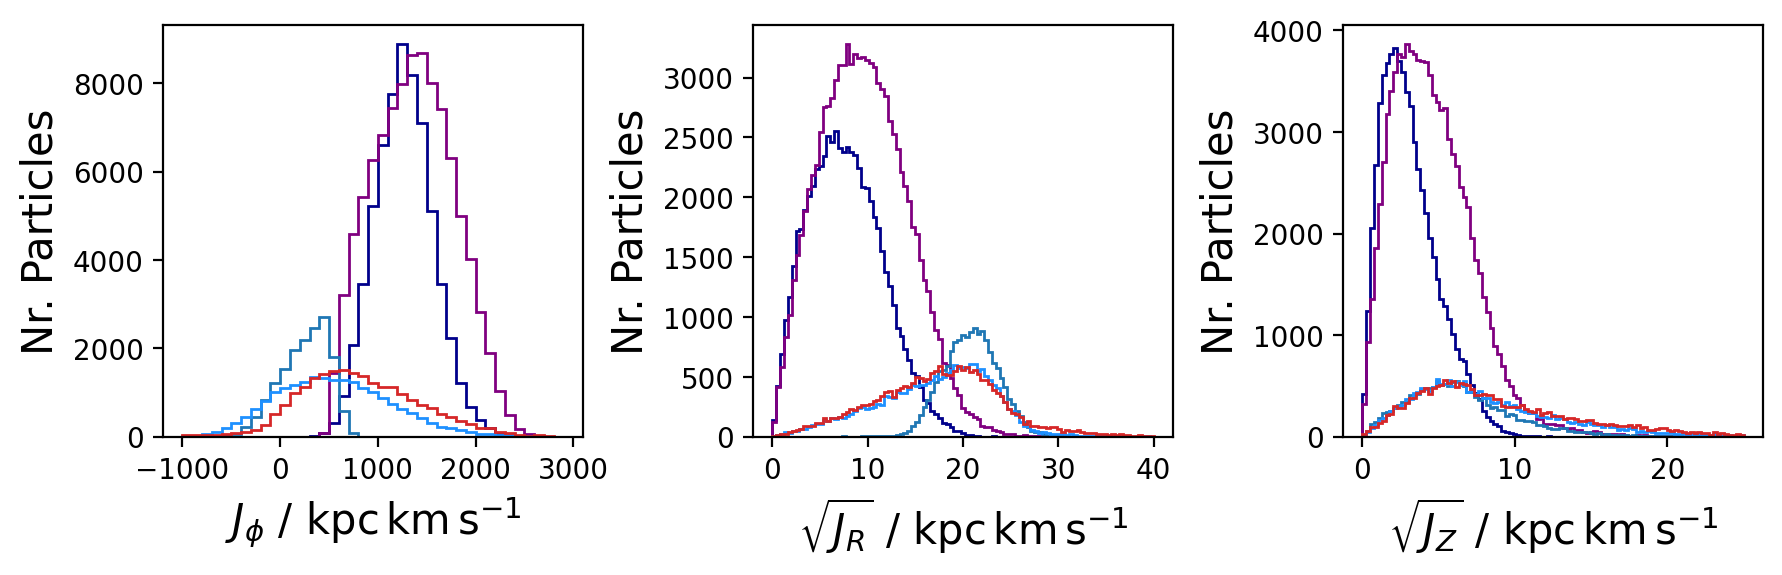

In [31]:
# And what are actions of the splashed vs. other stars -> did Belokurov also look into that?
f, gs = plt.subplots(1,3,figsize=(9,3))

colors = ['k','darkblue','purple','C0','dodgerblue','C3']

for index, (selection_name, selection) in enumerate(selections_and_names):
    if index > 0:
        ax = gs[0]
        ax.hist(
            data['JPhi'][selection],bins = np.arange(-1000,3000,100),
            histtype='step',color = colors[index],
            label = selection_name
        )
        ax.set_xlabel(r'$J_\phi~/~\mathrm{kpc\,km\,s^{-1}}$',fontsize=15)
        ax.set_ylabel('Nr. Particles',fontsize=15)
        ax = gs[1]
        ax.hist(
            np.sqrt(data['JR'][selection]),bins = np.linspace(0,40,100),
            histtype='step',color = colors[index],
            label = selection_name
        )
        ax.set_xlabel(r'$\sqrt{J_R}~/~\mathrm{kpc\,km\,s^{-1}}$',fontsize=15)
        ax.set_ylabel('Nr. Particles',fontsize=15)
        ax = gs[2]
        ax.hist(
            np.sqrt(data['JZ'][selection]),bins = np.linspace(0,25,100),
            histtype='step',color = colors[index],
            label = selection_name
        )
        ax.set_xlabel(r'$\sqrt{J_Z}~/~\mathrm{kpc\,km\,s^{-1}}$',fontsize=15)
        ax.set_ylabel('Nr. Particles',fontsize=15)
# ax.legend(loc='upper left')
plt.tight_layout()
plt.show()
plt.close()

In [32]:
# Let's take a closer look at ages 9-10 Gyr in the -0.4 < [Fe/H] < 0.1 range
splash_9_10_gyr = (
    (data['age'] > 9) & 
    (data['age'] < 10) &
    within_50kpc_born_within_50kpc & galah_like &
    (data['Fe_H'] > -0.4) & (data['Fe_H'] < 0.1) &
    (data['vphi'] < 75)
)

above_splash_9_10_gyr = (
    (data['age'] > 9) & 
    (data['age'] < 10) &
    within_50kpc_born_within_50kpc & galah_like &
    (data['Fe_H'] > -0.4) & (data['Fe_H'] < 0.1) &
    (data['vphi'] >= 75)
)

In [33]:
for index, (selection_name, selection) in enumerate(selections_and_names):
    print(selections_and_names[index][0], list(np.round(np.nanpercentile(data['ecc_0p43'][selection & np.isfinite(data['ecc_0p43'])],q=[5,50,95]),2)))
    
print('\n')
for index, (selection_name, selection) in enumerate([['Splash 9-10 Gyr', splash_9_10_gyr], ['Above Splash 9-10 Gyr', above_splash_9_10_gyr]]):
    print(selection_name, list(np.round(np.nanpercentile(data['ecc_0p43'][selection & np.isfinite(data['ecc_0p43'])],q=[5,50,95]),2)))

A Solar Neighbourhood [np.float64(0.1), np.float64(0.33), np.float64(0.87)]
B In-situ metal-rich [np.float64(0.08), np.float64(0.25), np.float64(0.49)]
C In-situ $V_\varphi$ above Splash [np.float64(0.1), np.float64(0.29), np.float64(0.57)]
D In-situ Splash [np.float64(0.63), np.float64(0.8), np.float64(0.98)]
E In-situ metal-poor [np.float64(0.22), np.float64(0.65), np.float64(0.97)]
F Accreted [np.float64(0.22), np.float64(0.58), np.float64(0.94)]


Splash 9-10 Gyr [np.float64(0.63), np.float64(0.82), np.float64(0.98)]
Above Splash 9-10 Gyr [np.float64(0.15), np.float64(0.44), np.float64(0.65)]


/Users/buder/opt/anaconda3/envs/py_3_12/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4859: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(


/var/folders/g_/1ch053ys79n87jsnqjz0yr_h0000gq/T/ipykernel_51975/2158311689.py:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


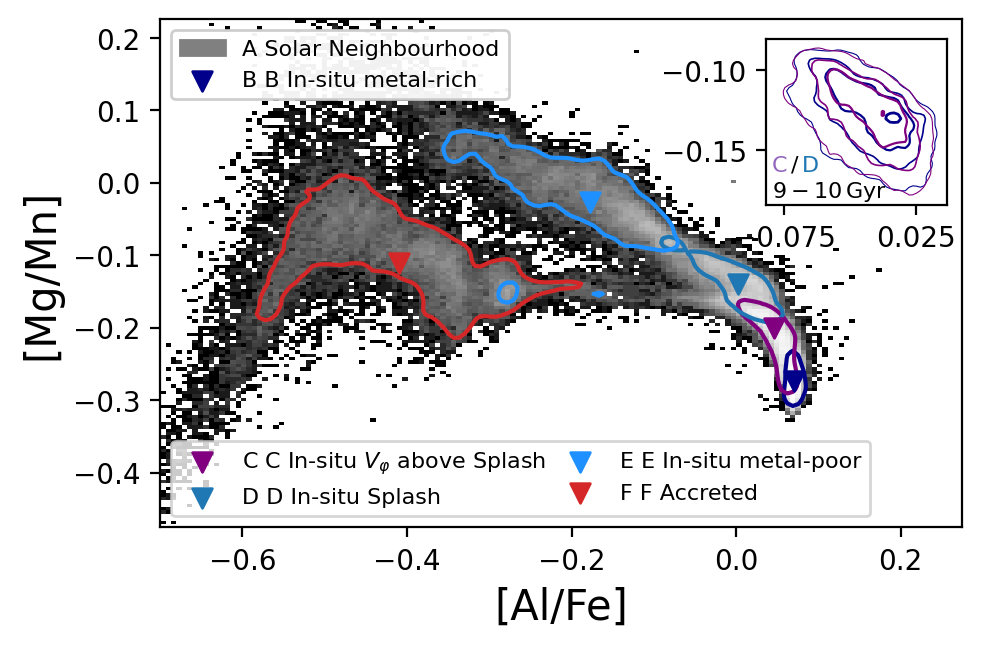

In [34]:
# Let's plot abundance distributions for all accreted stars and overplot the 68% contours for the 4 subsamples 

colors = ['darkblue','purple','C0','dodgerblue','C3']
colormaps = ['Blues','Purples']

def find_level_for_fraction(density, fraction):
    sorted_density = np.sort(density.ravel())[::-1]  # descending
    cumsum = np.cumsum(sorted_density)
    cumsum /= cumsum[-1]  # normalize to 1
    level_index = np.searchsorted(cumsum, fraction)
    return sorted_density[level_index]

zones = [1, 2, 3, 4]
name = ['A','B','C','D','E','F']

element = 'MgMn'

handles1 = []
handlesl1 = []
handles2 = []
handlesl2 = []

f, ax = plt.subplots(figsize=(5,4*5./6.))

all_density_maps = []
thresholds = []

ax_inset = inset_axes(ax,
width="22.5%",   # width relative to parent
height="32.5%",  # height relative to parent
loc='upper right',
bbox_to_anchor=(0.015, 0.015, 1, 1),
bbox_transform=ax.transAxes,
borderpad=1)

xdata = data['Al_H'] - data['Fe_H']
ydata = data['Mg_H'] - data['Mn_H']

ax_inset.text(0.03,0.01,r'$9-10\,\mathrm{Gyr}$',transform=ax_inset.transAxes,va='bottom',ha='left',fontsize=8)
ax_inset.text(0.03,0.18,r'C',color='C4',transform=ax_inset.transAxes,va='bottom',ha='left',fontsize=8)
ax_inset.text(0.14,0.18,r'/',color='k',transform=ax_inset.transAxes,va='bottom',ha='left',fontsize=8)
ax_inset.text(0.2,0.18,r'D',color='C0',transform=ax_inset.transAxes,va='bottom',ha='left',fontsize=8)

for subset, color in zip([splash_9_10_gyr,above_splash_9_10_gyr],colors):
    H, xedges, yedges = np.histogram2d(
        xdata[subset],
        ydata[subset],
        bins=(np.linspace(-0.09,0.05,50),np.linspace(-0.185,-0.08,50))
    )
    H_smooth = gaussian_filter(H, sigma=1.2)
    X, Y = np.meshgrid(
        0.5 * (xedges[:-1] + xedges[1:]),
        0.5 * (yedges[:-1] + yedges[1:])
    )
    ax_inset.contour(X, Y, H_smooth.T, levels=(1,5,10,20,), linewidths = (0.4,0.6,0.8,1.0), colors=color)
    # ax_inset.contour(X, Y, H.T, levels=(2,10,25), linewidths = (0.25,0.35,0.5), colors=color)
ax_inset.set_xticks([-0.075,0.025])

for index, (selection_name, selection) in enumerate(selections_and_names):
    # --- Define xdata, ydata, and bins ---
    if element == 'MgMn':
        xdata = data['Al_H'] - data['Fe_H']
        ydata = data['Mg_H'] - data['Mn_H']
        p1, p99 = np.percentile(ydata, q=[0.25, 99.75])
        bins = (np.linspace(-0.7, 0.275, 150), np.linspace(p1, p99, 150))
        ax.set_xlabel('[Al/Fe]',fontsize=15)
        ax.set_ylabel('[Mg/Mn]',fontsize=15)
    else:
        xdata = data['Fe_H']
        ydata = data[element+'_H'] - data['Fe_H']
        p1, p99 = np.percentile(ydata, q=[1, 99])
        bins = (np.linspace(-2.5, 0.65, 150), np.linspace(p1, p99, 150))
        ax.set_xlabel('[Fe/H]',fontsize=15)
        ax.set_ylabel('['+element+'/Fe]',fontsize=15)
        
    # --- Plot background hist2d (only once) ---
    if index == 0:
        h = ax.hist2d(
            xdata[selection],
            ydata[selection],
            bins=bins,
            cmin=1,
            cmap='Greys_r',
            norm=LogNorm(),
            label = 'A Solar Neighbourhood'
        )
        handles1.append(Patch(color='grey'))
        handlesl1.append('A Solar Neighbourhood')

    elif index > 0:
        s = ax.scatter(
            [np.median(xdata[selection])],
            [np.median(ydata[selection])],
            s = 50,zorder=5,
            marker = 'v',
            label = name[index]+' '+selection_name,
            color =colors[index-1]
        )         
        if index < 2:
            handles1.append(s)
            handlesl1.append(name[index]+' '+selection_name)
        else:
            handles2.append(s)
            handlesl2.append(name[index]+' '+selection_name)
        H, xedges, yedges = np.histogram2d(
            xdata[selection],
            ydata[selection],
            bins=bins
        )
        H_smooth = gaussian_filter(H, sigma=1.2)
        all_density_maps.append((H_smooth, xedges, yedges))

        # --- Get 68% level ---
        level_68 = find_level_for_fraction(H_smooth, 0.68)
        thresholds.append(level_68)
        
        # colors = ['darkred','C3','C1','gold','C0']
        colors = ['darkblue','purple','C0','dodgerblue','C3']

        X, Y = np.meshgrid(
            0.5 * (xedges[:-1] + xedges[1:]),
            0.5 * (yedges[:-1] + yedges[1:])
        )
        ax.contour(X, Y, H_smooth.T, levels=[level_68], colors=colors[index-1])
    
leg1 = ax.legend(handles1, handlesl1,loc='upper left',fontsize=8,columnspacing=0.5,framealpha=0.95)
ax.add_artist(leg1)
ax.legend(handles2, handlesl2,loc='lower left',ncol=2,fontsize=8,columnspacing=0.5)

plt.tight_layout()
plt.savefig('figures/splash_alfe_mgmn.png',dpi=200,bbox_inches='tight',facecolor='w')
plt.show()
plt.close()

/var/folders/g_/1ch053ys79n87jsnqjz0yr_h0000gq/T/ipykernel_51975/1794556113.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


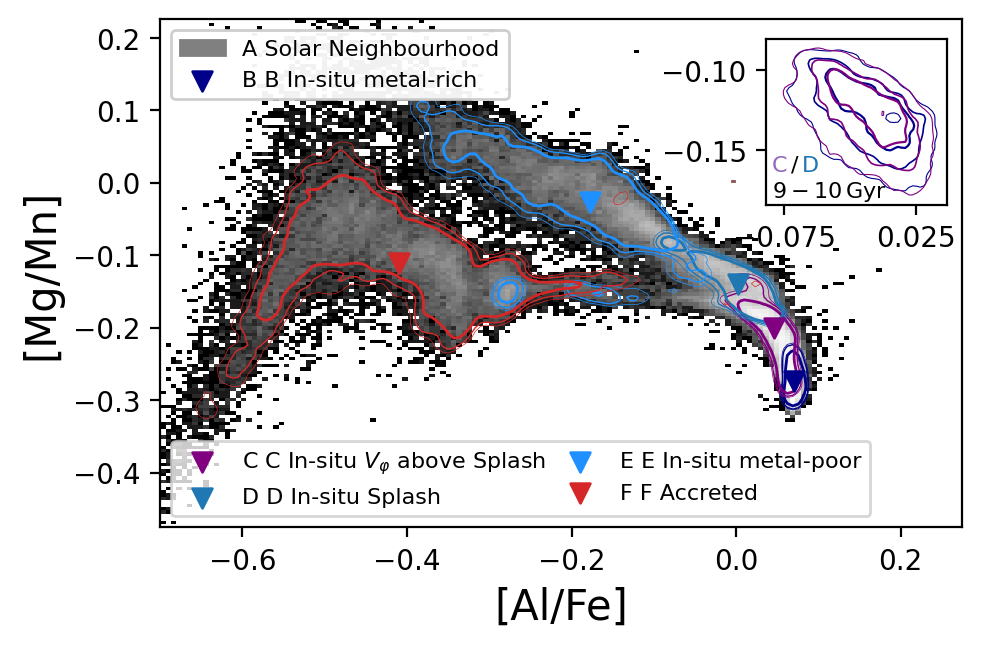

In [35]:
# Let's plot abundance distributions for all accreted stars and overplot the 68% contours for the 4 subsamples 

colors = ['darkblue','purple','C0','dodgerblue','C3']
colormaps = ['Blues','Purples']

def find_level_for_fraction(density, fraction):
    sorted_density = np.sort(density.ravel())[::-1]  # descending
    cumsum = np.cumsum(sorted_density)
    cumsum /= cumsum[-1]  # normalize to 1
    level_index = np.searchsorted(cumsum, fraction)
    return sorted_density[level_index]

zones = [1, 2, 3, 4]
name = ['A','B','C','D','E','F']

element = 'MgMn'

handles1 = []
handlesl1 = []
handles2 = []
handlesl2 = []

f, ax = plt.subplots(figsize=(5,4*5./6.))

all_density_maps = []

ax_inset = inset_axes(ax,
width="22.5%",   # width relative to parent
height="32.5%",  # height relative to parent
loc='upper right',
bbox_to_anchor=(0.015, 0.015, 1, 1),
bbox_transform=ax.transAxes,
borderpad=1)

xdata = data['Al_H'] - data['Fe_H']
ydata = data['Mg_H'] - data['Mn_H']

ax_inset.text(0.03,0.01,r'$9-10\,\mathrm{Gyr}$',transform=ax_inset.transAxes,va='bottom',ha='left',fontsize=8)
ax_inset.text(0.03,0.18,r'C',color='C4',transform=ax_inset.transAxes,va='bottom',ha='left',fontsize=8)
ax_inset.text(0.14,0.18,r'/',color='k',transform=ax_inset.transAxes,va='bottom',ha='left',fontsize=8)
ax_inset.text(0.2,0.18,r'D',color='C0',transform=ax_inset.transAxes,va='bottom',ha='left',fontsize=8)

for subset, color in zip([splash_9_10_gyr,above_splash_9_10_gyr],colors):
    H, xedges, yedges = np.histogram2d(
        xdata[subset],
        ydata[subset],
        bins=(np.linspace(-0.09,0.05,50),np.linspace(-0.185,-0.08,50))
    )
    H_smooth = gaussian_filter(H, sigma=1.2)
    X, Y = np.meshgrid(
        0.5 * (xedges[:-1] + xedges[1:]),
        0.5 * (yedges[:-1] + yedges[1:])
    )
    ax_inset.contour(X, Y, H_smooth.T, levels=(1,5,10,20,), linewidths = (0.4,0.6,0.8,), colors=color)
    # ax_inset.contour(X, Y, H.T, levels=(2,10,25), linewidths = (0.25,0.35,0.5), colors=color)
ax_inset.set_xticks([-0.075,0.025])

for index, (selection_name, selection) in enumerate(selections_and_names):
    # --- Define xdata, ydata, and bins ---
    if element == 'MgMn':
        xdata = data['Al_H'] - data['Fe_H']
        ydata = data['Mg_H'] - data['Mn_H']
        p1, p99 = np.percentile(ydata, q=[0.25, 99.75])
        bins = (np.linspace(-0.7, 0.275, 150), np.linspace(p1, p99, 150))
        ax.set_xlabel('[Al/Fe]',fontsize=15)
        ax.set_ylabel('[Mg/Mn]',fontsize=15)
    else:
        xdata = data['Fe_H']
        ydata = data[element+'_H'] - data['Fe_H']
        p1, p99 = np.percentile(ydata, q=[1, 99])
        bins = (np.linspace(-2.5, 0.65, 150), np.linspace(p1, p99, 150))
        ax.set_xlabel('[Fe/H]',fontsize=15)
        ax.set_ylabel('['+element+'/Fe]',fontsize=15)
        
    # --- Plot background hist2d (only once) ---
    if index == 0:
        h = ax.hist2d(
            xdata[selection],
            ydata[selection],
            bins=bins,
            cmin=1,
            cmap='Greys_r',
            norm=LogNorm(),
            label = 'A Solar Neighbourhood'
        )
        handles1.append(Patch(color='grey'))
        handlesl1.append('A Solar Neighbourhood')

    elif index > 0:
        s = ax.scatter(
            [np.median(xdata[selection])],
            [np.median(ydata[selection])],
            s = 50,zorder=5,
            marker = 'v',
            label = name[index]+' '+selection_name,
            color =colors[index-1]
        )         
        if index < 2:
            handles1.append(s)
            handlesl1.append(name[index]+' '+selection_name)
        else:
            handles2.append(s)
            handlesl2.append(name[index]+' '+selection_name)
        H, xedges, yedges = np.histogram2d(
            xdata[selection],
            ydata[selection],
            bins=bins
        )
        H_smooth = gaussian_filter(H, sigma=1.2)
        all_density_maps.append((H_smooth, xedges, yedges))

        # --- Get 68 and 80% level ---
        levels = (find_level_for_fraction(H_smooth, 0.85), find_level_for_fraction(H_smooth, 0.8), find_level_for_fraction(H_smooth, 0.68))
        
        # colors = ['darkred','C3','C1','gold','C0']
        colors = ['darkblue','purple','C0','dodgerblue','C3']

        X, Y = np.meshgrid(
            0.5 * (xedges[:-1] + xedges[1:]),
            0.5 * (yedges[:-1] + yedges[1:])
        )
        ax.contour(X, Y, H_smooth.T, levels=levels, colors=colors[index-1], linewidths = [0.25,0.5,1])
    
leg1 = ax.legend(handles1, handlesl1,loc='upper left',fontsize=8,columnspacing=0.5,framealpha=0.95)
ax.add_artist(leg1)
ax.legend(handles2, handlesl2,loc='lower left',ncol=2,fontsize=8,columnspacing=0.5)

plt.tight_layout()
plt.savefig('figures/splash_alfe_mgmn_extended.png',dpi=200,bbox_inches='tight',facecolor='w')
plt.show()
plt.close()

0.63 of stars in GALAH-like sample are in the MgMn-AlFe bridge region
0.63  of A Solar Neighbourhood are in the MgMn-AlFe bridge region
2.16  of B In-situ metal-rich are in the MgMn-AlFe bridge region
1.41  of C In-situ $V_\varphi$ above Splash are in the MgMn-AlFe bridge region
8.57  of D In-situ Splash are in the MgMn-AlFe bridge region
6.87  of E In-situ metal-poor are in the MgMn-AlFe bridge region
6.36  of F Accreted are in the MgMn-AlFe bridge region


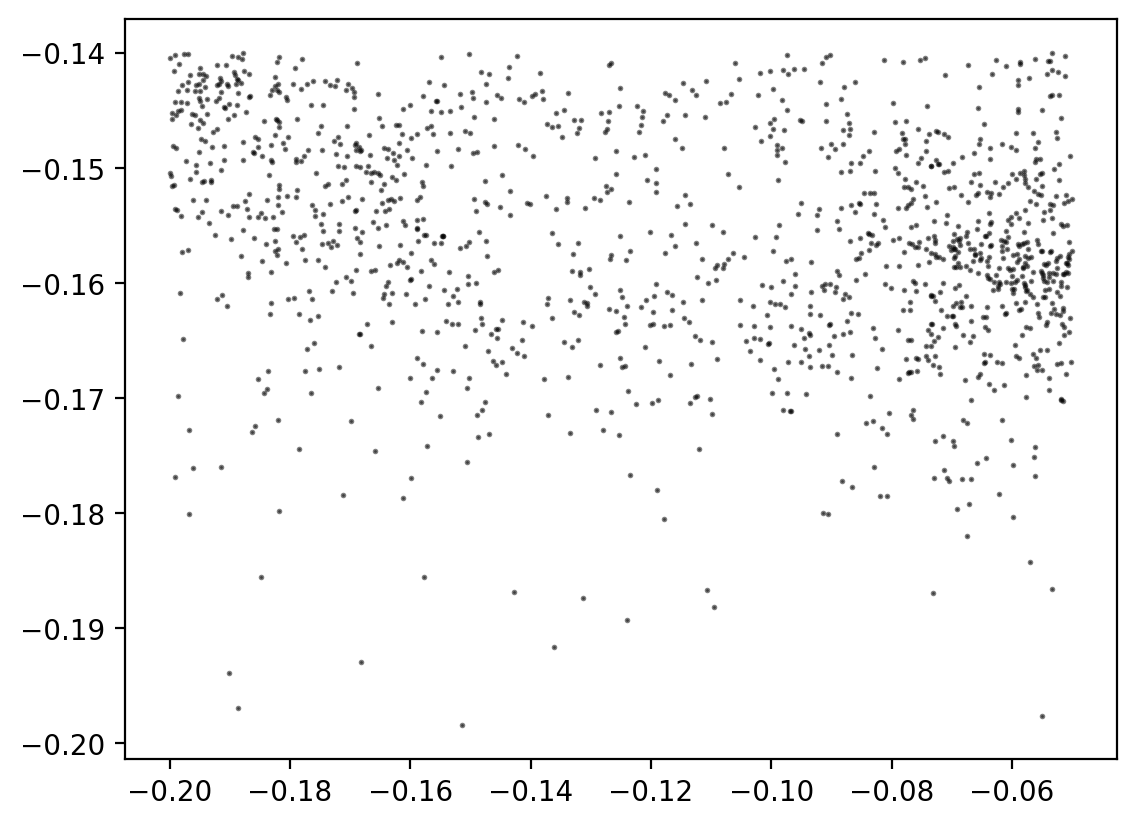

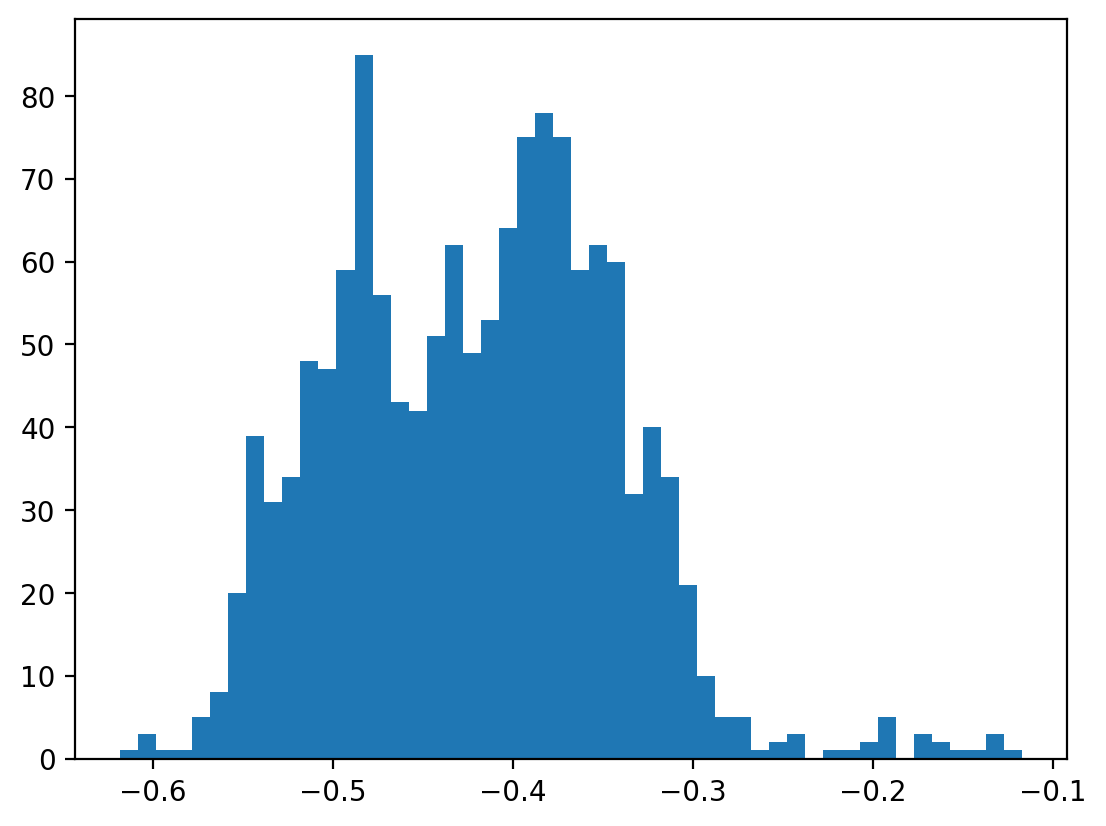

In [36]:
bridge_in_mgmn_alfe = (
    galah_like &
    (data['Al_H'] - data['Fe_H'] < -0.05) &
    (data['Al_H'] - data['Fe_H'] > -0.2) &
    # (data['Mg_H'] - data['Mn_H'] > -0.2) &
    (data['Mg_H'] - data['Mn_H'] < -0.14)
)
print(np.round(100*len(data['Fe_H'][bridge_in_mgmn_alfe])/len(data['Fe_H'][galah_like]),2),'of stars in GALAH-like sample are in the MgMn-AlFe bridge region')

for name, selection in selections_and_names:
    print(np.round(100*len(data['Fe_H'][bridge_in_mgmn_alfe])/len(data['Fe_H'][selection]),2),' of '+name+' are in the MgMn-AlFe bridge region')
plt.scatter(
    data['Al_H'][bridge_in_mgmn_alfe] - data['Fe_H'][bridge_in_mgmn_alfe],
    data['Mg_H'][bridge_in_mgmn_alfe] - data['Mn_H'][bridge_in_mgmn_alfe],
    s=1, color='k', alpha=0.5
)
plt.show()
plt.close()
plt.hist(data['Fe_H'][bridge_in_mgmn_alfe], bins=50)
plt.show()

/var/folders/g_/1ch053ys79n87jsnqjz0yr_h0000gq/T/ipykernel_51975/1866915146.py:165: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  f.subplots_adjust(top=0.85, wspace=0.3, hspace=0.3)
/var/folders/g_/1ch053ys79n87jsnqjz0yr_h0000gq/T/ipykernel_51975/1866915146.py:168: UserWarning: The figure layout has changed to tight
  plt.tight_layout(h_pad=0,w_pad=0)


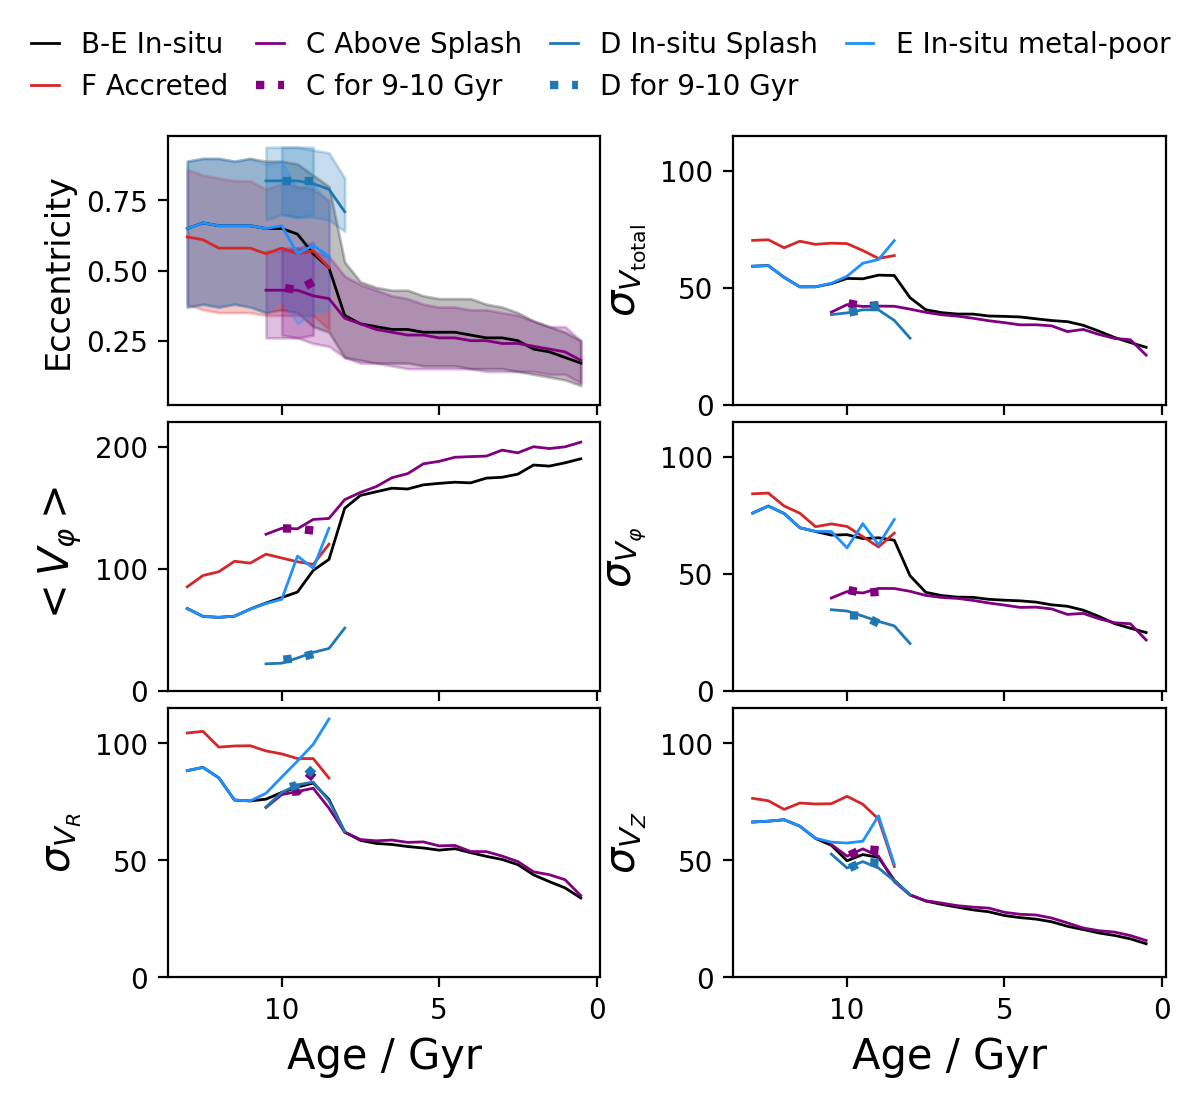

In [37]:
age_bin_size = 0.5  # Gyr
age_bins = np.arange(age_bin_size/2,13.5+age_bin_size/2,age_bin_size)

ecc_percentiles = dict()
vphi_mean = dict()
vr_mean = dict()
vz_mean = dict()
vphi_sigma = dict()
vr_sigma = dict()
vz_sigma = dict()
vtotal_sigma = dict()

# Let's take a closer look at ages 9-10 Gyr in the -0.4 < [Fe/H] < 0.1 range
splash_9_10_gyr = (
    (data['age'] > 9) & 
    (data['age'] < 10) &
    within_50kpc_born_within_50kpc & galah_like &
    (data['Fe_H'] > -0.4) & (data['Fe_H'] < 0.1) &
    (data['vphi'] < 75)
)

above_splash_9_10_gyr = (
    (data['age'] > 9) & 
    (data['age'] < 10) &
    within_50kpc_born_within_50kpc & galah_like &
    (data['Fe_H'] > -0.4) & (data['Fe_H'] < 0.1) &
    (data['vphi'] >= 75)
)

sample_name = [
    'B-E In-situ',
    'F Accreted',
    'C Above Splash',
    'C for 9-10 Gyr',
    'D In-situ Splash',
    'D for 9-10 Gyr',
    'E In-situ metal-poor'
    ]
sample_selection = [
    within_50kpc_born_within_50kpc & galah_like, 
    within_50kpc_born_outside_50kpc & galah_like,
    (
        within_50kpc_born_within_50kpc & galah_like &
        (data['Fe_H'] > -0.4) & (data['Fe_H'] < 0.1) &
        (data['vphi'] > 75)
    ),
    above_splash_9_10_gyr, 
    (
        within_50kpc_born_within_50kpc & galah_like &
        (data['Fe_H'] > -0.4) & (data['Fe_H'] < 0.1) &
        (data['vphi'] > -100) & (data['vphi'] < 75)
    ),
    splash_9_10_gyr, 
    (
        within_50kpc_born_within_50kpc & galah_like &
        (data['Fe_H'] < -0.4)
    )
    ]
colors = [
    'k',
    'C3',
    'purple',
    'purple',
    'C0',
    'C0',
    'dodgerblue'
    ]
linestyles = [
    'solid',
    'solid',
    'solid',
    'dotted',
    'solid',
    'dotted',
    'solid'
]
linewidths = [
    1.0,
    1.0,
    1.0,
    3.0,
    1.0,
    3.0,
    1.0
]

for name, sample, color in zip(sample_name, sample_selection, colors):
    ecc_percentiles[name] = []
    vphi_mean[name] = []
    vr_mean[name] = []
    vz_mean[name] = []
    vphi_sigma[name] = []
    vr_sigma[name] = []
    vz_sigma[name] = []
    vtotal_sigma[name] = []

    for index, (age_min, age_max) in enumerate(zip(age_bins[:-1], age_bins[1:])):
        selection = (
            (data['age'] >= age_min) & (data['age'] < age_max) &
            sample &
            np.isfinite(data['ecc_0p43']) & np.isfinite(data['vphi'])
        )

        if len(data['ecc_0p43'][selection]) > 200:
            # print(age_min, age_max, name, len(data['ecc_0p43'][selection]))
            ecc_percentiles[name].append(np.array(np.round(np.percentile(data['ecc_0p43'][selection],q=[16,50,84]),2)))
            vphi_mean[name].append(np.mean(data['vphi'][selection]))
            vr_mean[name].append(np.mean(data['vr'][selection]))
            vz_mean[name].append(np.mean(data['vz'][selection]))
            vphi_sigma[name].append(np.std(data['vphi'][selection]))
            vr_sigma[name].append(np.std(data['vr'][selection]))
            vz_sigma[name].append(np.std(data['vz'][selection]))
            vtotal_sigma[name].append(np.std(np.sqrt(data['vx']**2+data['vy']**2+data['vz']**2)[selection]))
        else:
            ecc_percentiles[name].append(np.array([np.nan,np.nan,np.nan]))
            vphi_mean[name].append(np.nan)
            vr_mean[name].append(np.nan)
            vz_mean[name].append(np.nan)
            vphi_sigma[name].append(np.nan)
            vr_sigma[name].append(np.nan)
            vz_sigma[name].append(np.nan)
            vtotal_sigma[name].append(np.nan)
            
    ecc_percentiles[name] = np.array(ecc_percentiles[name])
    vphi_mean[name] = np.array(vphi_mean[name])
    vr_mean[name] = np.array(vr_mean[name])
    vz_mean[name] = np.array(vz_mean[name])
    vphi_sigma[name] = np.array(vphi_sigma[name])
    vr_sigma[name] = np.array(vr_sigma[name])
    vz_sigma[name] = np.array(vz_sigma[name])
    vtotal_sigma[name] = np.array(vtotal_sigma[name])

f, gs = plt.subplots(3,2,figsize=(6,5),constrained_layout=True, sharex=True)
gs = gs.flatten()

for index, (quantity, quantity_name) in enumerate(zip([ecc_percentiles, vtotal_sigma, vphi_mean, vphi_sigma, vr_sigma, vz_sigma], ['Eccentricity', r'$\sigma_{V_\mathrm{total}}$', r'$<V_\varphi>$', r'$\sigma_{V_\varphi}$', r'$\sigma_{V_R}$', r'$\sigma_{V_Z}$'])):
    ax = gs[index]
    for name, sample, color, ls, lw in zip(sample_name, sample_selection, colors, linestyles, linewidths):
        if quantity_name == 'Eccentricity':
            ax.plot(age_bins[:-1]+age_bin_size/2, [e[1] for e in quantity[name]], lw=lw, label=name, color=color, ls = ls)
            ax.fill_between(age_bins[:-1]+age_bin_size/2, [e[0] for e in quantity[name]], [e[2] for e in quantity[name]], color=color, alpha=0.25)
            ax.set_ylabel(quantity_name, fontsize=12)
        else:
            ax.plot(age_bins[:-1]+age_bin_size/2, quantity[name], lw=lw, label=name, color=color, ls = ls)
            ax.set_ylabel(quantity_name, fontsize=15)
    if index >= 4:
        ax.set_xlabel('Age / Gyr', fontsize=15)
    if index == 0:
        ax.set_ylim(0.02,0.98)
    if index == 2:
        ax.set_ylim(0,220)
    if index in [1,3,4,5]:
        ax.set_ylim(0,115)

handles, labels = gs[0].get_legend_handles_labels()
f.legend(
    handles,
    labels,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.1),  # adjust vertical position if needed
    ncol=4,                      # number of legend columns
    frameon=False,
    handlelength=1, columnspacing=1
)
f.subplots_adjust(top=0.85, wspace=0.3, hspace=0.3)

ax.set_xlim(ax.get_xlim()[::-1])
plt.tight_layout(h_pad=0,w_pad=0)
plt.savefig('figures/kinematics_over_age.png',dpi=200,bbox_inches='tight',facecolor='w')
plt.show()

/var/folders/g_/1ch053ys79n87jsnqjz0yr_h0000gq/T/ipykernel_51975/1037242377.py:24: RuntimeWarning: invalid value encountered in divide
  Hcol[column,:] /= np.nanmax(Hcol[column,:])
/var/folders/g_/1ch053ys79n87jsnqjz0yr_h0000gq/T/ipykernel_51975/1037242377.py:34: RuntimeWarning: invalid value encountered in divide
  Hrow[:,row] /= np.nanmax(Hrow[:,row])


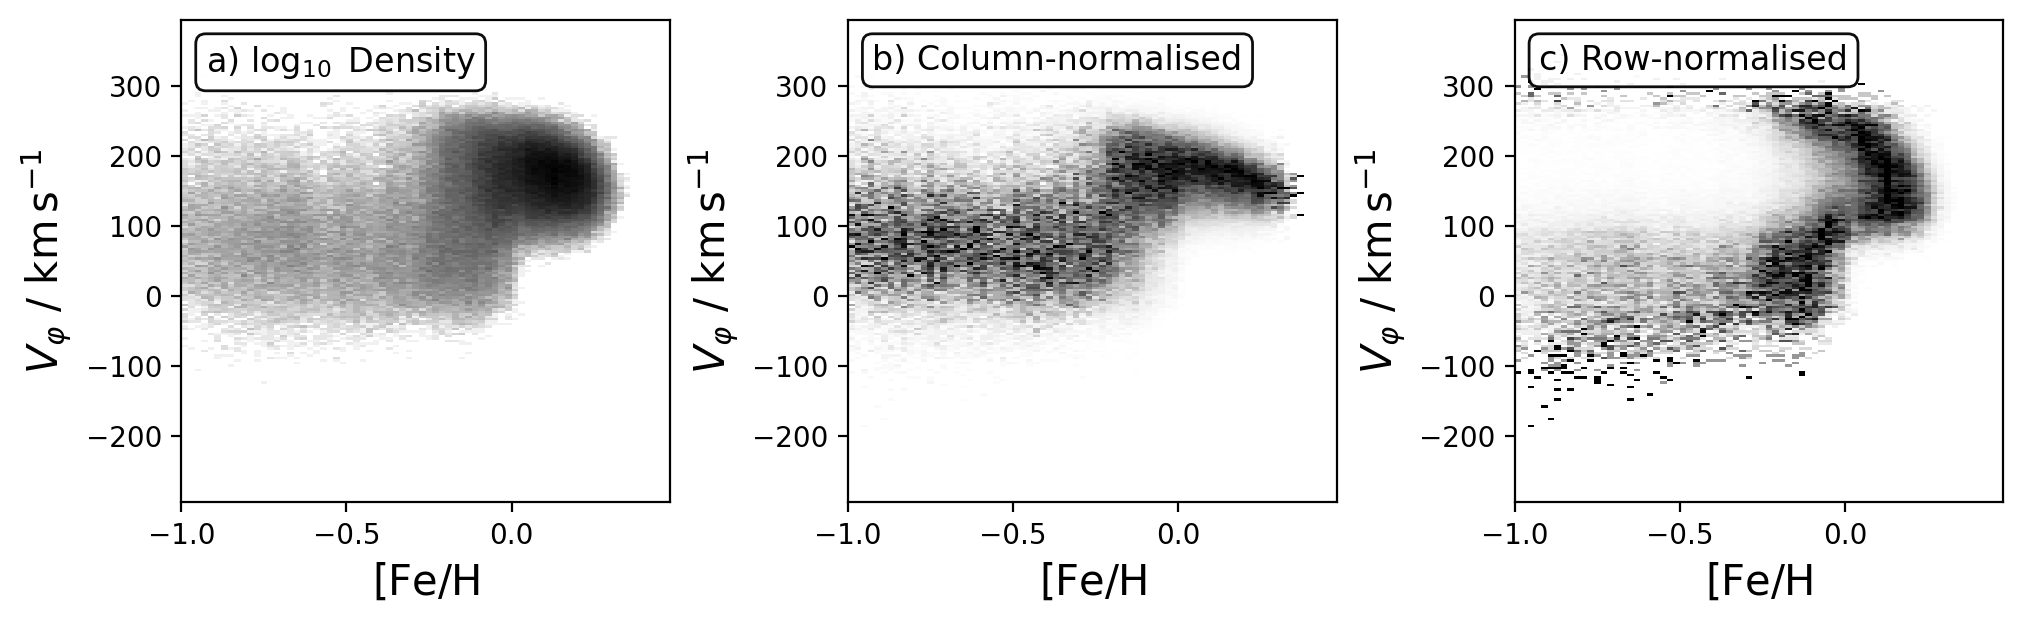

In [38]:
# Calculate the same figure as Belokurov et al. (2020).
f, gs = plt.subplots(1,3,figsize=(10,3),sharex=True,constrained_layout=True)

H, xedges, yedges = np.histogram2d(
    data['Fe_H'][galah_like],
    data['vphi'][galah_like],
    bins = (np.arange(-age_delta,0.5,0.02),np.linspace(-295,395,200))
)

ax = gs[0]
ax.text(0.05,0.95,r'a) $\log_{10}$ Density',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_xlabel(r'$\mathrm{[Fe/H}$', fontsize=15)
ax.set_ylabel(r'$V_\varphi~/~\mathrm{km\,s^{-1}}$', fontsize=15)
H0 = H.copy()
H0[H0==0] = np.nan
ax.pcolormesh(xedges, yedges, H0.T, shading='auto', cmap='Greys', norm=LogNorm())  # or any colormap you like

ax = gs[1]
ax.text(0.05,0.95,r'b) Column-normalised',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_xlabel(r'$\mathrm{[Fe/H}$', fontsize=15)
ax.set_ylabel(r'$V_\varphi~/~\mathrm{km\,s^{-1}}$', fontsize=15)
Hcol = H.copy()
for column in range(np.shape(Hcol)[0]):
    Hcol[column,:] /= np.nanmax(Hcol[column,:])
Hcol[Hcol==0] = np.nan
ax.pcolormesh(xedges, yedges, Hcol.T, shading='auto', cmap='Greys')#, norm=LogNorm())  # or any colormap you like

ax = gs[2]
ax.text(0.05,0.95,r'c) Row-normalised',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_xlabel(r'$\mathrm{[Fe/H}$', fontsize=15)
ax.set_ylabel(r'$V_\varphi~/~\mathrm{km\,s^{-1}}$', fontsize=15)
Hrow = H.copy()
for row in range(np.shape(Hrow)[1]):
    Hrow[:,row] /= np.nanmax(Hrow[:,row])
Hrow[Hrow==0] = np.nan
ax.pcolormesh(xedges, yedges, Hrow.T, shading='auto', cmap='Greys')#, norm=LogNorm())  # or any colormap you like

plt.savefig('figures/splash_different_normalisations.png',dpi=200,bbox_inches='tight')

plt.show()
plt.close()

$V_\varphi = 73_{-59}^{+74}\,\mathrm{km\,s^{-1}}$


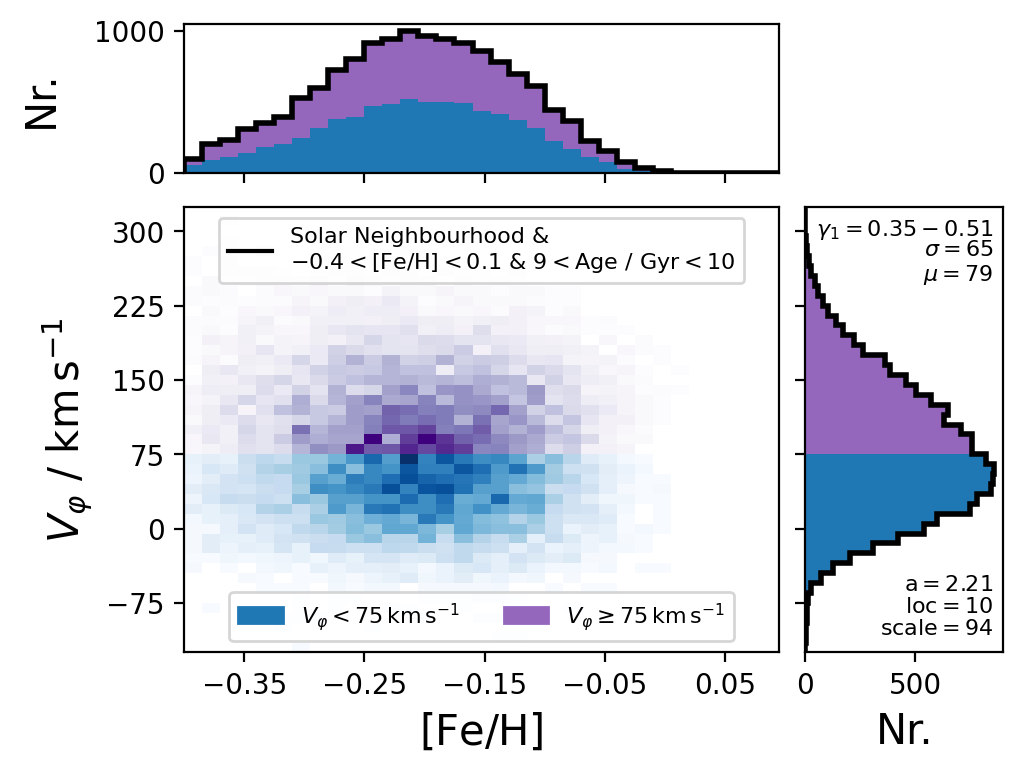

In [39]:
# Let's show [Fe/H] vs. Vphi for the splash stars and calculate some stats
fig = plt.figure(figsize=(5,3.75), constrained_layout=True)
gs = GridSpec(4, 4, figure=fig, hspace=0.05, wspace=0.05)

feh_bins = np.arange(-0.4,0.1,0.015)
vphi_bins = np.arange(-125,335,10)

# Define axes
ax_main = fig.add_subplot(gs[1:, :-1])     # bottom left large panel
ax_xhist = fig.add_subplot(gs[0, :-1], sharex=ax_main)  # top left small panel
ax_yhist = fig.add_subplot(gs[1:, -1], sharey=ax_main)  # bottom right small panel

# Plot main 2D histogram
ax_main.hist2d(
    data['Fe_H'][splash_9_10_gyr],
    data['vphi'][splash_9_10_gyr],
    bins = (feh_bins,vphi_bins),
    cmin = 1,
    cmap = 'Blues',
    label = r'$V_\varphi < 75\,\mathrm{km\,s^{-1}}$'
);
ax_main.hist2d(
    data['Fe_H'][above_splash_9_10_gyr],
    data['vphi'][above_splash_9_10_gyr],
    bins = (feh_bins,vphi_bins),
    cmin = 1,
    cmap = 'Purples',
    label = r'$V_\varphi \geq 75\,\mathrm{km\,s^{-1}}$coud'
);

# Plot top histogram (x)
ax_xhist.hist(
    [
        data['Fe_H'][splash_9_10_gyr | above_splash_9_10_gyr]
    ],
    bins = feh_bins,
    histtype = 'step',
    color = 'k',
    lw = 2,
#     label = r'$-0.4 < \mathrm{[Fe/H]} < 0.1$'+'\n& '+r'$9 < \mathrm{Age~/~Gyr} < 11$'
);
ax_xhist.hist(
    [
        data['Fe_H'][splash_9_10_gyr],
        data['Fe_H'][above_splash_9_10_gyr],
    ],
    bins = feh_bins,
    stacked = True,
    color = ['C0','C4'],
#     label = ['As above and\n'+r'$V_\varphi < 75\,\mathrm{km\,s^{-1}}$','As above and\n'+r'$V_\varphi > 75\,\mathrm{km\,s^{-1}}$']
);

# Plot right histogram (y)
ax_yhist.hist(
    [
        data['vphi'][splash_9_10_gyr | above_splash_9_10_gyr]
    ],
    bins = vphi_bins,
    histtype = 'step',
    color = 'k',
    lw = 2,
    orientation='horizontal'
    #label = r'$-0.4 < \mathrm{[Fe/H]} < 0.1$'+'\n& '+r'$9 < \mathrm{Age~/~Gyr} < 10$'
);
ax_yhist.hist(
    [
        data['vphi'][splash_9_10_gyr],
        data['vphi'][above_splash_9_10_gyr],
    ],
    bins = vphi_bins,
    stacked = True,
    color = ['C0','C4'],
    orientation='horizontal'
    #label = ['As above and\n'+r'$V_\varphi < 75\,\mathrm{km\,s^{-1}}$','As above and\n'+r'$V_\varphi > 75\,\mathrm{km\,s^{-1}}$']
);

ax_yhist.set_xlabel('Nr.',fontsize=15)
ax_xhist.set_ylabel('Nr.',fontsize=15,labelpad=11.5)

# Tidy up
ax_xhist.tick_params(labelbottom=False)
ax_yhist.tick_params(labelleft=False)

ax_main.set_xticks([-0.35,-0.25,-0.15,-0.05,0.05])
ax_main.set_yticks([-75,0,75,150,225,300])
ax_main.set_xlabel(r'$\mathrm{[Fe/H]}$',fontsize=15)
ax_main.set_ylabel(r'$V_\varphi~/~\mathrm{km\,s^{-1}}$',fontsize=15)


legend_patches = [
    Line2D([],[],color='k'),
    Patch(color='C0'),
    Patch(color='C4'),
]

legend_labels = [
    'Solar Neighbourhood &\n'+r'$-0.4 < \mathrm{[Fe/H]} < 0.1$ & $9 < \mathrm{Age~/~Gyr} < 10$',
    r'$V_\varphi < 75\,\mathrm{km\,s^{-1}}$',
    r'$V_\varphi \geq 75\,\mathrm{km\,s^{-1}}$'
]

# Top right legend (just the first entry)
top_legend = ax_main.legend(
    handles=[legend_patches[0]],
    labels=[legend_labels[0]],
    loc='upper center',
    fontsize=8
)
ax_main.add_artist(top_legend)

# Bottom center legend (the last two entries)
bottom_legend = ax_main.legend(
    handles=legend_patches[1:],
    labels=legend_labels[1:],
    loc='lower center',
    ncol=2,
    fontsize=8
)

# Calculate some stats on the Vphi distribution
vphi_vals = data['vphi'][splash_9_10_gyr | above_splash_9_10_gyr]
mean_emp = np.mean(vphi_vals)
std_emp = np.std(vphi_vals)
skew_emp = skew(vphi_vals)
a_fit, loc_fit, scale_fit = skewnorm.fit(vphi_vals)
mean_fit = skewnorm.mean(a_fit, loc=loc_fit, scale=scale_fit)
std_fit = skewnorm.std(a_fit, loc=loc_fit, scale=scale_fit)
skew_fit = skewnorm.stats(a_fit, loc=loc_fit, scale=scale_fit, moments='s')

vphi_percentiles = np.percentile(vphi_vals, q=[16,50,84])
vphi_tex = rf"$V_\varphi = {vphi_percentiles[1]:.0f}_{{-{vphi_percentiles[1]-vphi_percentiles[0]:.0f}}}^{{+{vphi_percentiles[2]-vphi_percentiles[1]:.0f}}}"+r"\,\mathrm{km\,s^{-1}}$"
print(vphi_tex)
with open('tex/splash_vphi_distribution_stats.tex','w') as f:
    f.write(vphi_tex+'%')

ax_yhist.text(0.95,0.875,rf'$\mu = {mean_fit:.0f}$',transform=ax_yhist.transAxes,fontsize=8,ha='right',va='top')
ax_yhist.text(0.95,0.925,rf'$\sigma = {std_fit:.0f}$',transform=ax_yhist.transAxes,fontsize=8,ha='right',va='top')
ax_yhist.text(0.95,0.975,rf'$\gamma_1 = {skew_emp:.2f}-{skew_fit:.2f}$',transform=ax_yhist.transAxes,fontsize=8,ha='right',va='top')

ax_yhist.text(0.95,0.175,rf'a$ = {a_fit:.2f}$',transform=ax_yhist.transAxes,fontsize=8,ha='right',va='top')
ax_yhist.text(0.95,0.125,rf'loc$ = {loc_fit:.0f}$',transform=ax_yhist.transAxes,fontsize=8,ha='right',va='top')
ax_yhist.text(0.95,0.075,rf'scale$ = {scale_fit:.0f}$',transform=ax_yhist.transAxes,fontsize=8,ha='right',va='top')

plt.savefig('figures/splash_vphi_distribution.png',dpi=200,bbox_inches='tight')
plt.show()
plt.close()

In [40]:
for label, value in zip(['V_R','V_\varphi','V_Z'], [data['vr'], data['vphi'], data['vz']]):
    vals = value[splash_9_10_gyr | above_splash_9_10_gyr]
    percentiles = np.percentile(vals, q=[16,50,84])
    tex = rf"${label} = {percentiles[1]:.0f}_{{-{percentiles[1]-percentiles[0]:.0f}}}^{{+{percentiles[2]-percentiles[1]:.0f}}}"+r"\,\mathrm{km\,s^{-1}}$"
    print(tex)

$V_R = -1_{-89}^{+89}\,\mathrm{km\,s^{-1}}$
$V_arphi = 73_{-59}^{+74}\,\mathrm{km\,s^{-1}}$
$V_Z = -0_{-52}^{+53}\,\mathrm{km\,s^{-1}}$


In [41]:
datasets_for_testing = []
for selection in [(splash_9_10_gyr | above_splash_9_10_gyr),splash_9_10_gyr, above_splash_9_10_gyr]:
    datasets_for_testing.append(
        np.array([
            data['Al_H'][selection] - data['Al_H'][selection],
            data['Mg_H'][selection] - data['Mn_H'][selection]
        ]).T
    )

# stat, pval = Energy().test(datasets_for_testing[0], datasets_for_testing[1])
# print(f"Energy distance test: p = {pval:.3f}")

In [42]:
from hyppo.ksample import MMD

stat, pval = MMD().test(datasets_for_testing[0], datasets_for_testing[1])
stat, pval

ImportError: Numba needs NumPy 2.2 or less. Got NumPy 2.3.

In [ ]:
from scipy import stats
print(stats.ks_2samp(datasets_for_testing[0], datasets_for_testing[1]))

### Tracking Star Formation during merger

In [ ]:
# Track Star Formation Density across 0.5 Gyr epochs

age_steps = 0.5
ages = np.arange(age_steps/2+3.5,13.8-age_steps/2,age_steps)

f, gs = plt.subplots(4,5,figsize=(8.75,6),sharex=True,sharey=True)
gs = gs.flatten()


for index, age in enumerate(ages[::-1]):
    ax = gs[index]
    ax.set_aspect('equal')
    in_bin = (
        within_50kpc & 
        (data['age'] > age - age_steps/2.) &
        (data['age'] < age + age_steps/2.)
    )

    redshifts = z_at_value(Planck18.age, Planck18.age(0) - [age - age_steps/2.,age + age_steps/2.]*u.Gyr).value
    if np.abs(redshifts[0] - redshifts[1]) < 0.15:
        if redshifts[0] > 1.0:
            redshift_tex = r'$z \sim {:.1f}$'.format(np.mean(redshifts))
        else:
            redshift_tex = r'$z \sim {:.2f}$'.format(np.mean(redshifts))
    else:
        if redshifts[0] > 1.0:
            redshift_tex = r'$z = {:.1f} - {:.1f}$'.format(redshifts[0], redshifts[1])
        else:
            redshift_tex = r'$z = {:.2f} - {:.2f}$'.format(redshifts[0], redshifts[1])

    p = ax.hist2d(
        data['x_birth'][in_bin],
        data['y_birth'][in_bin],
        bins = (np.linspace(-30,30,100),np.linspace(-30,30,100)),
        cmin = 1,
        cmap = 'RdYlBu_r',
        norm = LogNorm(vmin=1,vmax=7580)
    )
    ax.text(0.05,0.95,"{:.1f}".format(np.round(age - age_steps/2.,2))+'-'+"{:.1f}".format(np.round(age + age_steps/2.,2))+'Gyr\n'+redshift_tex,transform=ax.transAxes,fontsize=8,va='top',ha='left',bbox=dict(boxstyle='square', facecolor='w', alpha=0.5, lw=0))
    if index % 5 == 0:
        ax.set_ylabel(r'$Y_\mathrm{birth}~/~\mathrm{kpc}$',fontsize=12)
    if index >= len(ages) - 5:
        ax.set_xlabel(r'$X_\mathrm{birth}~/~\mathrm{kpc}$',fontsize=12)
    
plt.tight_layout(w_pad=0,h_pad=0)
cbar = f.colorbar(p[-1], ax=gs, location='right', pad=0.02, aspect=30)
cbar.set_label('Nr. Star Particles',fontsize=12)

plt.savefig('figures/trace_star_formation_xy.png',dpi=200,bbox_inches='tight')
plt.show()
plt.close()

f, gs = plt.subplots(4,5,figsize=(8.75,3.75),sharex=True,sharey=True)
gs = gs.flatten()

for index, age in enumerate(ages[::-1]):
    ax = gs[index]
    ax.set_aspect('equal')
    in_bin = (
        within_50kpc & 
        (data['age'] > age - age_steps/2.) &
        (data['age'] < age + age_steps/2.)
    )
    p = ax.hist2d(
        data['x_birth'][in_bin],
        data['z_birth'][in_bin],
        bins = (np.linspace(-30,30,100),np.linspace(-15,15,100)),
        cmin = 1,
        cmap = 'RdYlBu_r',
        norm = LogNorm(vmin=1,vmax=6367)
    )

    redshifts = z_at_value(Planck18.age, Planck18.age(0) - [age - age_steps/2.,age + age_steps/2.]*u.Gyr).value
    if np.abs(redshifts[0] - redshifts[1]) < 0.15:
        if redshifts[0] > 1.0:
            redshift_tex = r'$z \sim {:.1f}$'.format(np.mean(redshifts))
        else:
            redshift_tex = r'$z \sim {:.2f}$'.format(np.mean(redshifts))
    else:
        if redshifts[0] > 1.0:
            redshift_tex = r'$z = {:.1f} - {:.1f}$'.format(redshifts[0], redshifts[1])
        else:
            redshift_tex = r'$z = {:.2f} - {:.2f}$'.format(redshifts[0], redshifts[1])

    ax.text(0.05,0.95,"{:.1f}".format(np.round(age - age_steps/2.,2))+'-'+"{:.1f}".format(np.round(age + age_steps/2.,2))+'Gyr',transform=ax.transAxes,fontsize=8,va='top',ha='left',bbox=dict(boxstyle='square', facecolor='w', alpha=0.5, lw=0))
    ax.text(0.95,0.05,redshift_tex,transform=ax.transAxes,fontsize=8,va='bottom',ha='right',bbox=dict(boxstyle='square', facecolor='w', alpha=0.5, lw=0))
    if index >= len(ages) - 5:
        ax.set_xlabel(r'$X_\mathrm{birth}~/~\mathrm{kpc}$',fontsize=12)

f.text(-0.005,0.575,r'$Z_\mathrm{birth}~/~\mathrm{kpc}$',fontsize=12, va='center', ha='center', rotation='vertical')

plt.tight_layout(w_pad=0,h_pad=0)
cbar = f.colorbar(p[-1], ax=gs, location='right', pad=0.02, aspect=20)
cbar.set_label('Nr. Star Particles',fontsize=12)
plt.savefig('figures/trace_star_formation_xz.png',dpi=200,bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
# Track Star Formation [Fe/H] across 0.5 Gyr epochs

age_steps = 0.5
ages = np.arange(age_steps/2+3.5,13.8-age_steps/2,age_steps)

print(len(ages))

f, gs = plt.subplots(4,5,figsize=(8.75,6),sharex=True,sharey=True)
gs = gs.flatten()


for index, age in enumerate(ages[::-1]):
    ax = gs[index]
    ax.set_aspect('equal')
    in_bin = (
        within_50kpc & 
        (data['age'] > age - age_steps/2.) &
        (data['age'] < age + age_steps/2.)
    )
    
    stats, x_edge, y_edge, _ = binned_statistic_2d(
        data['x_birth'][in_bin],
        data['y_birth'][in_bin],
        data['Fe_H'][in_bin],
        bins = (np.linspace(-30,30,100),np.linspace(-30,30,100)),
        statistic='median',
    )
    stats[stats == 0] = np.nan
    pcm = ax.pcolormesh(x_edge, y_edge, stats.T, shading='auto', vmin = -1.5, vmax = 0.5, cmap='RdYlBu_r', zorder=1)
    
    redshifts = z_at_value(Planck18.age, Planck18.age(0) - [age - age_steps/2.,age + age_steps/2.]*u.Gyr).value
    if np.abs(redshifts[0] - redshifts[1]) < 0.15:
        if redshifts[0] > 1.0:
            redshift_tex = r'$z \sim {:.1f}$'.format(np.mean(redshifts))
        else:
            redshift_tex = r'$z \sim {:.2f}$'.format(np.mean(redshifts))
    else:
        if redshifts[0] > 1.0:
            redshift_tex = r'$z = {:.1f} - {:.1f}$'.format(redshifts[0], redshifts[1])
        else:
            redshift_tex = r'$z = {:.2f} - {:.2f}$'.format(redshifts[0], redshifts[1])

    ax.text(0.05,0.95,"{:.1f}".format(np.round(age - age_steps/2.,2))+'-'+"{:.1f}".format(np.round(age + age_steps/2.,2))+'Gyr\n'+redshift_tex,transform=ax.transAxes,fontsize=8,va='top',ha='left',bbox=dict(boxstyle='square', facecolor='w', alpha=0.5, lw=0))
    if index % 5 == 0:
        ax.set_ylabel(r'$Y_\mathrm{birth}~/~\mathrm{kpc}$',fontsize=12)
    if index >= len(ages) - 5:
        ax.set_xlabel(r'$X_\mathrm{birth}~/~\mathrm{kpc}$',fontsize=12)
    
plt.tight_layout(w_pad=0,h_pad=0)
cbar = f.colorbar(pcm, ax=gs, location='right', pad=0.02, aspect=30, extend='both')
cbar.set_label('Star Formation [Fe/H]',fontsize=12)

plt.savefig('figures/trace_star_formation_xy_feh.png',dpi=200,bbox_inches='tight')
plt.show()
plt.close()

f, gs = plt.subplots(4,5,figsize=(8.75,3.75),sharex=True,sharey=True)
gs = gs.flatten()

for index, age in enumerate(ages[::-1]):
    ax = gs[index]
    ax.set_aspect('equal')
    in_bin = (
        within_50kpc & 
        (data['age'] > age - age_steps/2.) &
        (data['age'] < age + age_steps/2.)
    )
    
    stats, x_edge, y_edge, _ = binned_statistic_2d(
        data['x_birth'][in_bin],
        data['z_birth'][in_bin],
        data['Fe_H'][in_bin],
        bins = (np.linspace(-30,30,100),np.linspace(-15,15,100)),
        statistic='median',
    )
    stats[stats == 0] = np.nan
    pcm = ax.pcolormesh(x_edge, y_edge, stats.T, shading='auto', vmin = -1.5, vmax = 0.5, cmap='RdYlBu_r', zorder=1)

    redshifts = z_at_value(Planck18.age, Planck18.age(0) - [age - age_steps/2.,age + age_steps/2.]*u.Gyr).value
    if np.abs(redshifts[0] - redshifts[1]) < 0.15:
        if redshifts[0] > 1.0:
            redshift_tex = r'$z \sim {:.1f}$'.format(np.mean(redshifts))
        else:
            redshift_tex = r'$z \sim {:.2f}$'.format(np.mean(redshifts))
    else:
        if redshifts[0] > 1.0:
            redshift_tex = r'$z = {:.1f} - {:.1f}$'.format(redshifts[0], redshifts[1])
        else:
            redshift_tex = r'$z = {:.2f} - {:.2f}$'.format(redshifts[0], redshifts[1])

    ax.text(0.05,0.95,"{:.1f}".format(np.round(age - age_steps/2.,2))+'-'+"{:.1f}".format(np.round(age + age_steps/2.,2))+'Gyr',transform=ax.transAxes,fontsize=8,va='top',ha='left',bbox=dict(boxstyle='square', facecolor='w', alpha=0.5, lw=0))
    ax.text(0.95,0.05,redshift_tex,transform=ax.transAxes,fontsize=8,va='bottom',ha='right',bbox=dict(boxstyle='square', facecolor='w', alpha=0.5, lw=0))
    
    if index >= len(ages) - 5:
        ax.set_xlabel(r'$X_\mathrm{birth}~/~\mathrm{kpc}$',fontsize=12)

f.text(-0.005,0.575,r'$Z_\mathrm{birth}~/~\mathrm{kpc}$',fontsize=12, va='center', ha='center', rotation='vertical')

plt.tight_layout(w_pad=0,h_pad=0)
cbar = f.colorbar(pcm, ax=gs, location='right', pad=0.02, aspect=20, extend='both')
cbar.set_label('Star Formation [Fe/H]',fontsize=12)

plt.savefig('figures/trace_star_formation_xz_feh.png',dpi=200,bbox_inches='tight')
plt.show()
plt.close()



In [ ]:
# Track Star Formation [Fe/H] across 0.5 Gyr epochs

age_steps = 0.5
# ages = np.arange(age_steps/2+3.5,13.8-age_steps/2,age_steps)

ages = np.array([0.0,3.5,8.0,8.5,9.0,9.5,10.0,10.5,11.5,12.5])+0.25

print(len(ages))

columns = 5
rows = 2

f, gs = plt.subplots(rows, columns, figsize=(8.75, 3.75), sharex=True, sharey=True)
gs = gs.flatten()


for index, age in enumerate(ages[::-1]):
    ax = gs[index]
    ax.set_aspect('equal')
    in_bin = (
        within_50kpc & 
        (data['age'] > age - age_steps/2.) &
        (data['age'] < age + age_steps/2.)
    )
    
    stats, x_edge, y_edge, _ = binned_statistic_2d(
        data['x_birth'][in_bin],
        data['y_birth'][in_bin],
        data['Fe_H'][in_bin],
        bins = (np.linspace(-30,30,100),np.linspace(-30,30,100)),
        statistic='median',
    )
    stats[stats == 0] = np.nan
    pcm = ax.pcolormesh(x_edge, y_edge, stats.T, shading='auto', vmin = -1.5, vmax = 0.5, cmap='RdYlBu_r', zorder=1)
   
    redshifts = z_at_value(Planck18.age, Planck18.age(0) - [(age - age_steps/2.).clip(min=0.001),age + age_steps/2.]*u.Gyr).value
    if np.abs(redshifts[0] - redshifts[1]) < 0.15:
        if redshifts[0] > 1.0:
            redshift_tex = r'$z \sim {:.1f}$'.format(np.mean(redshifts))
        else:
            redshift_tex = r'$z \sim {:.2f}$'.format(np.mean(redshifts))
    else:
        if redshifts[0] > 1.0:
            redshift_tex = r'$z = {:.1f} - {:.1f}$'.format(redshifts[0], redshifts[1])
        else:
            redshift_tex = r'$z = {:.2f} - {:.2f}$'.format(redshifts[0], redshifts[1])

    ax.text(0.05,0.95,"{:.1f}".format(np.round(age - age_steps/2.,2))+'-'+"{:.1f}".format(np.round(age + age_steps/2.,2))+'Gyr\n'+redshift_tex,transform=ax.transAxes,fontsize=8,va='top',ha='left',bbox=dict(boxstyle='square', facecolor='w', alpha=0.5, lw=0))
    
    if index % columns == 0:
        ax.set_ylabel(r'$Y_\mathrm{birth}~/~\mathrm{kpc}$',fontsize=12)
    if index >= len(ages) - columns:
        ax.set_xlabel(r'$X_\mathrm{birth}~/~\mathrm{kpc}$',fontsize=12)
    
plt.tight_layout(w_pad=0,h_pad=0)
cbar = f.colorbar(pcm, ax=gs, location='right', pad=0.02, aspect=30, extend='both')
cbar.set_label('Star Formation [Fe/H]',fontsize=12)

plt.savefig('figures/trace_star_formation_xy_feh_selection.png',dpi=200,bbox_inches='tight')
plt.show()
plt.close()

f, gs = plt.subplots(rows, columns,figsize=(8.75,2.5),sharex=True,sharey=True)
gs = gs.flatten()

for index, age in enumerate(ages[::-1]):
    ax = gs[index]
    ax.set_aspect('equal')
    in_bin = (
        within_50kpc & 
        (data['age'] > age - age_steps/2.) &
        (data['age'] < age + age_steps/2.)
    )
    
    stats, x_edge, y_edge, _ = binned_statistic_2d(
        data['x_birth'][in_bin],
        data['z_birth'][in_bin],
        data['Fe_H'][in_bin],
        bins = (np.linspace(-30,30,100),np.linspace(-15,15,100)),
        statistic='median',
    )
    stats[stats == 0] = np.nan
    pcm = ax.pcolormesh(x_edge, y_edge, stats.T, shading='auto', vmin = -1.5, vmax = 0.5, cmap='RdYlBu_r', zorder=1)

    redshifts = z_at_value(Planck18.age, Planck18.age(0) - [(age - age_steps/2.).clip(min=0.001),age + age_steps/2.]*u.Gyr).value
    if np.abs(redshifts[0] - redshifts[1]) < 0.15:
        if redshifts[0] > 1.0:
            redshift_tex = r'$z \sim {:.1f}$'.format(np.mean(redshifts))
        else:
            redshift_tex = r'$z \sim {:.2f}$'.format(np.mean(redshifts))
    else:
        if redshifts[0] > 1.0:
            redshift_tex = r'$z = {:.1f} - {:.1f}$'.format(redshifts[0], redshifts[1])
        else:
            redshift_tex = r'$z = {:.2f} - {:.2f}$'.format(redshifts[0], redshifts[1])

    ax.text(0.05,0.95,"{:.1f}".format(np.round(age - age_steps/2.,2))+'-'+"{:.1f}".format(np.round(age + age_steps/2.,2))+'Gyr',transform=ax.transAxes,fontsize=8,va='top',ha='left',bbox=dict(boxstyle='square', facecolor='w', alpha=0.5, lw=0))
    ax.text(0.05,0.05,"{:.1f}".format(np.round(age - age_steps/2.,2))+'-'+"{:.1f}".format(np.round(age + age_steps/2.,2))+'Gyr',transform=ax.transAxes,fontsize=8,va='bottom',ha='left')
    if index >= len(ages) - columns:
        ax.set_xlabel(r'$X_\mathrm{birth}~/~\mathrm{kpc}$',fontsize=12)

f.text(-0.005,0.575,r'$Z_\mathrm{birth}~/~\mathrm{kpc}$',fontsize=12, va='center', ha='center', rotation='vertical')

plt.tight_layout(w_pad=0,h_pad=0)
cbar = f.colorbar(pcm, ax=gs, location='right', pad=0.02, aspect=20, extend='both')
cbar.set_label('Star Formation [Fe/H]',fontsize=12)

plt.savefig('figures/trace_star_formation_xz_feh_selection.png',dpi=200,bbox_inches='tight')
plt.show()
plt.close()



In [ ]:
# --- Combined 5x4 panels: XY (rows 1 & 3, equal aspect) and XZ (rows 2 & 4, half-height) ---

age_steps = 0.5
# ages = np.arange(age_steps/2+3.5,13.8-age_steps/2,age_steps)
ages = np.array([0.0,3.5,8.0,8.5,9.0,9.5,10.0,10.5,11.5,12.5]) + 0.25  # length 10
assert len(ages) == 10, "This layout expects exactly 10 age bins."

# Layout plan:
# columns = 5
# rows = 4  (1: XY full, 2: XZ half, 3: XY full, 4: XZ half)
# top 2 rows use ages[::-1][:5] (most recent on left if you like); bottom 2 rows use ages[::-1][5:]

from matplotlib.gridspec import GridSpec

cols = 5
fig = plt.figure(figsize=(8.75, 6.5))  # taller to fit 4 rows nicely
gs = GridSpec(nrows=4, ncols=cols, figure=fig, height_ratios=[1.0, 0.5, 1.0, 0.5])

ages_rev = ages[::-1]
ages_top = ages_rev[:5]
ages_bot = ages_rev[5:]

# Predefine axis containers to share axes nicely
axes_xy_top = []
axes_xz_top = []
axes_xy_bot = []
axes_xz_bot = []

# Helper for the redshift text
def redshift_text(a_center, a_half):
    redshifts = z_at_value(Planck18.age, Planck18.age(0) - [(a_center - a_half).clip(min=0.001), a_center + a_half] * u.Gyr).value
    if np.abs(redshifts[0] - redshifts[1]) < 0.15:
        return (r'$z \sim {:.1f}$'.format(np.mean(redshifts)) if redshifts[0] > 1.0
                else r'$z \sim {:.2f}$'.format(np.mean(redshifts)))
    else:
        return (r'$z = {:.1f} - {:.1f}$'.format(redshifts[0], redshifts[1]) if redshifts[0] > 1.0
                else r'$z = {:.2f} - {:.2f}$'.format(redshifts[0], redshifts[1]))

# Common plotting params
xy_bins = (np.linspace(-30, 30, 100), np.linspace(-30, 30, 100))
xz_bins = (np.linspace(-30, 30, 100), np.linspace(-15, 15, 100))
vmin, vmax = -1.5, 0.5
cmap = 'RdYlBu_r'

# Track the last pcolormesh for colorbar
last_pcm = None

# ---------- TOP HALF: columns 0..4 with ages_top ----------
for c, age in enumerate(ages_top):
    # Row 1: XY (equal aspect)
    ax_xy = fig.add_subplot(gs[0, c]) if c == 0 else fig.add_subplot(gs[0, c], sharex=axes_xy_top[0], sharey=axes_xy_top[0])
    axes_xy_top.append(ax_xy)

    in_bin = (
        within_50kpc &
        (data['age'] > age - age_steps/2.) &
        (data['age'] < age + age_steps/2.)
    )

    to_trace = np.where([((birth_overdensities[key][6]+1.3 > age - age_steps/2.) & (birth_overdensities[key][6]+0.7 < age + age_steps/2.)) for key in birth_overdensities.keys()])[0]
    print(age - age_steps/2.,age + age_steps/2., to_trace)

    stats, x_edge, y_edge, _ = binned_statistic_2d(
        data['x_birth'][in_bin], data['y_birth'][in_bin], data['Fe_H'][in_bin],
        bins=xy_bins, statistic='median',
    )
    stats[stats == 0] = np.nan
    pcm = ax_xy.pcolormesh(x_edge, y_edge, stats.T, shading='auto', vmin=vmin, vmax=vmax, cmap=cmap, zorder=1)
    last_pcm = pcm

    ax_xy.set_aspect(1)
    # Annotate: age window + z
    rz = redshift_text(age, age_steps/2.)
    ax_xy.text(0.05, 0.95,
               f"{np.round(age - age_steps/2.,2):.1f}-{np.round(age + age_steps/2.,2):.1f} Gyr\n{rz}",
               transform=ax_xy.transAxes, fontsize=8, va='top', ha='left',
               bbox=dict(boxstyle='square', facecolor='w', alpha=0.5, lw=0))

    if c == 0:
        ax_xy.set_ylabel(r'$Y_\mathrm{birth}~/~\mathrm{kpc}$', fontsize=12)
    ax_xy.tick_params(labelbottom=False)  # hide x labels on XY rows

    if len(to_trace) > 2:
        u_fine = np.linspace(0, 1, 500)
        tck, u_raw = splprep([x_trace[to_trace[0]:to_trace[-1]], y_trace[to_trace[0]:to_trace[-1]]], s=10, k=2)
        d1_smooth, d2_smooth = splev(u_fine, tck)
        ax_xy.plot(d1_smooth, d2_smooth, 'k', lw=0.75, ls = 'dashed')
        ax_xy.set_xlim(x_edge[0], x_edge[-1])
        ax_xy.set_ylim(y_edge[0], y_edge[-1])
        ax_xy.annotate(
        "", 
        xy=(d1_smooth[-1], d2_smooth[-1]),             # end point of arrow
        xytext=(d1_smooth[-2], d2_smooth[-2]),         # start point of arrow (just before end)
        arrowprops=dict(arrowstyle="->", color="k", lw=2),
    )

    # Row 2: XZ (half-height)
    ax_xz = fig.add_subplot(gs[1, c], sharex=axes_xy_top[0]) if c == 0 else fig.add_subplot(gs[1, c], sharex=axes_xy_top[0])
    axes_xz_top.append(ax_xz)

    stats, x_edge, z_edge, _ = binned_statistic_2d(
        data['x_birth'][in_bin], data['z_birth'][in_bin], data['Fe_H'][in_bin],
        bins=xz_bins, statistic='median',
    )
    stats[stats == 0] = np.nan
    pcm = ax_xz.pcolormesh(x_edge, z_edge, stats.T, shading='auto', vmin=vmin, vmax=vmax, cmap=cmap, zorder=1)
    last_pcm = pcm

    ax_xz.set_aspect(1)

    if len(to_trace) > 2:
        u_fine = np.linspace(0, 1, 500)
        tck, u_raw = splprep([x_trace[to_trace[0]:to_trace[-1]], z_trace[to_trace[0]:to_trace[-1]]], s=10, k=2)
        d1_smooth, d2_smooth = splev(u_fine, tck)
        ax_xz.plot(d1_smooth, d2_smooth, 'k', lw=0.75, ls = 'dashed')
        ax_xz.set_xlim(x_edge[0], x_edge[-1])
        ax_xz.set_ylim(z_edge[0], z_edge[-1])
        ax_xz.annotate(
        "", 
        xy=(d1_smooth[-1], d2_smooth[-1]),             # end point of arrow
        xytext=(d1_smooth[-2], d2_smooth[-2]),         # start point of arrow (just before end)
        arrowprops=dict(arrowstyle="->", color="k", lw=2),
    )

    if c == 0:
        ax_xz.set_ylabel(r'$Z_\mathrm{birth}$', fontsize=12)
    ax_xz.tick_params(labelbottom=False)  # x labels only on very bottom row

# ---------- BOTTOM HALF: columns 0..4 with ages_bot ----------
for c, age in enumerate(ages_bot):
    # Row 3: XY (equal aspect)
    ax_xy = fig.add_subplot(gs[2, c], sharex=axes_xy_top[0], sharey=axes_xy_top[0])
    axes_xy_bot.append(ax_xy)

    in_bin = (
        within_50kpc &
        (data['age'] > age - age_steps/2.) &
        (data['age'] < age + age_steps/2.)
    )

    stats, x_edge, y_edge, _ = binned_statistic_2d(
        data['x_birth'][in_bin], data['y_birth'][in_bin], data['Fe_H'][in_bin],
        bins=xy_bins, statistic='median',
    )
    stats[stats == 0] = np.nan
    pcm = ax_xy.pcolormesh(x_edge, y_edge, stats.T, shading='auto', vmin=vmin, vmax=vmax, cmap=cmap, zorder=1)
    last_pcm = pcm

    ax_xy.set_aspect(1)
    rz = redshift_text(age, age_steps/2.)
    ax_xy.text(0.05, 0.95,
               f"{np.round(age - age_steps/2.,2):.1f}-{np.round(age + age_steps/2.,2):.1f} Gyr\n{rz}",
               transform=ax_xy.transAxes, fontsize=8, va='top', ha='left',
               bbox=dict(boxstyle='square', facecolor='w', alpha=0.5, lw=0))

    if c == 0:
        ax_xy.set_ylabel(r'$Y_\mathrm{birth}~/~\mathrm{kpc}$', fontsize=12)
    ax_xy.tick_params(labelbottom=False)

    to_trace = np.where([((birth_overdensities[key][6]+1.2 > age - age_steps/2.) & (birth_overdensities[key][6]+0.85 < age + age_steps/2.)) for key in birth_overdensities.keys()])[0]
    print(age - age_steps/2.,age + age_steps/2., to_trace)

    if len(to_trace) > 3:
        u_fine = np.linspace(0, 1, 500)
        tck, u_raw = splprep([x_trace[to_trace[0]:to_trace[-1]], y_trace[to_trace[0]:to_trace[-1]]], s=10, k=2)
        d1_smooth, d2_smooth = splev(u_fine, tck)
        ax_xy.plot(d1_smooth, d2_smooth, 'k', lw=0.75, ls = 'dashed')
        ax_xy.set_xlim(x_edge[0], x_edge[-1])
        ax_xy.set_ylim(y_edge[0], y_edge[-1])
        ax_xy.annotate(
        "", 
        xy=(d1_smooth[-1], d2_smooth[-1]),             # end point of arrow
        xytext=(d1_smooth[-2], d2_smooth[-2]),         # start point of arrow (just before end)
        arrowprops=dict(arrowstyle="->", color="k", lw=2),
    )


    # Row 4: XZ (half-height)
    ax_xz = fig.add_subplot(gs[3, c], sharex=axes_xy_top[0])
    axes_xz_bot.append(ax_xz)

    stats, x_edge, z_edge, _ = binned_statistic_2d(
        data['x_birth'][in_bin], data['z_birth'][in_bin], data['Fe_H'][in_bin],
        bins=xz_bins, statistic='median',
    )
    stats[stats == 0] = np.nan
    pcm = ax_xz.pcolormesh(x_edge, z_edge, stats.T, shading='auto', vmin=vmin, vmax=vmax, cmap=cmap, zorder=1)
    last_pcm = pcm
    ax_xz.set_aspect(1)

    if c == 0:
        # ax_xz.set_ylabel(r'$Z_\mathrm{birth}~/~\mathrm{kpc}$', fontsize=12)
        ax_xz.set_ylabel(r'$Z_\mathrm{birth}$', fontsize=12)
    # Bottom row gets x-labels
    ax_xz.set_xlabel(r'$X_\mathrm{birth}~/~\mathrm{kpc}$', fontsize=12)

    if len(to_trace) > 3:
        u_fine = np.linspace(0, 1, 500)
        tck, u_raw = splprep([x_trace[to_trace[0]:to_trace[-1]], z_trace[to_trace[0]:to_trace[-1]]], s=10, k=2)
        # if age == 8.75:
        #     tck, u_raw = splprep([np.concatenate((x_trace[to_trace[0]:to_trace[-1]],[0.0])), np.concatenate((z_trace[to_trace[0]:to_trace[-1]],[0.0]))], s=10, k=2)
        d1_smooth, d2_smooth = splev(u_fine, tck)
        ax_xz.plot(d1_smooth[50:], d2_smooth[50:], 'k', lw=0.75, ls = 'dashed')
        ax_xz.set_xlim(x_edge[0], x_edge[-1])
        ax_xz.set_ylim(z_edge[0], z_edge[-1])
        ax_xz.annotate(
        "", 
        xy=(d1_smooth[-1], d2_smooth[-1]),             # end point of arrow
        xytext=(d1_smooth[-2], d2_smooth[-2]),         # start point of arrow (just before end)
        arrowprops=dict(arrowstyle="->", color="k", lw=2),
    )

# Tight layout and single colorbar
plt.tight_layout(w_pad=0.0, h_pad=-12.5)
all_axes = axes_xy_top + axes_xz_top + axes_xy_bot + axes_xz_bot
cbar = fig.colorbar(last_pcm, ax=all_axes, location='right', pad=0.02, aspect=25, extend='both', fraction = 0.01925, anchor = (0.0,0.32))
cbar.set_label('Star Formation [Fe/H]', fontsize=12)

plt.savefig('figures/trace_star_formation_xy_xz_feh_selection.png', dpi=200, bbox_inches='tight')
plt.show()
plt.close()
